In [25]:
%config InlineBackend.figure_format='retina'

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

## Показания датчиков

<div class = "alert alert-block alert-info">

<b>В качестве входных данных используются временные ряды показаний датчиков за февраль</b>

</div>

In [66]:
SensorsData = pd.read_csv('../Probe_Data/SensorsData.csv', index_col=0)

In [67]:
SensorsData.index = pd.to_datetime(SensorsData.index)
SensorsData.index.name = 'Дата'
SensorsData.sort_index(inplace=True)

In [68]:
# standard bokeh imports
from bokeh.io import output_notebook, show, reset_output

# other bokeh imports
import bokeh
from bokeh.plotting import figure

In [69]:
output_notebook()

Loading BokehJS ...

## Логи остановок и балансировок

<div class = "alert alert-block alert-info">

<b> В качестве таргета используются запишем (0,1) временной ряд помечающей остановки</b>

</div>

In [70]:
Febraury_StopLog = pd.read_csv("../Probe_Data/Febraury_StopLog.csv")
Febraury_StopLog.replace("лётка", "летка", inplace=True)

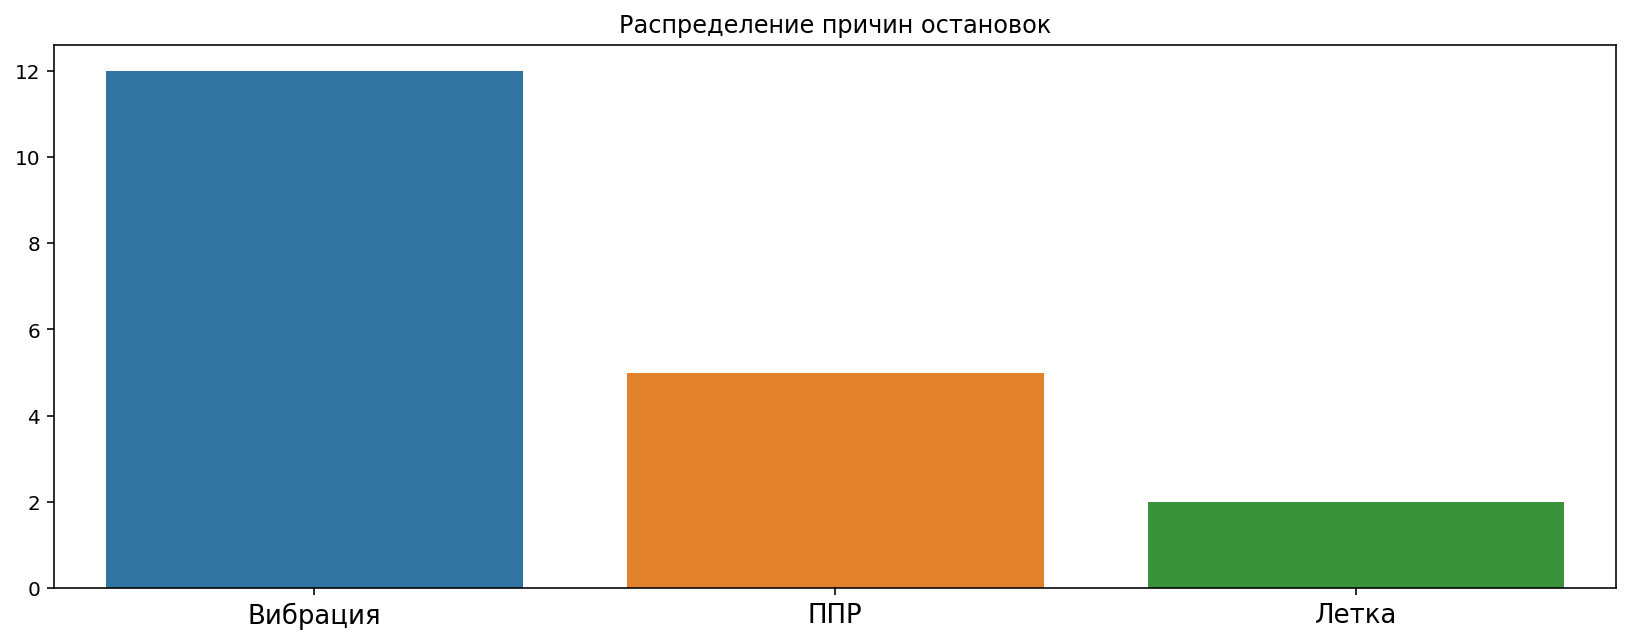

In [71]:
reasons_count = Febraury_StopLog.Reason.value_counts()
Reasons = ["Вибрация", "ППР", "Летка"]
plt.figure(figsize=(14,5))
plt.title("Распределение причин остановок")
plt.xticks(fontsize=13)
sns.barplot(x = Reasons, y=reasons_count.values)

In [72]:
from copy import deepcopy

df = deepcopy(SensorsData.iloc[:43000:5,:])
Stops_Series = pd.Series(np.zeros(df.shape[0], ), index=df.index.values)

# add condition : [Febraury_StopLog.Reason == "__"]
Begin_Dates = Febraury_StopLog.Begin.values.astype('datetime64[ns]')
End_Dates = Febraury_StopLog.End.values.astype('datetime64[ns]')

#BeginEnd_Times = sorted(np.concatenate([Begin_Dates, End_Dates]))
BeginEnd_Times = []
for i in range(len(Begin_Dates)):
    BeginEnd_Times.append(Begin_Dates[i])
    BeginEnd_Times.append(End_Dates[i])

fill_flag = True
for stop_date in BeginEnd_Times:
    for i in range(len(Stops_Series.index)):
        if (df.index[i] < stop_date <= df.index[i+1]):
            Stops_Series[df.index[i]:] = int(fill_flag)
            break
    fill_flag = not fill_flag

# Модель классификации

<div class = "alert alert-block alert-danger">

<b>ЗДЕСЬ НАДО НАПИСАТЬ ПАЙПЛАЙН</b>

</div>

## Препроцессинг

In [73]:
SensorsData.columns[:-14]

Index(['Температура обмотки статора А (датчик №1)',
       'Температура обмотки статора А (датчик №2)',
       'Температура обмотки статора В (датчик №1)',
       'Температура обмотки статора В (датчик №2)',
       'Температура обмотки статора С (датчик №1)',
       'Температура обмотки статора С (датчик №2)',
       'Температура переднего подшипника двигателя',
       'Температура заднего подшипника двигателя',
       'Давление в масляном домкрате (передний подшипник)',
       'Давление в масляном домкрате (задний подшипник)',
       'Вибрация переднего подшипника двигателя (осевая)',
       'Вибрация переднего подшипника двигателя (радиальная)',
       'Вибрация заднего подшипника двигателя (осевая)',
       'Вибрация заднего подшипника двигателя (радиальная)'],
      dtype='object')

In [74]:
Data = pd.concat([SensorsData.iloc[:,:-14], Stops_Series], axis=1).dropna()
Data.columns = list(Data.columns[:-1]) + ['target']

X = Data.iloc[:,:-1]
y = Data.iloc[:,-1]

In [75]:
Data.to_csv("../Probe_Data/Febraury_PredData.csv")

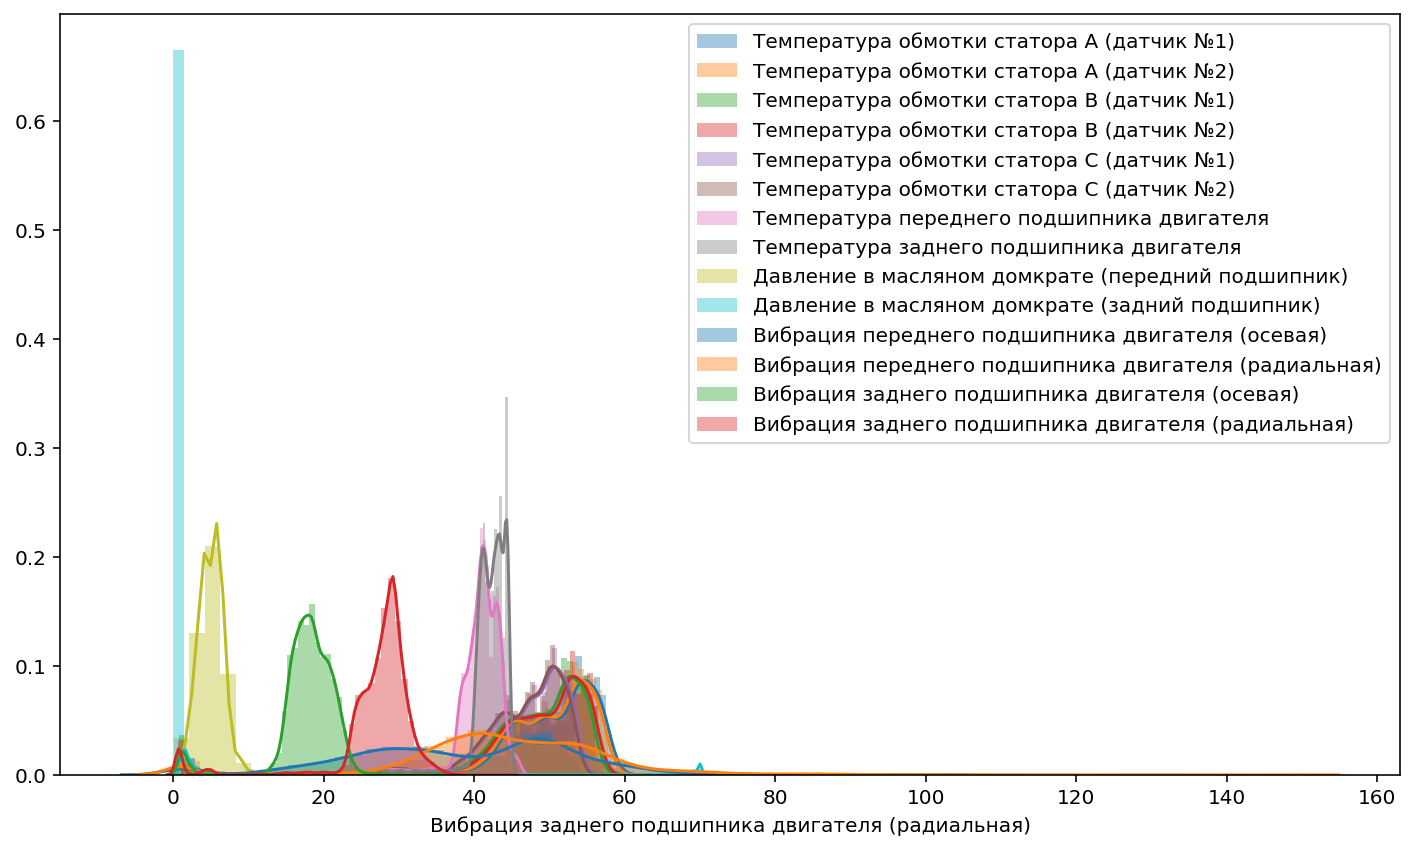

In [56]:
""" 
До препроцессинга :

"""
plt.figure(figsize=(12,7))
for sens_name in X.columns:
    sns.distplot(X[sens_name], label=sens_name)
plt.legend()


In [57]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X.iloc[:,:] = ss.fit_transform(X)

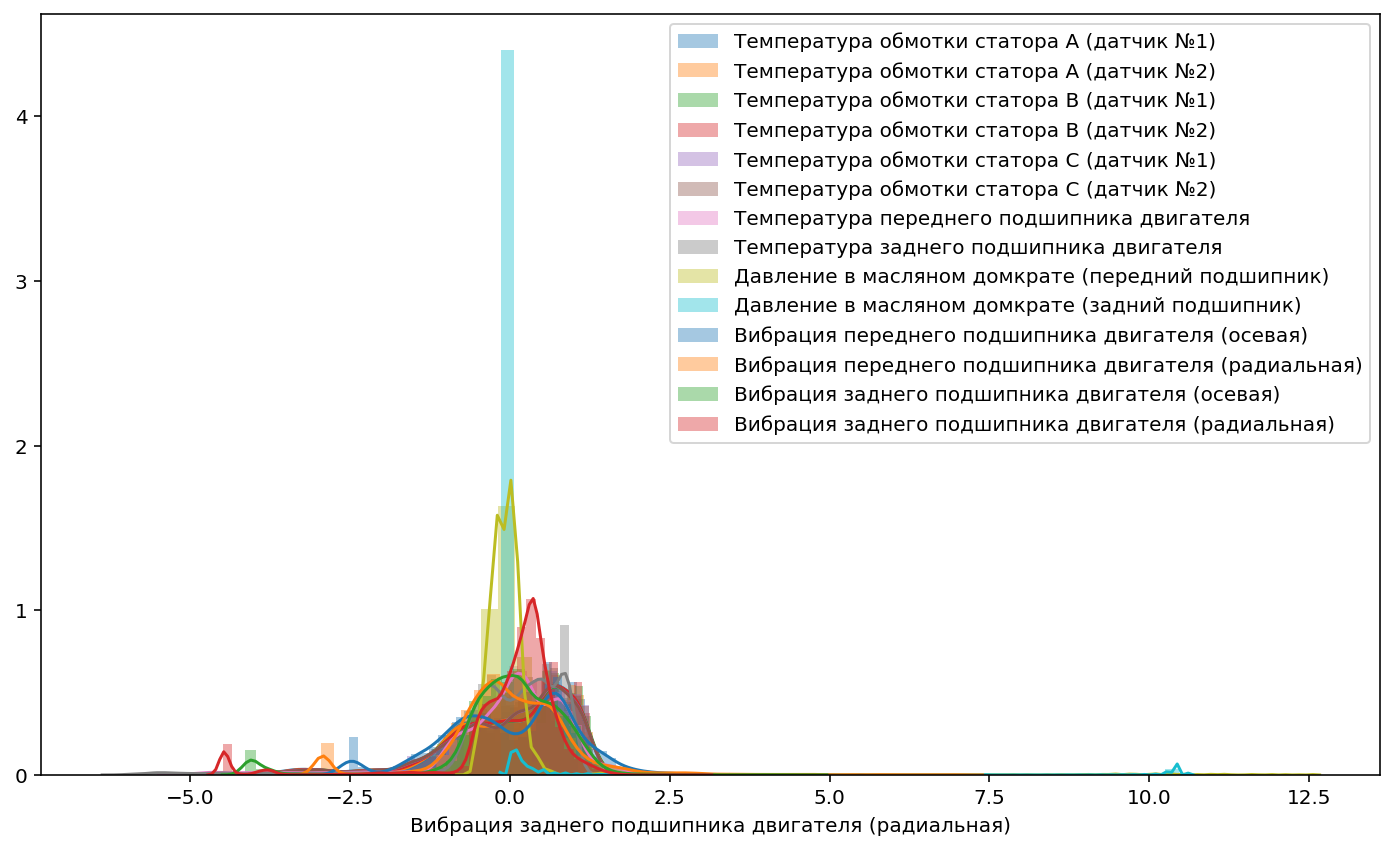

In [58]:
""" 
После препроцессинга

"""
plt.figure(figsize=(12,7))
for sens_name in X.columns:
    sns.distplot(X[sens_name], label=sens_name)
plt.legend()



## Поиск аномалий

<div class = "alert alert-block alert-info">

<b> 
Дополним разметку данных. Будут использоваться не только журнальные данные об остановках, но и 
найденные выбросы в данных
</b>

</div>

In [59]:
from sklearn.cluster import DBSCAN, k_means
from sklearn.metrics import classification_report, confusion_matrix

In [60]:
def print_results(conf_matrix):
    try:
        print(f"Длительность остановок (мин): {conf_matrix[1,:].sum()*5}")
        print(f"False Positive : {conf_matrix[0,1]*5}")
        print(f"False Negative : {conf_matrix[1,0]*5}")
        print(f"True Positive : {conf_matrix[1,1]*5}")
    except IndexError:
        print('--pass--')
    print("=========================")

In [44]:
for day in range(1,30):
    X_day = X.loc[f"2020-02-{day}":f"2020-02-{day}"]
    y_day = y.loc[f"2020-02-{day}":f"2020-02-{day}"][0]
    preds = (DBSCAN(eps=0.5, min_samples=2).fit_predict(X_day) == -1).astype(int)#k_means(X_day, n_clusters=2)[1]
#     conf_mat = confusion_matrix(y_day, preds)
    
    print(f"For {day} febraury:\n")
    #print(confusion_matrix(y_day, preds))
    print_results(confusion_matrix(y_day, preds))
    
    

For 1 febraury:



TypeError: Singleton array 0.0 cannot be considered a valid collection.

In [61]:
Preds = pd.Series(((DBSCAN().fit_predict(X) == -1) | (DBSCAN().fit_predict(X) == 1)).astype(int), index=y.index)

In [62]:
print(classification_report(y, Preds))

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      8296
         1.0       0.14      0.48      0.22       304

    accuracy                           0.88      8600
   macro avg       0.56      0.69      0.58      8600
weighted avg       0.95      0.88      0.91      8600



In [79]:
from ipywidgets import interact, interact_manual
from bokeh.models import HoverTool, Range1d, LinearAxis
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider, DateSlider
from bokeh.plotting import ColumnDataSource, figure, output_file, show

@interact
def plot(Signal_1 = SensorsData.columns[:-5],
         Signal_2 = SensorsData.columns[:-5]):
    
    df = deepcopy(SensorsData.iloc[:43000:5,:])
    Stops_df = pd.DataFrame(Stops_Series, columns=['value'])
    Preds_df = pd.DataFrame(Preds, columns=['value'])
    
    y_overlimit = 0.05

    line_plot = figure(plot_width=950, plot_height=600, 
                       x_axis_type="datetime", toolbar_location="above",
                       active_scroll="wheel_zoom")

    line_plot.extra_y_ranges = {
        "Signal_1_range": Range1d(df[Signal_1].min() * (1 - y_overlimit),
                                df[Signal_1].max() * (1 + y_overlimit)),

        "Signal_2_range": Range1d(df[Signal_2].min() * (1 - y_overlimit),
                                df[Signal_2].max() * (1 + y_overlimit))
    }

    ## Signal 1 Plot
    line_plot.line(x=df.index,
                   y=df[Signal_1],
                   legend=Signal_1,
                   line_width=2,
                   y_range_name="Signal_1_range",
                   color="red",)

    ## Signal 2 Plot
    line_plot.add_layout(LinearAxis(y_range_name = "Signal_2_range"), "right")
    line_plot.line(x=df.index,
                   y=df[Signal_2],
                   legend=Signal_2,
                   line_width=2,
                   y_range_name="Signal_2_range",
                   color="green",)


    df['train_loc'] = 0
    df['pred_loc'] = 0
    df['G_color'] = 0
    df['R_color'] = 0
    df['v_preds'] = 0

    max_1, max_2 = df[Signal_1].max(), df[Signal_2].max()
    min_1, min_2 = df[Signal_1].min(), df[Signal_2].min()
    MIN = min(min_1, min_2)
    MAX = max(max_1, max_2)
    
    Stops_df = Stops_df*MAX
    Preds_df = Preds_df*MAX
    
    VIB = df.iloc[:,10].values
    MIN_VIB, MAX_VIB = VIB.min(), VIB.max()

    source = ColumnDataSource(data=dict(date=df.index, vib=VIB, v_preds=df.v_preds.values,
                                        train=df.train_loc.values, pred=df.pred_loc.values))

    loc_slider = DateSlider(start=df.index[0], 
                            end=df.index[-1], 
                            value=df.index[0],
                            step=1,
                            width=900,
                            title='Location')

    width_slider = Slider(start=250,
                          end=600, 
                          value=250,
                          step=2,
                          width=900,
                          title='Width')


    callback = CustomJS(args=dict(source=source, loc=loc_slider, width=width_slider,
                                  MAX=MAX_VIB, _mean_vib = (MAX_VIB + MIN_VIB)/2),
                        code=\
        """
        const data = source.data;
        const max = MAX;
        const x = data['date'];
        const y = data['train'];
        const p = data['pred'];
        const v = data['vib'];
        const vP = data['v_preds'];

        const mean_vib = _mean_vib;
        var sum_vib = 0.0;

        for (var i = 0; i < x.length; i++) {

            if (x[i] < loc.value || x[i] > loc.value + width.value * 10**5){
                y[i] = 0;
            } else {
                y[i] = max;
            }

            if (x[i] < loc.value + width.value * 10**5 || x[i] > loc.value + width.value * 10**5 + 2*10**7) {
                p[i] = 0;
            } else {
                p[i] = max;
            }
        }

        for (var j = 0; j < x.length; j++) {
            if (p[j] !== 0) {
                sum_vib += v[j] / 32;
            }
        }

        for (var k = 0; k < x.length; k++) {
            if(p[k] !== 0) {
                vP[k] = Math.abs(max - sum_vib);
            } else {
                vP[k] = 0;
            }
        }


        source.change.emit();
        return source
        """
                       )

    loc_slider.js_on_change('value', callback)
    width_slider.js_on_change('value', callback)

#     line_plot.varea_stack(['train'],
#                            x='date',
#                            color=[ (50,50,250) ],
#                            source=source,
#                            fill_alpha=0.2,
#                            legend="Обучение")

#     line_plot.varea_stack(['v_preds'],
#                            x='date',
#                            color=[ 'orange' ],
#                            source=source,
#                            fill_alpha=0.5,
#                            legend="Предсказание уровня опасности")

    line_plot.varea_stack(['value'],
                           x='index',
                           color=('red'),
                           source=Stops_df,
                           fill_alpha=0.3,
                           legend='Остановки')
    
    line_plot.varea_stack(['value'],
                           x='index',
                           color=('blue'),
                           source=Preds_df,
                           fill_alpha=0.3,
                           legend='Аномалии')


    
    layout = column(
        line_plot, loc_slider, width_slider
    )

#     output_file("PseudoPredict_plot.html")

    show(layout)

interactive(children=(Dropdown(description='Signal_1', options=('Температура обмотки статора А (датчик №1)', '…

In [64]:
## Новый таргет с учетом найденных выбросов
Y = (y.astype(bool) + Preds.astype(bool)).astype(int)

## Таргет сдвинутый на N шагов влево, то есть '1'-ы стоят незадолго то самой остановки
Y_SHIFT = Y.shift(-36, fill_value=0)

In [65]:
Data = pd.read_csv("../Probe_Data/Febraury_PredData.csv", index_col=0)
Data['target'] = Y
# Data['shift_target'] = Y_SHIFT
Data.to_csv("../Probe_Data/Febraury_PredData.csv")

## Классификация на отложенной выборке

In [24]:
X_train, X_test = X.loc[:"2020-02-22"], X.loc["2020-02-23":]
Y_train, Y_test = Y_SHIFT.loc[:"2020-02-22"], Y_SHIFT.loc["2020-02-23":]

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [26]:
CLF = LogisticRegression().fit(X_train, Y_train)
Train_Preds = CLF.predict(X_train)
Test_Preds = CLF.predict(X_test)

print("Train Predictions : \n")
print(classification_report(Y_train, Train_Preds))

print("Test Predictions : \n")
print(classification_report(Y_test, Test_Preds))

Train Predictions : 

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      5432
           1       0.75      0.33      0.46      1190

    accuracy                           0.86      6622
   macro avg       0.81      0.65      0.69      6622
weighted avg       0.85      0.86      0.84      6622

Test Predictions : 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1782
           1       0.76      0.28      0.40       196

    accuracy                           0.92      1978
   macro avg       0.84      0.63      0.68      1978
weighted avg       0.91      0.92      0.90      1978



In [27]:
TruePred_Data = pd.DataFrame(columns=['true', 'shift_true', 'pred'], index=Y.index)

TruePred_Data['true'] = Y.values
TruePred_Data['shift_true'] = Y_SHIFT.values
TruePred_Data['pred'] = np.concatenate([Train_Preds, Test_Preds], axis=0)

In [28]:
from ipywidgets import interact, interact_manual
from bokeh.models import HoverTool, Range1d, LinearAxis
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider, DateSlider
from bokeh.plotting import ColumnDataSource, figure, output_file, show

@interact
def plot(Signal_1 = SensorsData.columns[:-5],
         Signal_2 = SensorsData.columns[:-5],
         ucol = TruePred_Data.columns[:]):
    
    df = deepcopy(SensorsData.iloc[:43000:5,:])
    TP_DATA = deepcopy(TruePred_Data)
    Stops_df = pd.DataFrame(Stops_Series, columns=['value'])
    Preds_df = pd.DataFrame(Preds, columns=['value'])
    
    y_overlimit = 0.05

    line_plot = figure(plot_width=950, plot_height=600, 
                       x_axis_type="datetime", toolbar_location="above",
                       active_scroll="wheel_zoom")

    line_plot.extra_y_ranges = {
        "Signal_1_range": Range1d(df[Signal_1].min() * (1 - y_overlimit),
                                df[Signal_1].max() * (1 + y_overlimit)),

        "Signal_2_range": Range1d(df[Signal_2].min() * (1 - y_overlimit),
                                df[Signal_2].max() * (1 + y_overlimit))
    }

    ## Signal 1 Plot
    line_plot.line(x=df.index,
                   y=df[Signal_1],
                   legend=Signal_1,
                   line_width=2,
                   y_range_name="Signal_1_range",
                   color="red",)

    ## Signal 2 Plot
    line_plot.add_layout(LinearAxis(y_range_name = "Signal_2_range"), "right")
    line_plot.line(x=df.index,
                   y=df[Signal_2],
                   legend=Signal_2,
                   line_width=2,
                   y_range_name="Signal_2_range",
                   color="green",)


    df['train_loc'] = 0
    df['pred_loc'] = 0
    df['G_color'] = 0
    df['R_color'] = 0
    df['v_preds'] = 0

    max_1, max_2 = df[Signal_1].max(), df[Signal_2].max()
    min_1, min_2 = df[Signal_1].min(), df[Signal_2].min()
    MIN = min(min_1, min_2)
    MAX = max(max_1, max_2)
    
    Stops_df = Stops_df*MAX
    Preds_df = Preds_df*MAX
    TP_DATA = TP_DATA*MAX
    
    VIB = df.iloc[:,10].values
    MIN_VIB, MAX_VIB = VIB.min(), VIB.max()

    source = ColumnDataSource(data=dict(date=df.index, vib=VIB, v_preds=df.v_preds.values,
                                        train=df.train_loc.values, pred=df.pred_loc.values))

    loc_slider = DateSlider(start=df.index[0], 
                            end=df.index[-1], 
                            value=df.index[0],
                            step=1,
                            width=900,
                            title='Location')

    width_slider = Slider(start=250,
                          end=600, 
                          value=250,
                          step=2,
                          width=900,
                          title='Width')


    callback = CustomJS(args=dict(source=source, loc=loc_slider, width=width_slider,
                                  MAX=MAX_VIB, _mean_vib = (MAX_VIB + MIN_VIB)/2),
                        code=\
        """
        const data = source.data;
        const max = MAX;
        const x = data['date'];
        const y = data['train'];
        const p = data['pred'];
        const v = data['vib'];
        const vP = data['v_preds'];

        const mean_vib = _mean_vib;
        var sum_vib = 0.0;

        for (var i = 0; i < x.length; i++) {

            if (x[i] < loc.value || x[i] > loc.value + width.value * 10**5){
                y[i] = 0;
            } else {
                y[i] = max;
            }

            if (x[i] < loc.value + width.value * 10**5 || x[i] > loc.value + width.value * 10**5 + 2*10**7) {
                p[i] = 0;
            } else {
                p[i] = max;
            }
        }

        for (var j = 0; j < x.length; j++) {
            if (p[j] !== 0) {
                sum_vib += v[j] / 32;
            }
        }

        for (var k = 0; k < x.length; k++) {
            if(p[k] !== 0) {
                vP[k] = Math.abs(max - sum_vib);
            } else {
                vP[k] = 0;
            }
        }


        source.change.emit();
        return source
        """
                       )

    loc_slider.js_on_change('value', callback)
    width_slider.js_on_change('value', callback)

#     line_plot.varea_stack(['train'],
#                            x='date',
#                            color=[ (50,50,250) ],
#                            source=source,
#                            fill_alpha=0.2,
#                            legend="Обучение")

#     line_plot.varea_stack(['v_preds'],
#                            x='date',
#                            color=[ 'orange' ],
#                            source=source,
#                            fill_alpha=0.5,
#                            legend="Предсказание уровня опасности")

    line_plot.line(x=TP_DATA.index,
                   y=TP_DATA['true'],
                   legend='',
                   alpha=0.2,
                   line_width=2,
                   color="red")
    
    line_plot.varea_stack(['shift_true'],
                           x='index',
                           color=('red'),
                           source=TP_DATA,
                           fill_alpha=0.3,
                           legend='Таргет')
    
    line_plot.varea_stack(['pred'],
                           x='index',
                           color=('blue'),
                           source=TP_DATA,
                           fill_alpha=0.3,
                           legend='Предсказание')


    
    layout = column(
        line_plot, loc_slider, width_slider
    )

#     output_file("PseudoPredict_plot.html")

    show(layout)

interactive(children=(Dropdown(description='Signal_1', options=('Температура обмотки статора А (датчик №1)', '…

# Модель регрессии временного ряда

##  Статистические проверки

<div class = "alert alert-block alert-info">

<b>Стационарность временного ряда</b>

Есть три основных критерия для временного ряда, чтобы понять, является ли это стационарным рядом или нет.
* Статистические свойства временных рядов, такие как среднее значение, дисперсия должны оставаться постоянными во времени, чтобы назвать временной ряд стационарным:
    - постоянное среднее
    - постоянная дисперсия
    - автоковариация, которая не зависит от времени. автоковариация - ковариация между временными рядами и временными рядами с запаздыванием.
    
</div>

In [76]:
from bokeh.models import HoverTool, Range1d, LinearAxis
from copy import deepcopy
from ipywidgets import interact, interact_manual


def WindowCorr(S1, S2, width=90, step=10):
    """
    Расчет оконной корреляции двух временных рядов показаний датчиков.
    Скользящее окно заданной ширины проходит по двум рядам с заданным шагом
    и подсчитывает корреляцию Спирмена 
    [https://ru.wikipedia.org/wiki/Корреляция#Коэффициент_ранговой_корреляции_Спирмена]
    
    Parameters
    -----------
    
    S1, S2 : str
        Названия датчиков из соответствущей таблицы с данными
        
    width: int
        Ширина скользящего окна
    
    step: int
        Шаг с которым окно проходит по рядам
    """
    x, y = SensorsData[S1].values, SensorsData[S2].values
    assert(len(x) == len(y))
    time_index = [] #SensorsData.index
    Corr_arr = [] # pearson`s corr
    loc = 0
    for _ in range((len(x)-width)//step+1):
        w_x, w_y = x[loc:loc+width], y[loc:loc+width]
        Corr_arr.append(abs(spearmanr(w_x, w_y)[0]))
        time_index.append(SensorsData.index[loc])
        loc+=step
    time_index = pd.DatetimeIndex(time_index)
    df = pd.DataFrame(Corr_arr, index=time_index, columns=['corr'])
    df.index.name = 'date'
    return df

@interact
def plot(Завалка_Скрапа = False,
         Завалка_Чугуна = False,
         Продувка = False,
         Слив_Стали = False,
         Слив_Шлака = False,
         Show_Corr = False,
         Signal_1 = SensorsData.columns[:-5],
         Signal_2 = SensorsData.columns[:-5]):
    
    df = deepcopy(SensorsData.iloc[:43000:5,:])
    line_plot = figure(plot_width=950, plot_height=600, title='{} и {}'.format(Signal_1, Signal_2),
                       x_axis_type="datetime", toolbar_location="above",
                       active_scroll="wheel_zoom")
    
    y_overlimit = 0.05
    Signal_1_range = "Signal_1_range"
    Signal_2_range = "Signal_2_range"
    
    line_plot.extra_y_ranges = {
        Signal_1_range: Range1d(df[Signal_1].min() * (1 - y_overlimit),
                                df[Signal_1].max() * (1 + y_overlimit)),
        
        Signal_2_range: Range1d(df[Signal_2].min() * (1 - y_overlimit),
                                df[Signal_2].max() * (1 + y_overlimit))
    }
    
    ## Signal 1 Plot
    line_plot.line(x=df.index,
                   y=df[Signal_1],
                   legend=Signal_1,
                   line_width=2,
                   y_range_name=Signal_1_range,
                   color="red",)

    ## Signal 2 Plot
    line_plot.add_layout(LinearAxis(y_range_name=Signal_2_range), "right")

    line_plot.line(x=df.index,
                   y=df[Signal_2],
                   legend=Signal_2,
                   line_width=2,
                   y_range_name=Signal_2_range,
                   color="green",)
    
    MIN = min(df[Signal_1].min(), df[Signal_2].min())
    MAX = max(df[Signal_1].max(), df[Signal_2].max())
    Melting_args = [Завалка_Скрапа, Завалка_Чугуна, Продувка, Слив_Стали, Слив_Шлака]
    
    df = df*MAX
    df['date_index'] = df.index
    
    _fa = 0.15
    if Melting_args[0]:
        line_plot.varea_stack([' Плавка Завалка скрапа'],
                               x='date_index',
                               color=('magenta'),
                               source=df,
                               fill_alpha=_fa,
                               legend='Завалка скрапа')

    if Melting_args[1]:
        line_plot.varea_stack([' Плавка Завалка чугуна'],
                               x='date_index',
                               color=('orange'),
                               source=df,
                               fill_alpha=_fa,
                               legend='Завалка чугуна')

    if Melting_args[2]:
        line_plot.varea_stack([' Плавка Продувка'],
                               x='date_index',
                               color=('red'),
                               source=df,
                               fill_alpha=_fa,
                               legend='Продувка')

    if Melting_args[3]:
        line_plot.varea_stack([' Плавка Слив стали'],
                               x='date_index',
                               color=('green'),
                               source=df,
                               fill_alpha=_fa,
                               legend='Слив стали')

    if Melting_args[4]:
        line_plot.varea_stack([' Плавка Слив шлака'],
                               x='date_index',
                               color=('blue'),
                               source=df,
                               fill_alpha=_fa,
                               legend='Слив шлака')
    
    if (Show_Corr):
        corr_df = WindowCorr(Signal_1, Signal_2)*MAX
        line_plot.varea_stack( ['corr'],
                               x='date',
                               color=('magenta'),
                               source=corr_df,
                               fill_alpha=_fa,
                               legend='Correlation')
    
    # add hover tool
    line_plot.add_tools(HoverTool())
    
    
    show(line_plot)

interactive(children=(Checkbox(value=False, description='Завалка_Скрапа'), Checkbox(value=False, description='…

In [30]:
SensorsData.columns


Index(['Температура обмотки статора А (датчик №1)',
       'Температура обмотки статора А (датчик №2)',
       'Температура обмотки статора В (датчик №1)',
       'Температура обмотки статора В (датчик №2)',
       'Температура обмотки статора С (датчик №1)',
       'Температура обмотки статора С (датчик №2)',
       'Температура переднего подшипника двигателя',
       'Температура заднего подшипника двигателя',
       'Давление в масляном домкрате (передний подшипник)',
       'Давление в масляном домкрате (задний подшипник)',
       'Вибрация переднего подшипника двигателя (осевая)',
       'Вибрация переднего подшипника двигателя (радиальная)',
       'Вибрация заднего подшипника двигателя (осевая)',
       'Вибрация заднего подшипника двигателя (радиальная)',
       'Давление маслостанции', 'Расход маслостанции',
       'Температура в баке маслостанции', 'Скорость двигателя ПЧ БМЗ-1',
       'Ток двигателя ПЧ БМЗ-1', 'Индикатор ПО1 1 "Задание скорости"',
       'Индикатор ПО1 1 "Те

<div class = "alert alert-block alert-info">

Как видно из графика, например для осевой вибрации переднего подшипника двигателя, явной сезонности и тренда у поведения значений нет, ввиду постоянно проводимых перекалибровок и ППР двигателя. 

Мы можем проверить стационарность, используя следующие методы:
- <b>Построение скользящей статистики</b> : у нас есть окно, а затем мы находим скользящее среднее и дисперсию для проверки стационарности.
- <b>Тест Дики-Фуллера</b> : результаты теста включают статистику теста и некоторые критические значения для уровней достоверности различий. Если тестовая статистика меньше критического значения, мы можем сказать, что временной ряд является стационарным.    

</div>

In [31]:
# adfuller library 
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
# check_mean_std
def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(window=576).mean()
    rolstd = ts.rolling(window=576).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    

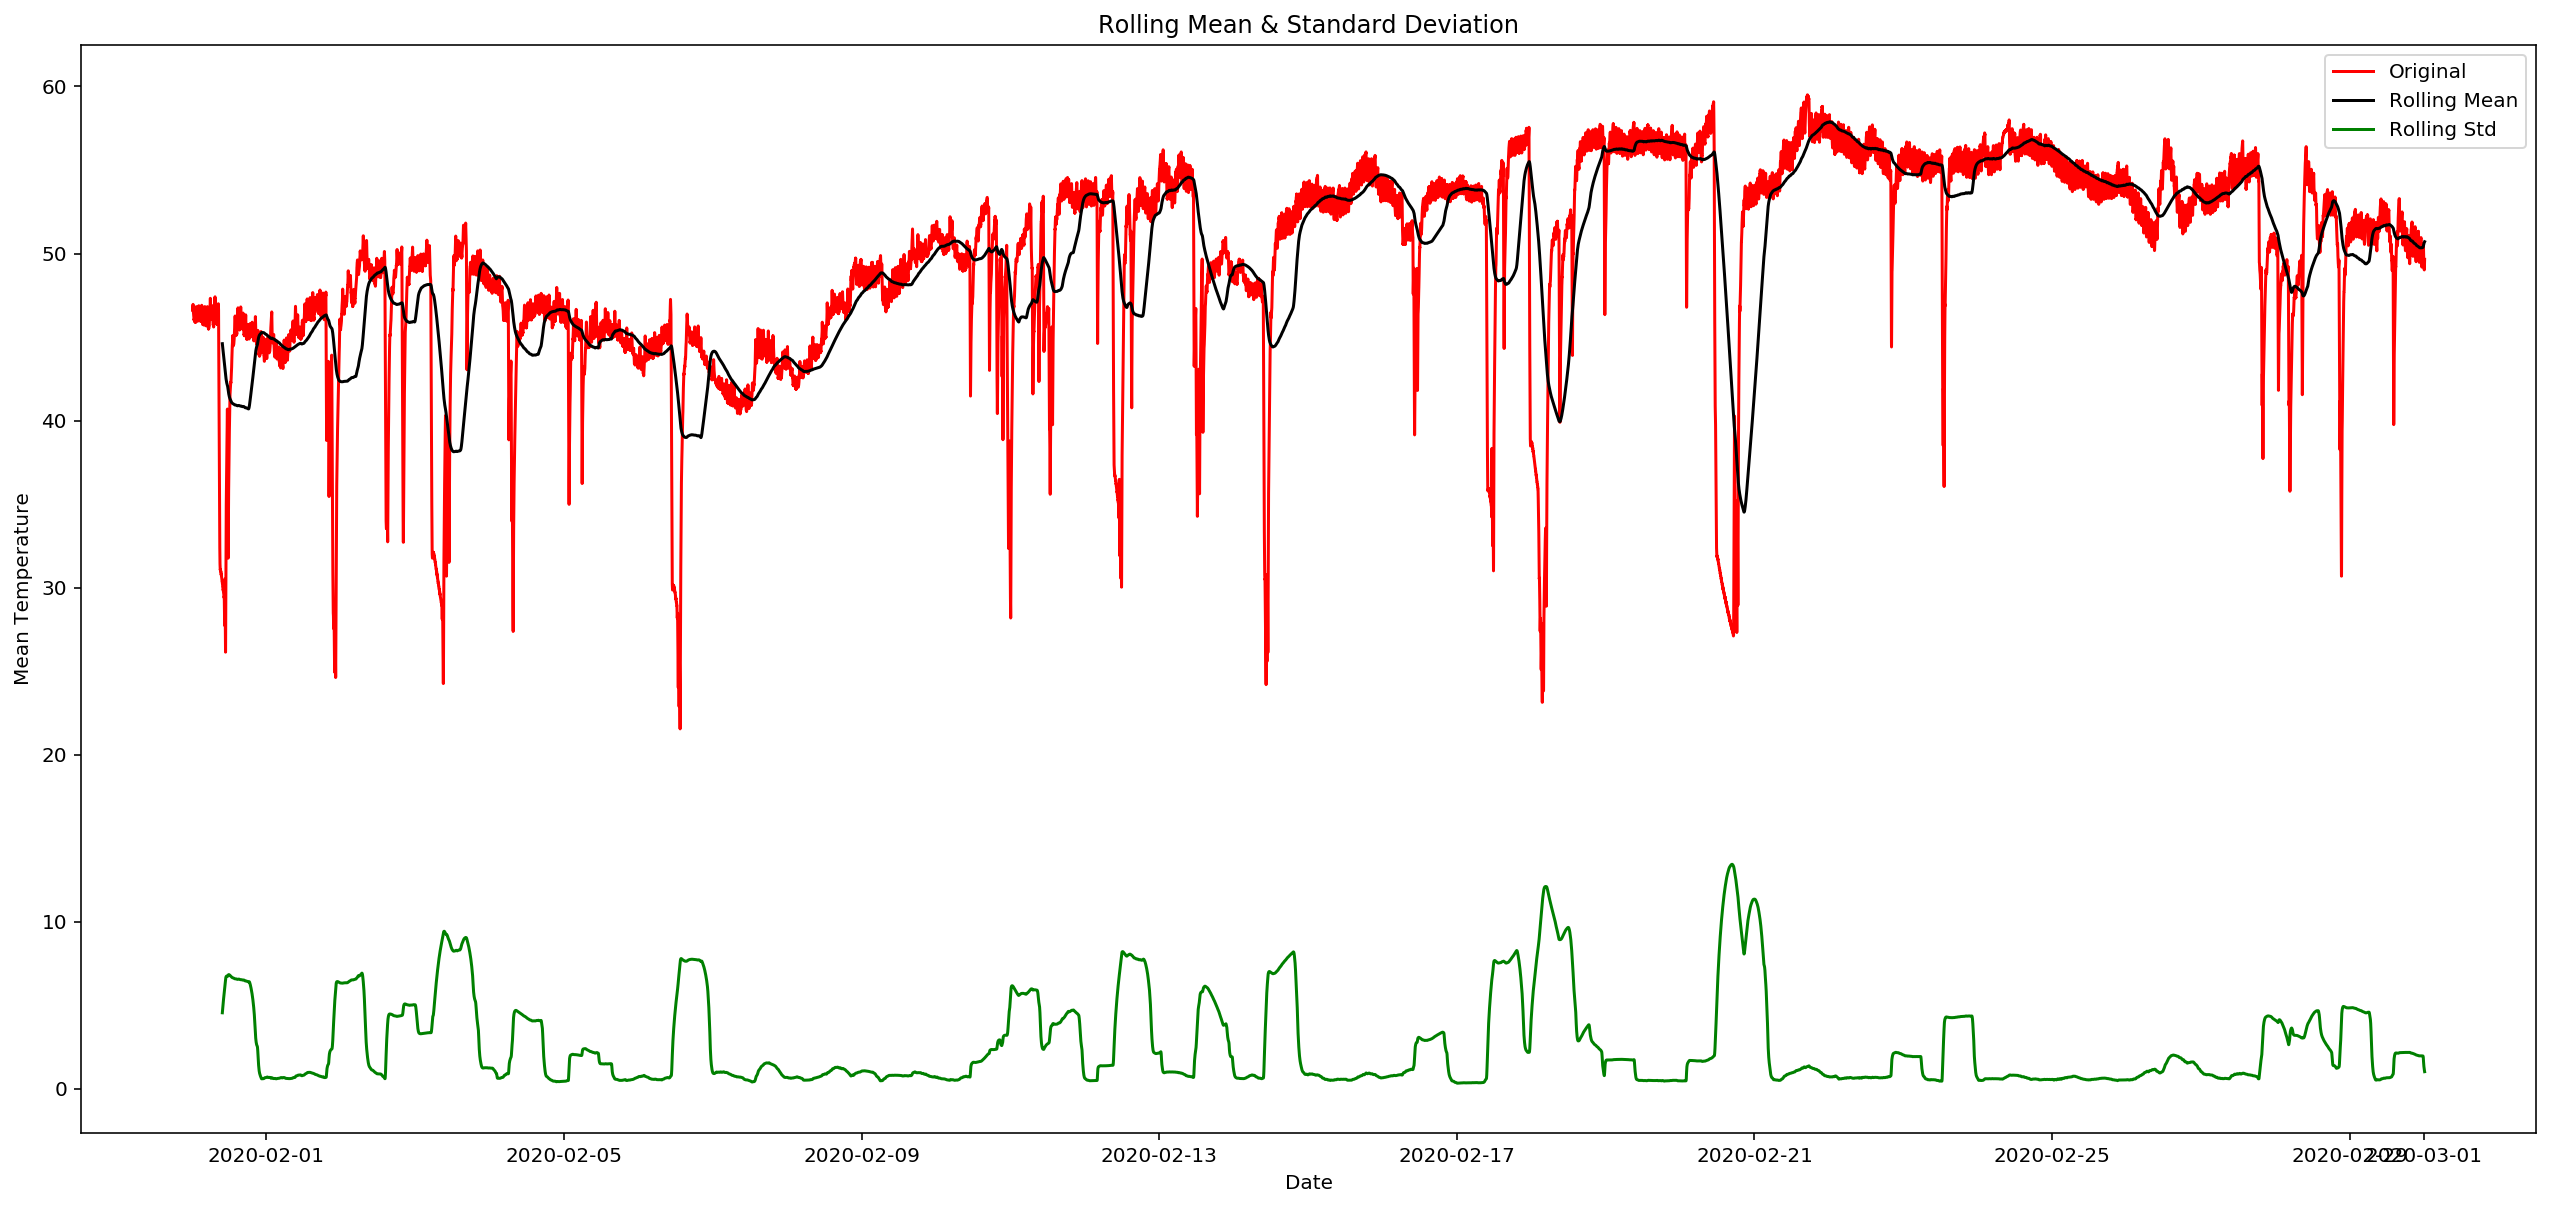

In [32]:
_sens_name = 'Температура обмотки статора А (датчик №2)'
ts = SensorsData[_sens_name]
check_mean_std(ts)

In [33]:
check_adfuller(ts)

Test statistic:  -8.210243834259494
p-value:  6.849417013343766e-13
Critical Values: {'1%': -3.430501560617088, '5%': -2.8616069864457256, '10%': -2.566805654710422}


In [34]:
for sens_name in SensorsData.columns[:-14]:
    result = adfuller(SensorsData[sens_name], autolag='AIC')
    if result[1] < 0.01:
        print(f"{sens_name} : Стационарный")
    else:
        print(f"{sens_name} : Нестационарный")

Температура обмотки статора А (датчик №1) : Стационарный
Температура обмотки статора А (датчик №2) : Стационарный
Температура обмотки статора В (датчик №1) : Стационарный
Температура обмотки статора В (датчик №2) : Стационарный
Температура обмотки статора С (датчик №1) : Стационарный
Температура обмотки статора С (датчик №2) : Стационарный
Температура переднего подшипника двигателя : Стационарный
Температура заднего подшипника двигателя : Стационарный
Давление в масляном домкрате (передний подшипник) : Стационарный
Давление в масляном домкрате (задний подшипник) : Стационарный
Вибрация переднего подшипника двигателя (осевая) : Стационарный
Вибрация переднего подшипника двигателя (радиальная) : Стационарный
Вибрация заднего подшипника двигателя (осевая) : Стационарный
Вибрация заднего подшипника двигателя (радиальная) : Стационарный


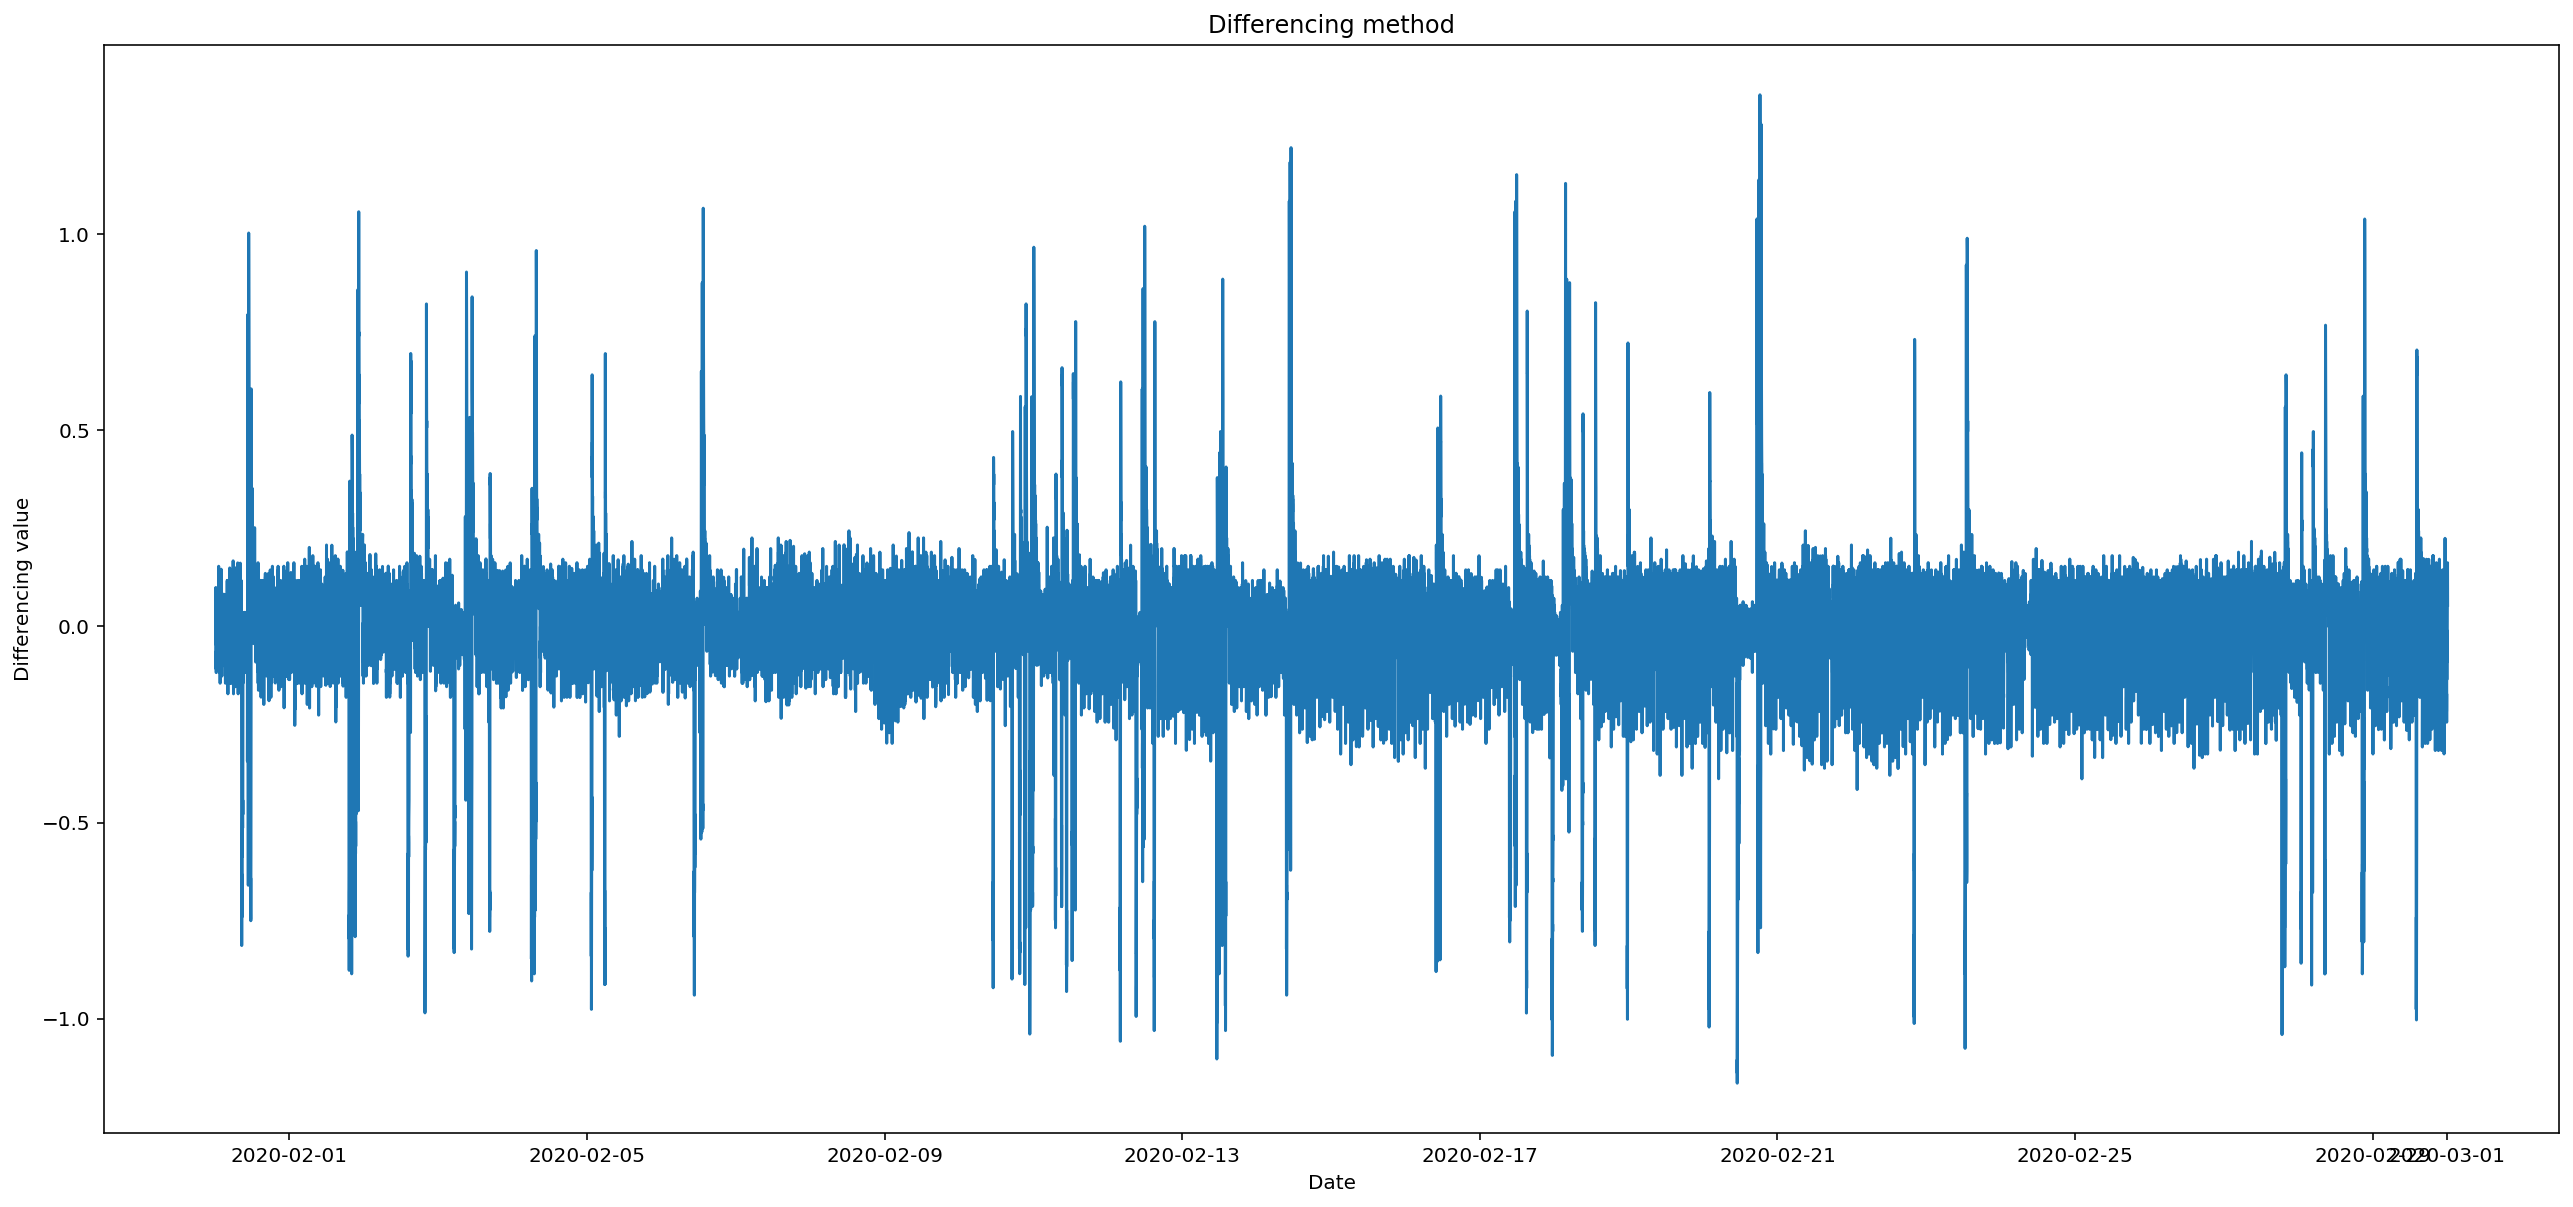

In [37]:
# differencing method
ts_diff = ts.diff()
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing value")
plt.show()

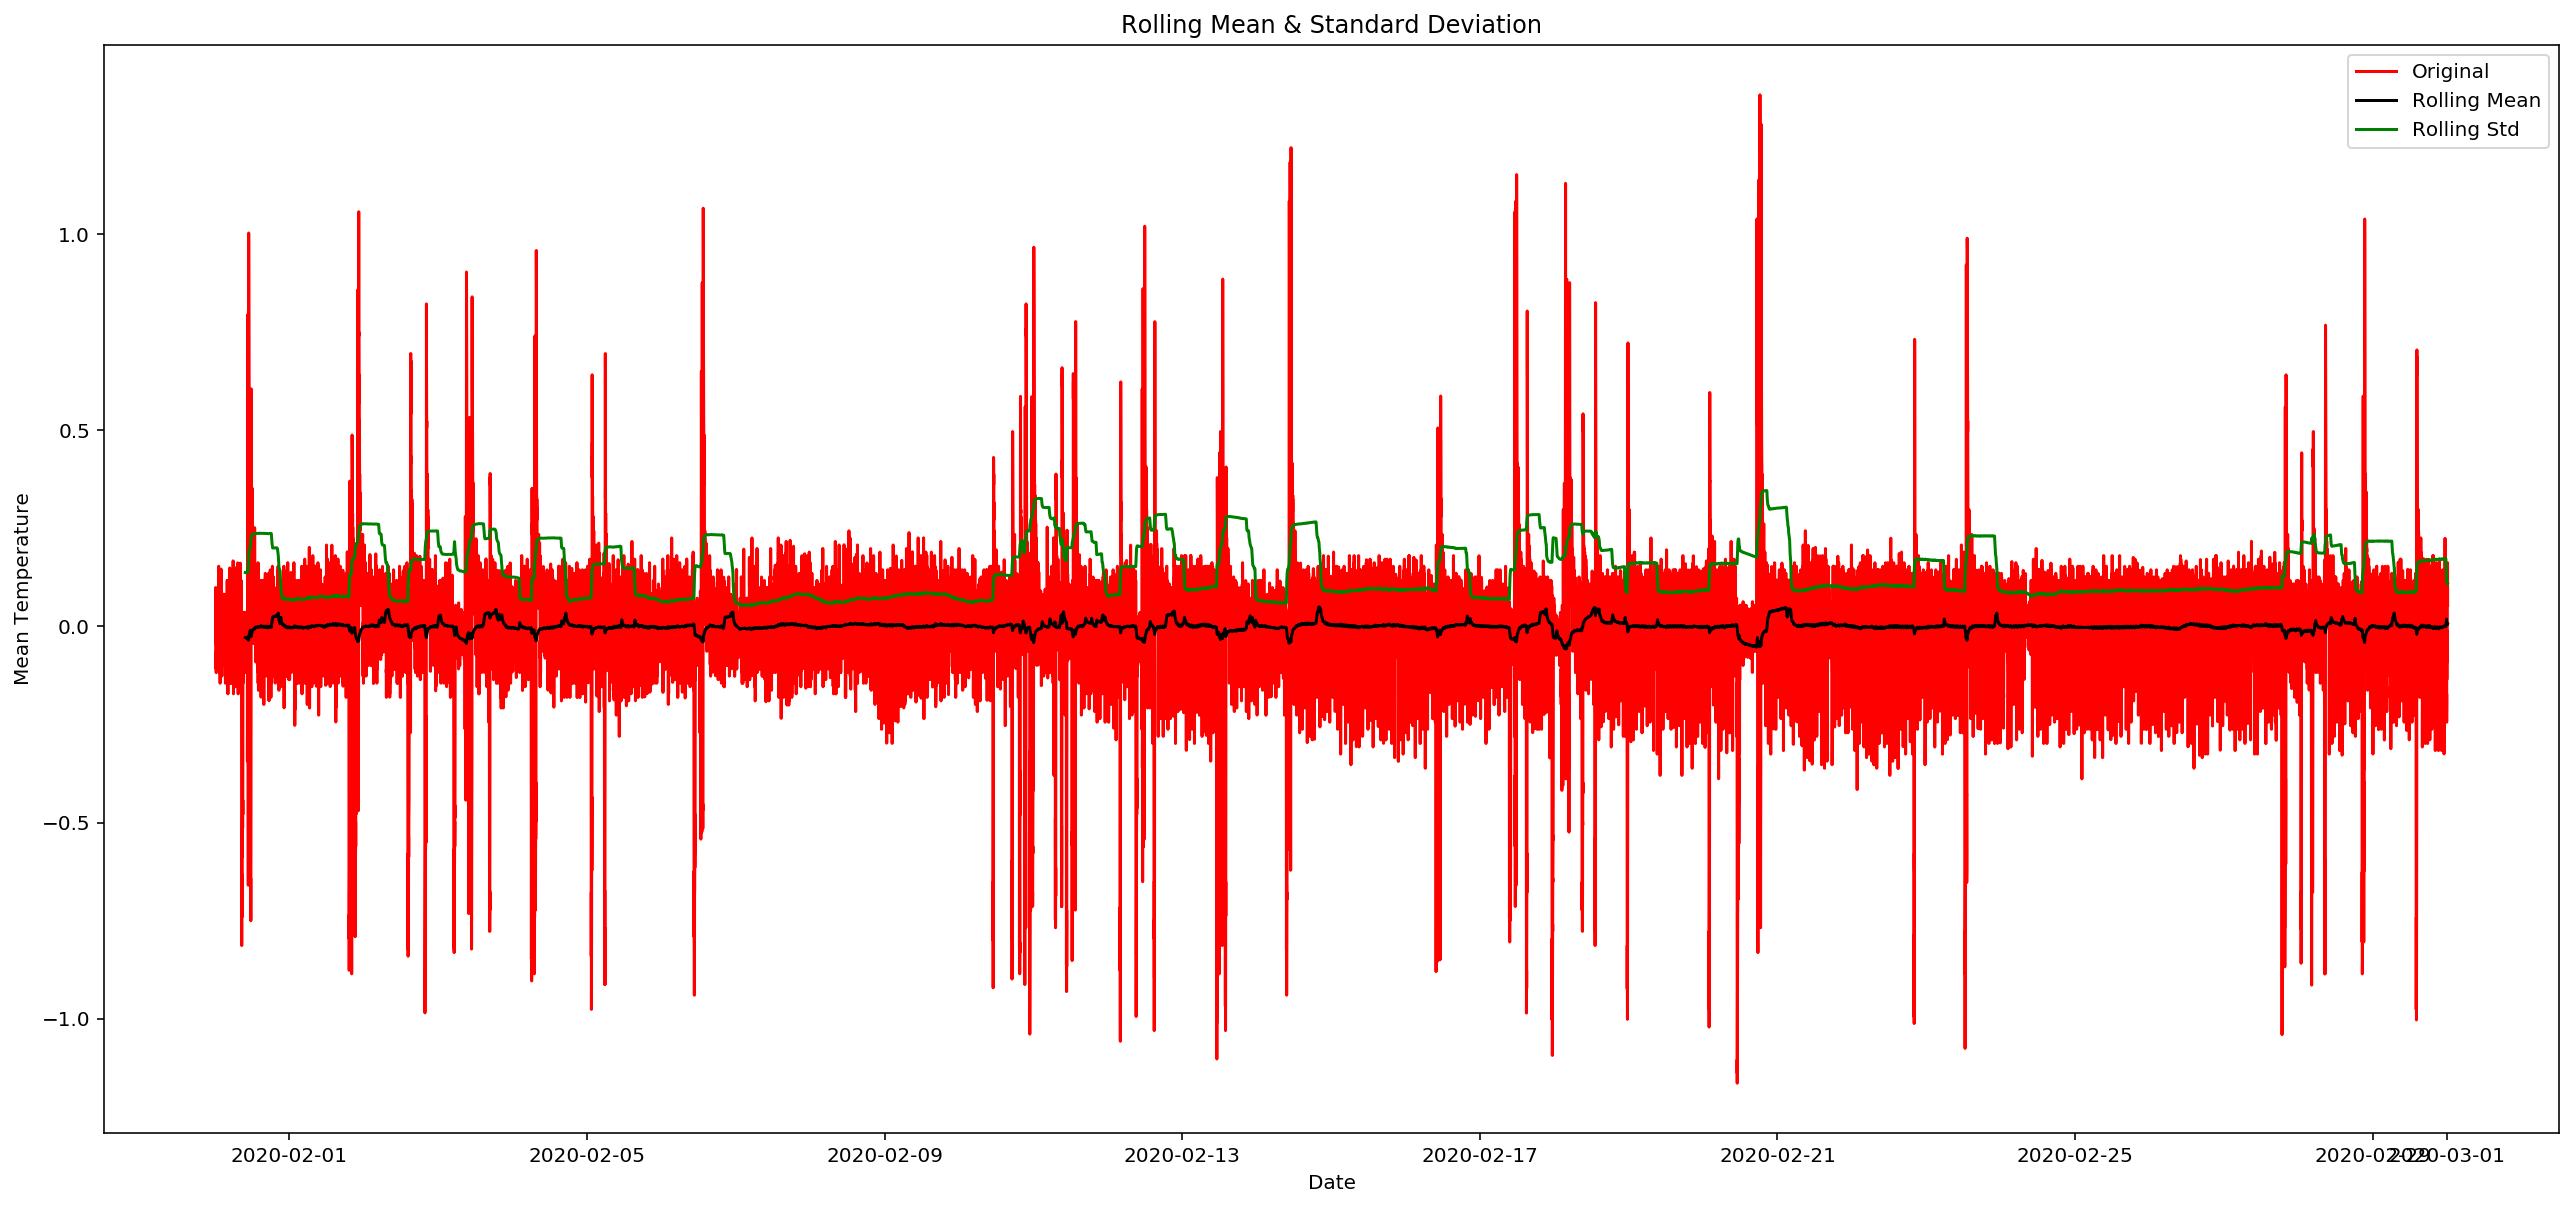

Test statistic:  -26.819035445584394
p-value:  0.0
Critical Values: {'1%': -3.4305015641298726, '5%': -2.8616069879982593, '10%': -2.5668056555367924}


In [38]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_diff)
check_adfuller(ts_diff)

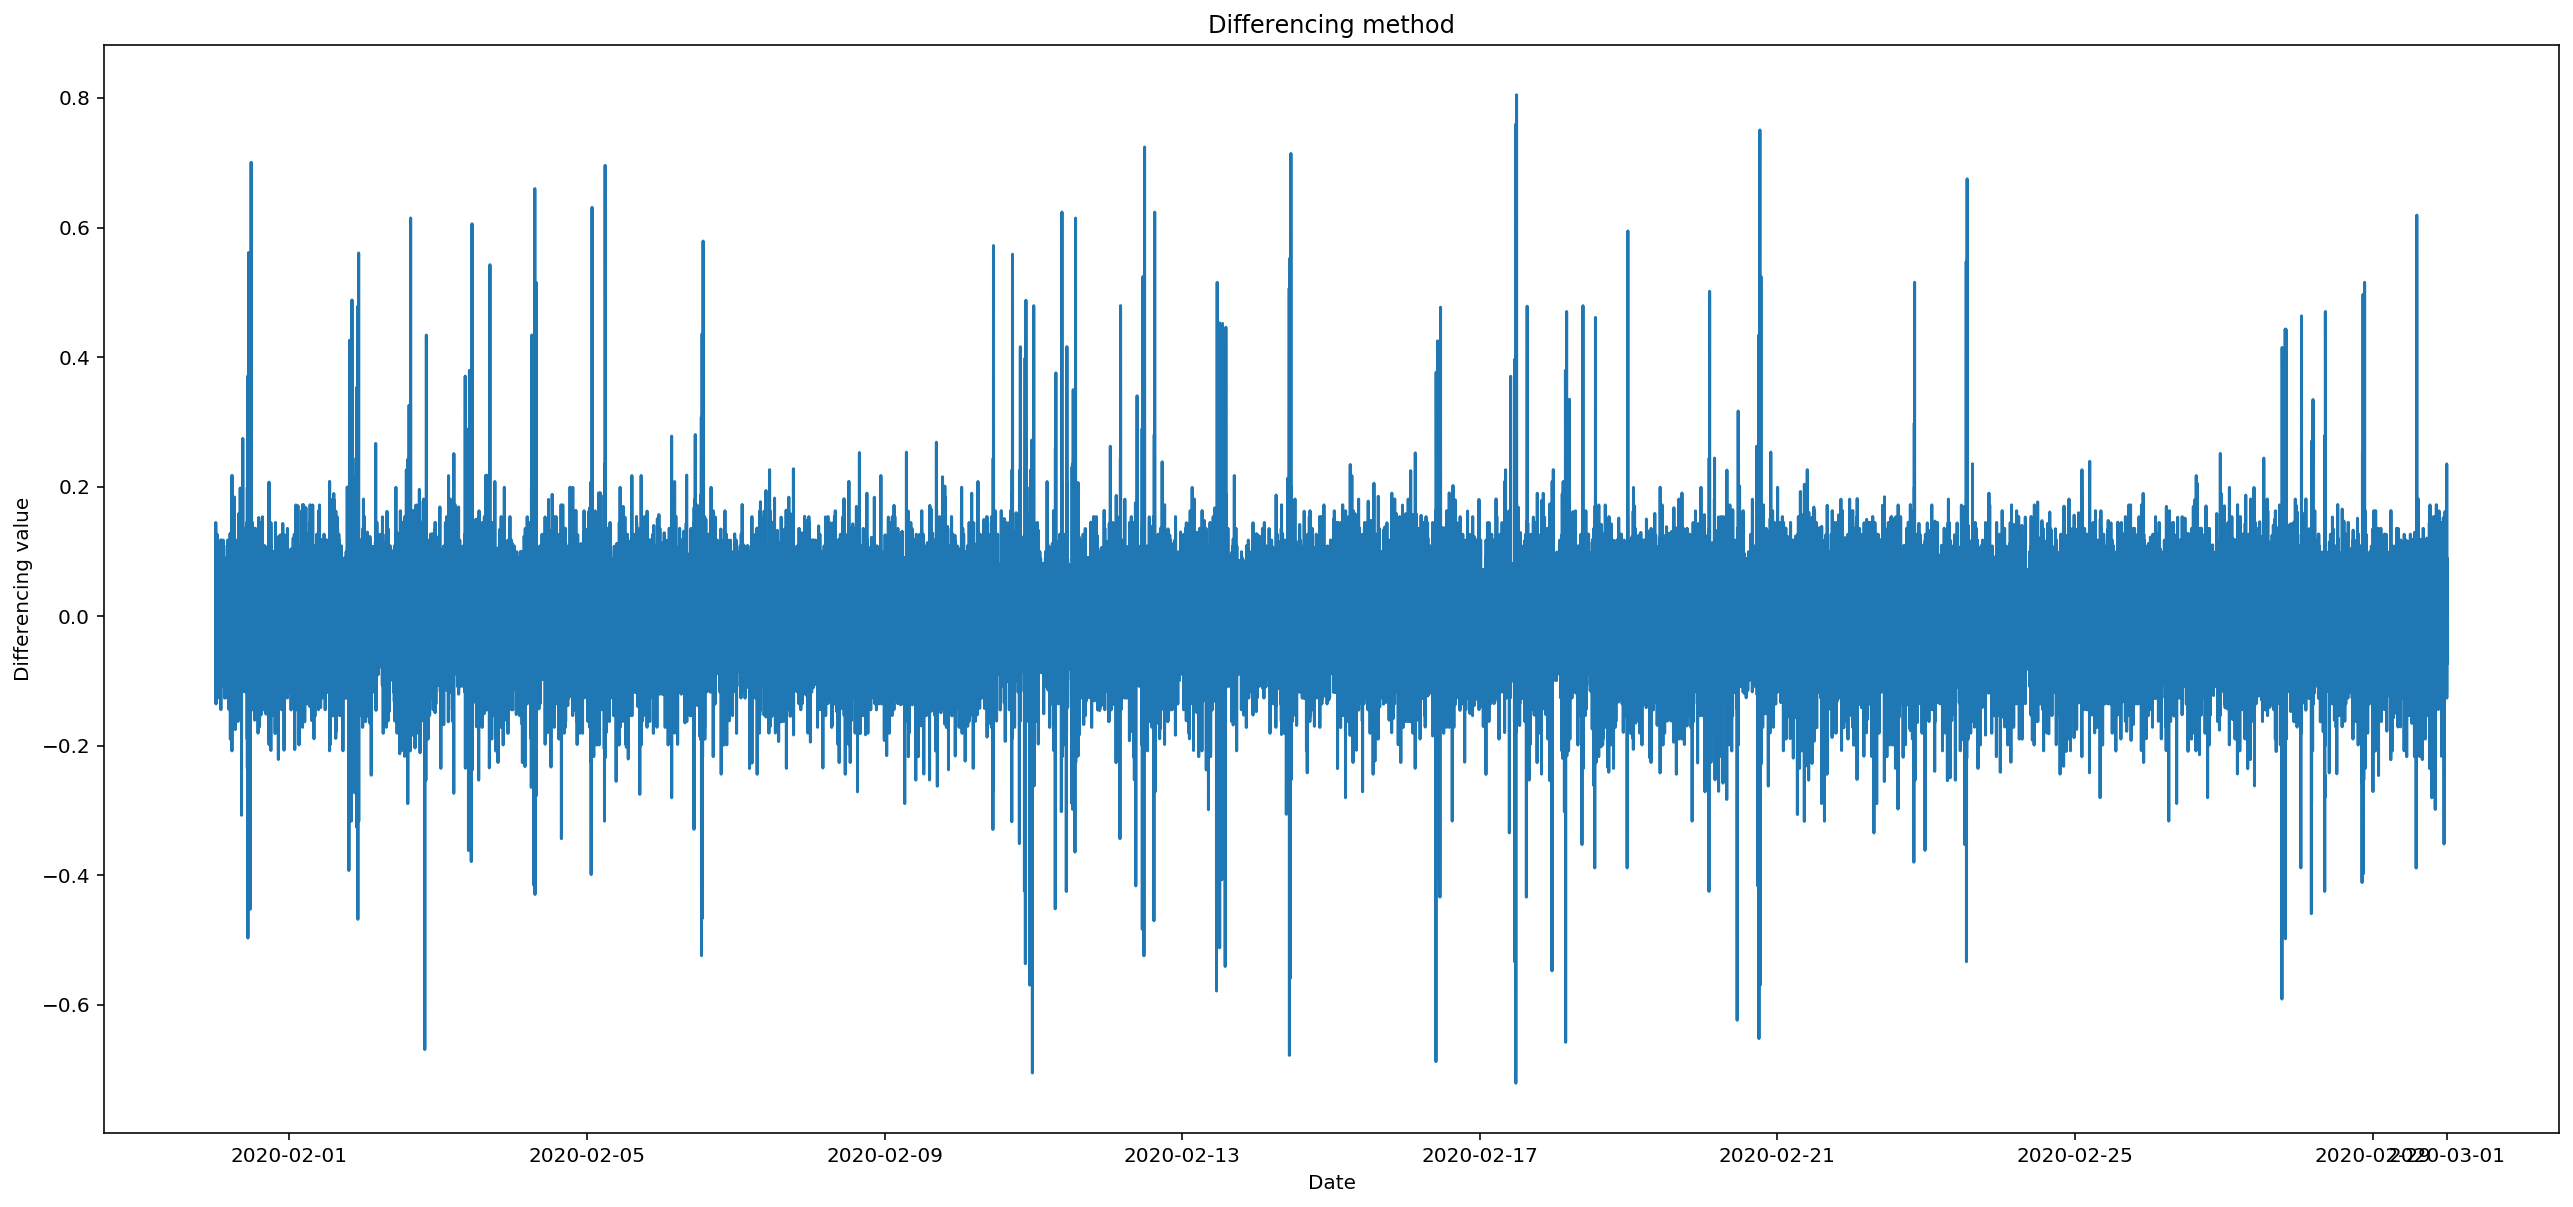

In [39]:
# differencing method
ts_2diff = ts_diff.diff()
plt.figure(figsize=(22,10))
plt.plot(ts_2diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing value")
plt.show()

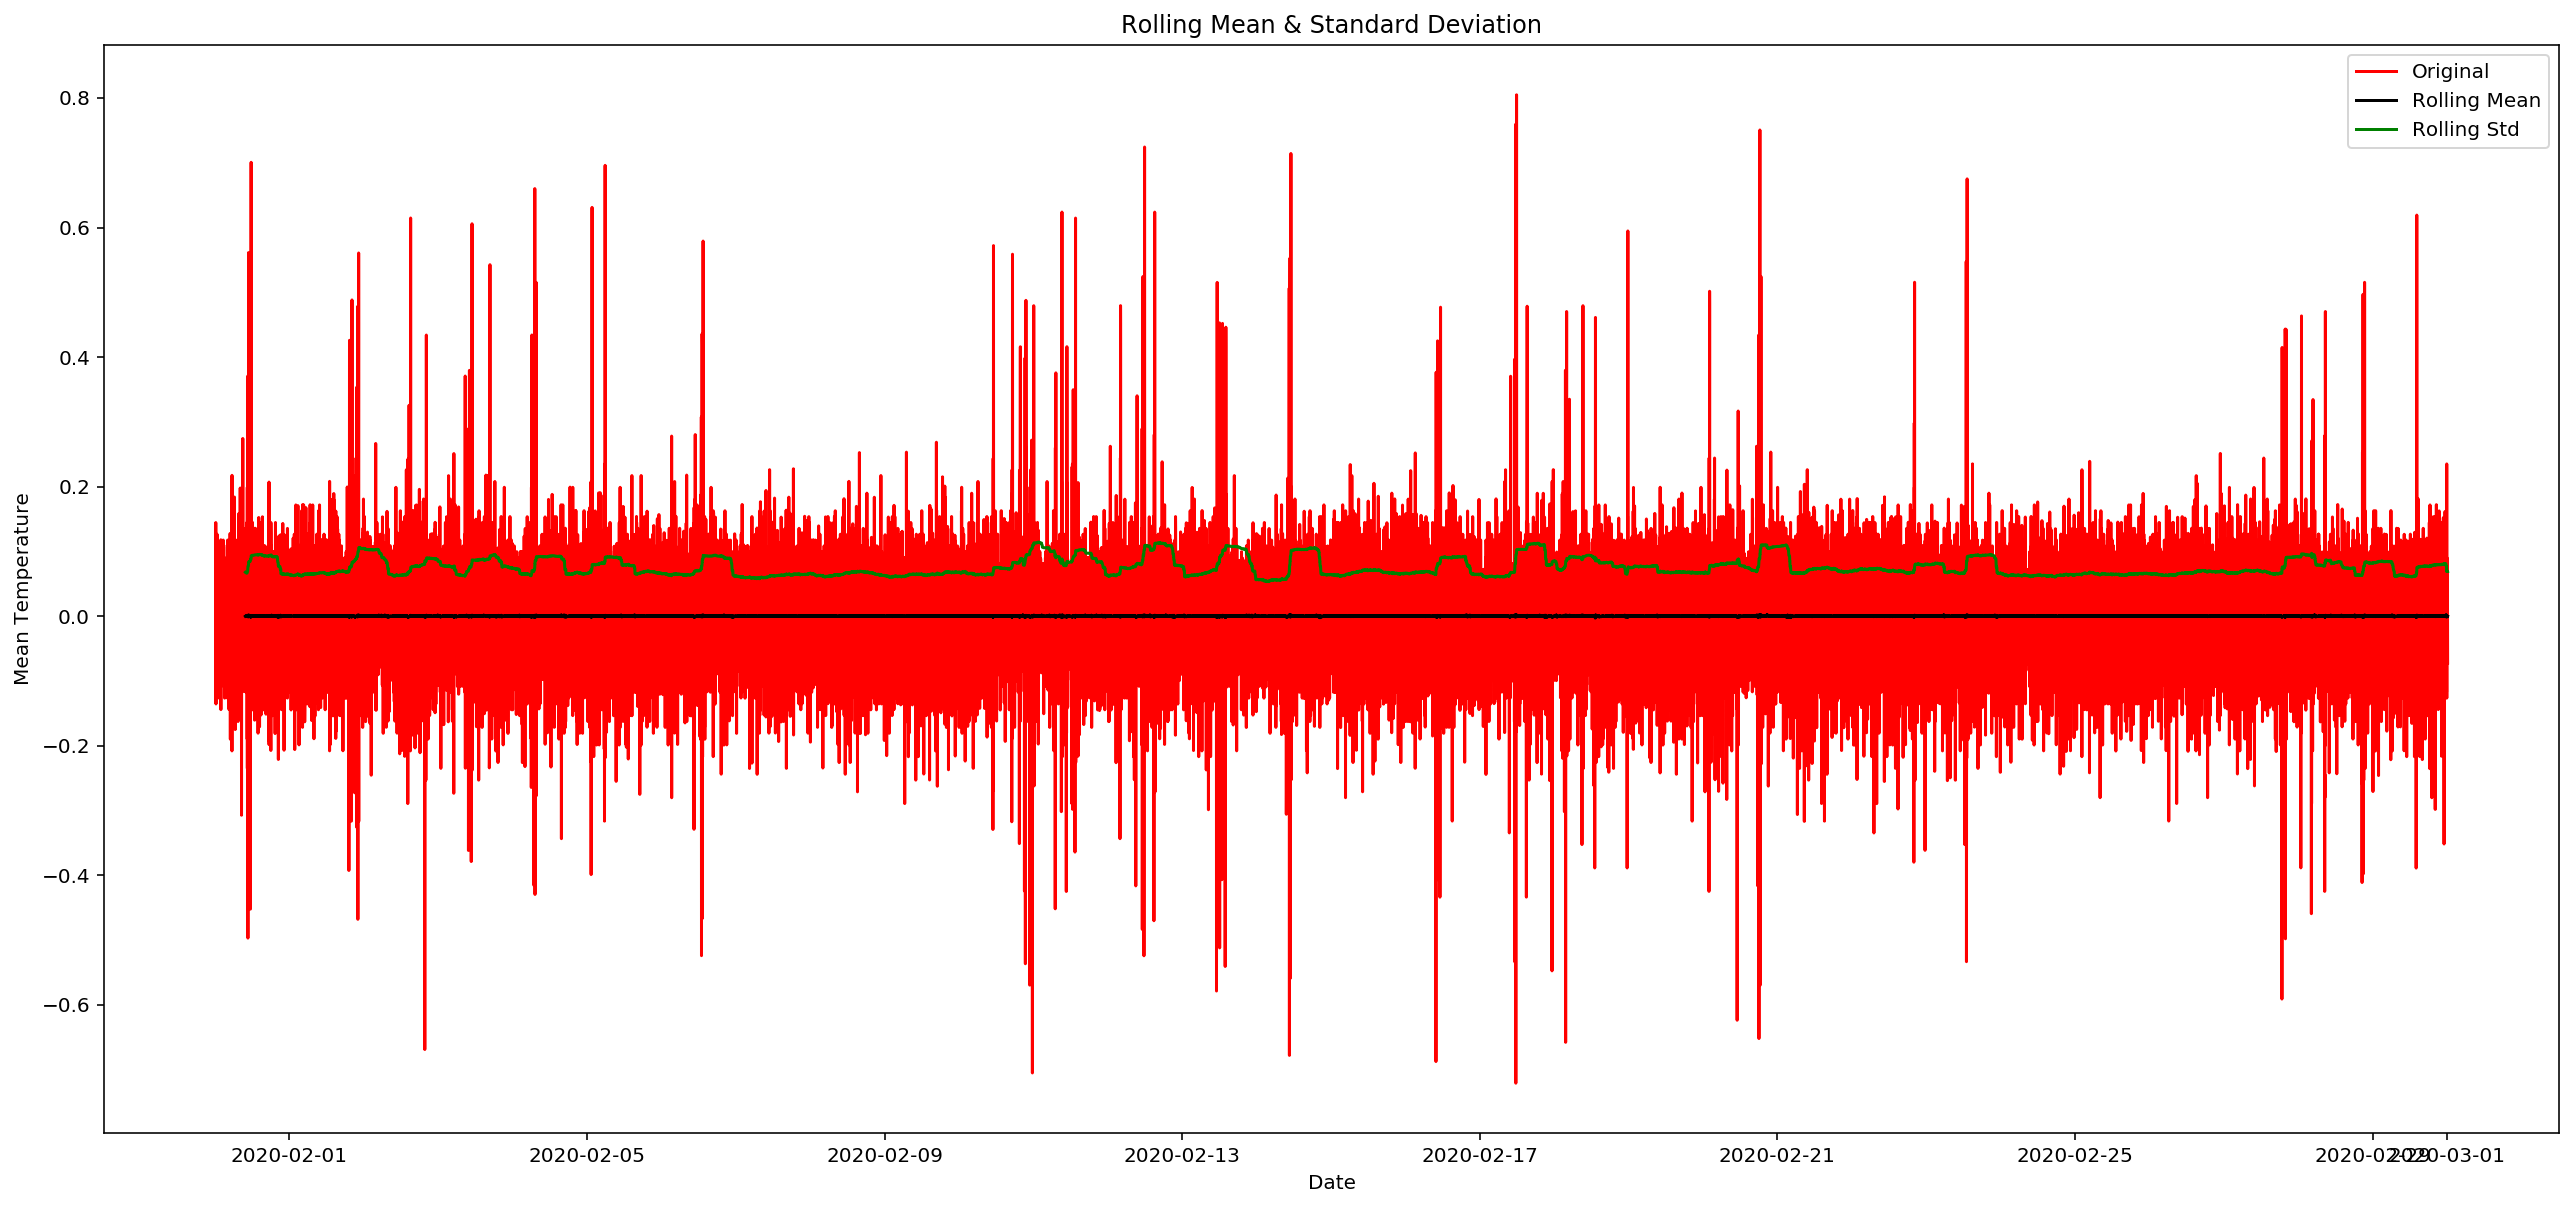

Test statistic:  -47.16507112057721
p-value:  0.0
Critical Values: {'1%': -3.430501588723926, '5%': -2.86160699886801, '10%': -2.566805661322456}


In [40]:
ts_2diff.dropna(inplace=True) # due to shifting there is nan values
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_2diff)
check_adfuller(ts_2diff)

## Предсказание временного ряда

### ARIMA

<div class = "alert alert-block alert-info">

Для прогнозирования буду использовать временные ряды `ts_diff`, являющиеся результатом метода дифференцирования. Нет причин, по которым я выбираю это, просто захотелось :)
    

Также метод прогнозирования - ARIMA, который является авторегрессионным интегрированным скользящим средним.
* <b>AR: AutoRegressive (p)</b>: термины AR - это просто лаги зависимой переменной. Например, допустим, что $p = 3$, тогда мы будем использовать $ x_{(t-1)}, x_{(t-2)} и x_{(t-3)}$ для прогнозирования $x_{(t)}$
* <b>I: Integrated (г)</b>: это количество несезонных различий. Например, в нашем случае мы берем разность первого порядка. Таким образом, мы передаем эту переменную и положить $d = 1$
* <b>MA: Moving Averages (q)</b>: члены MA представляют собой запаздывающие ошибки прогноза в уравнении прогнозирования.
    
> (p, d, q) - параметры модели ARIMA.
    
    
Чтобы выбрать параметры p, d, q, используется два разных графика:
* <b>Функция автокорреляции (ACF)</b>: измерение корреляции между временными рядами и версиями временных рядов с запаздыванием.
* <b>Функция частичной автокорреляции (PACF)</b>: она измеряет корреляцию между временными рядами и версиями временных рядов с запаздыванием, но после устранения изменений, уже объясненных промежуточными сравнениями.
    
</div>

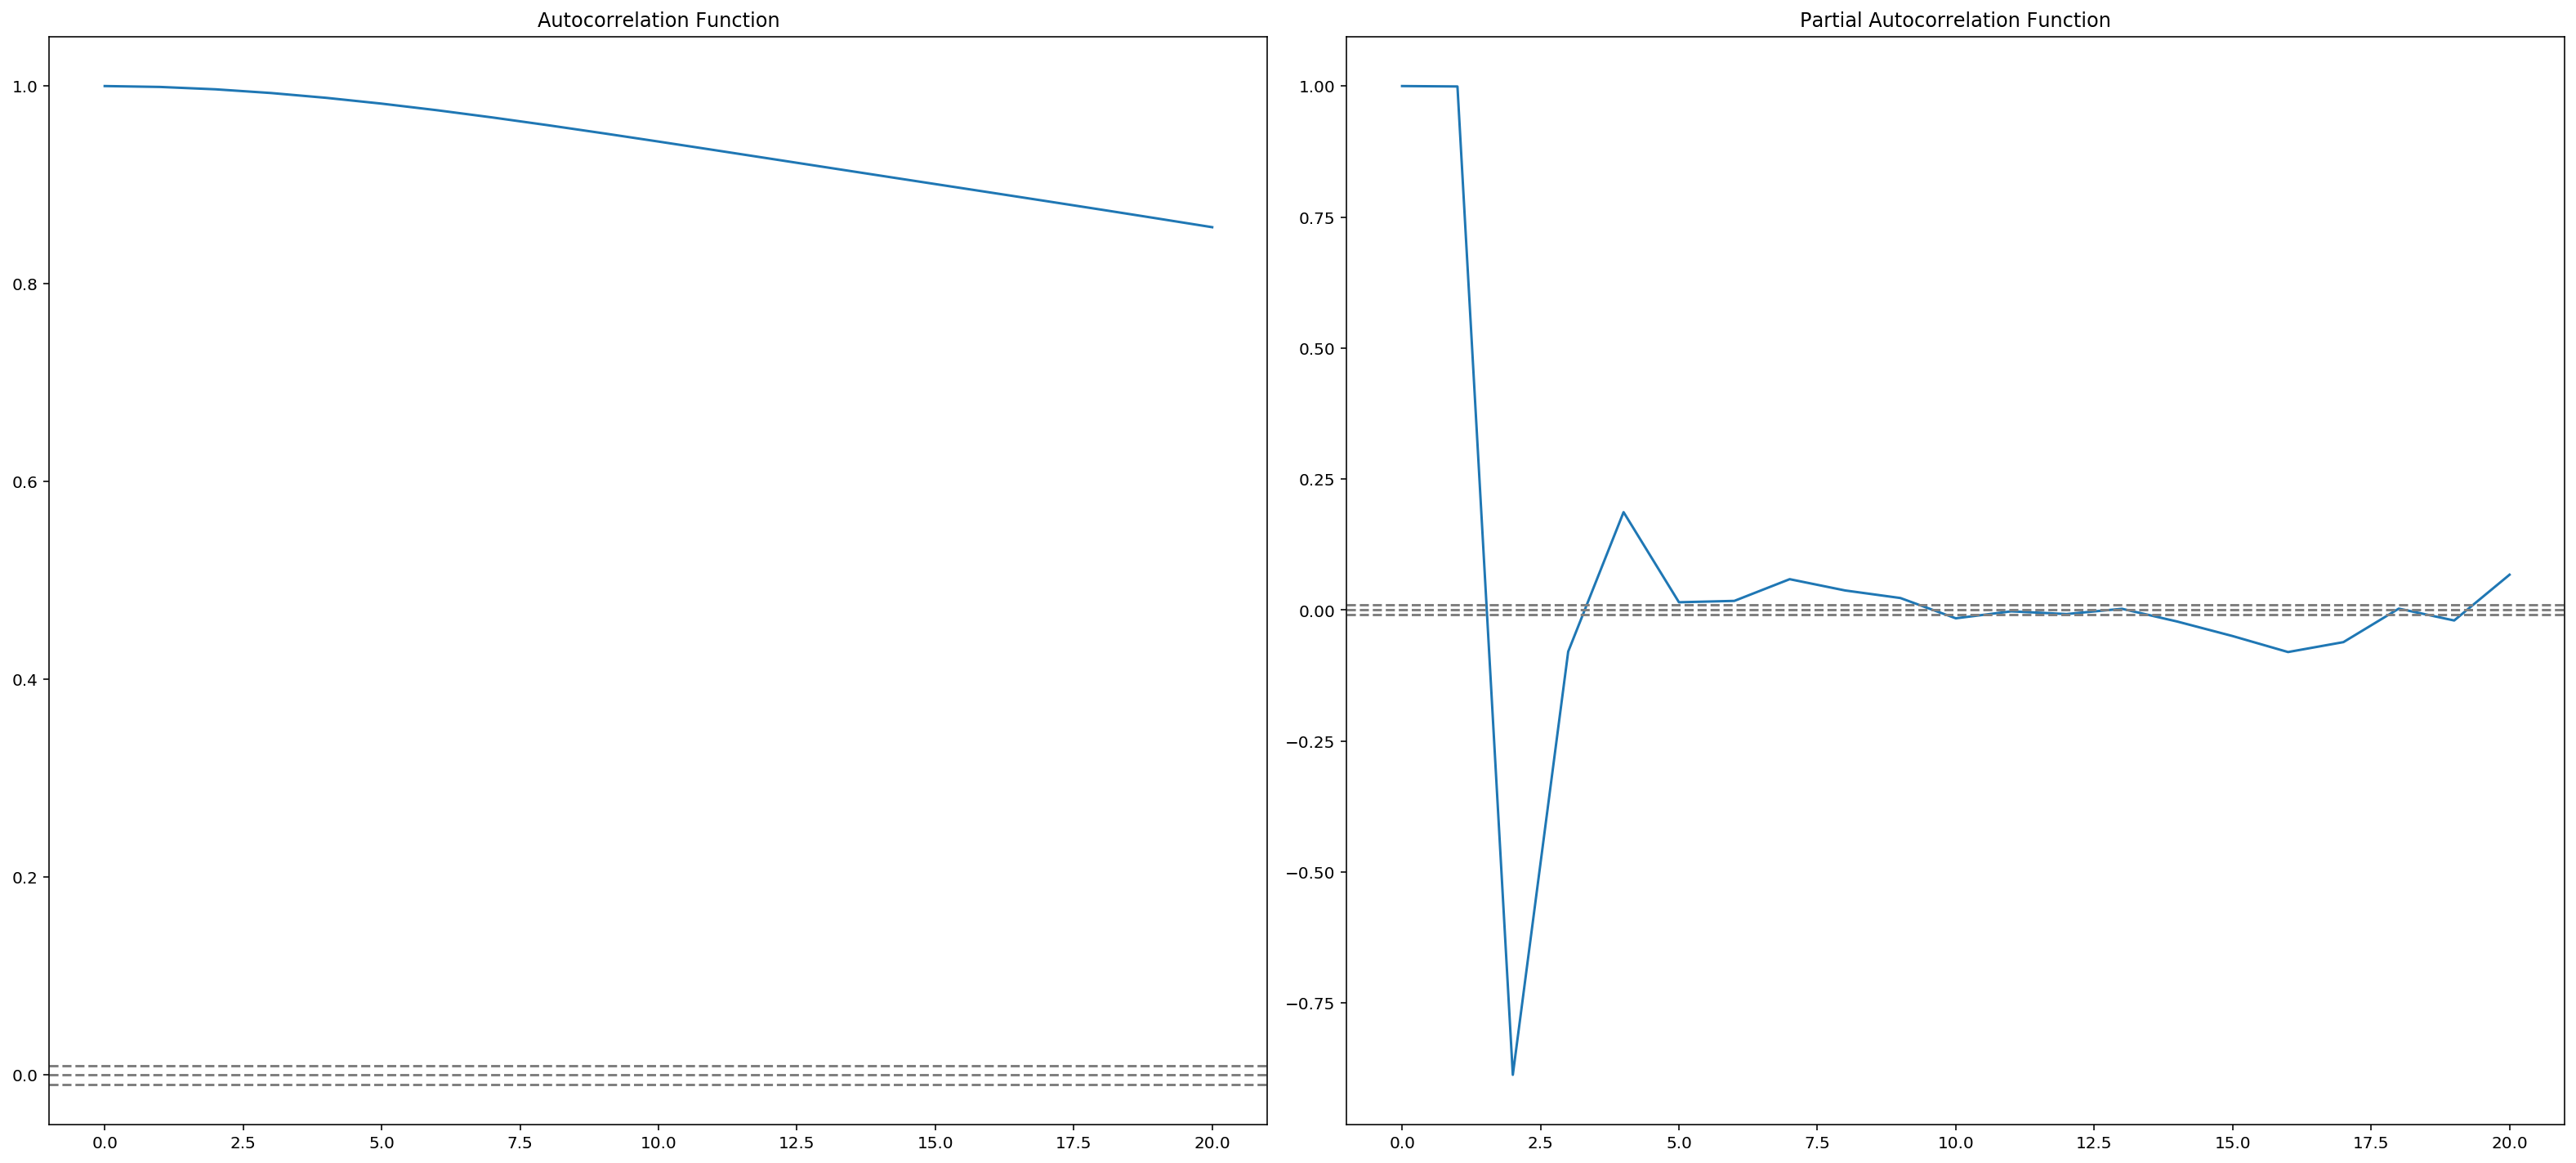

In [51]:
DAY_TS = ts["2020-02-01"]
DAY_TS_DIFF = DAY_TS.diff().dropna()
DAY_TS_2DIFF = DAY_TS_DIFF.diff().dropna()

# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(DAY_TS, nlags=20)
lag_pacf = pacf(DAY_TS, nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

<div class = "alert alert-block alert-info">

Две пунктирные линии - доверительные интервалы. Используем эти строки для определения значений "p" и "q"
> <b>Выбор p</b>: значение лага, когда диаграмма PACF впервые пересекает верхний доверительный интервал. $р = 1$

> <b>Выбор q</b>: значение лага, при котором график ACF впервые пересекает верхний доверительный интервал. $q = 1$

Используем `(p,d,q) = (1,0,1)` в качестве параметров моделей ARIMA и прогнозируем 
(ARIMA: из библиотеки `statsmodels`)
    
</div>

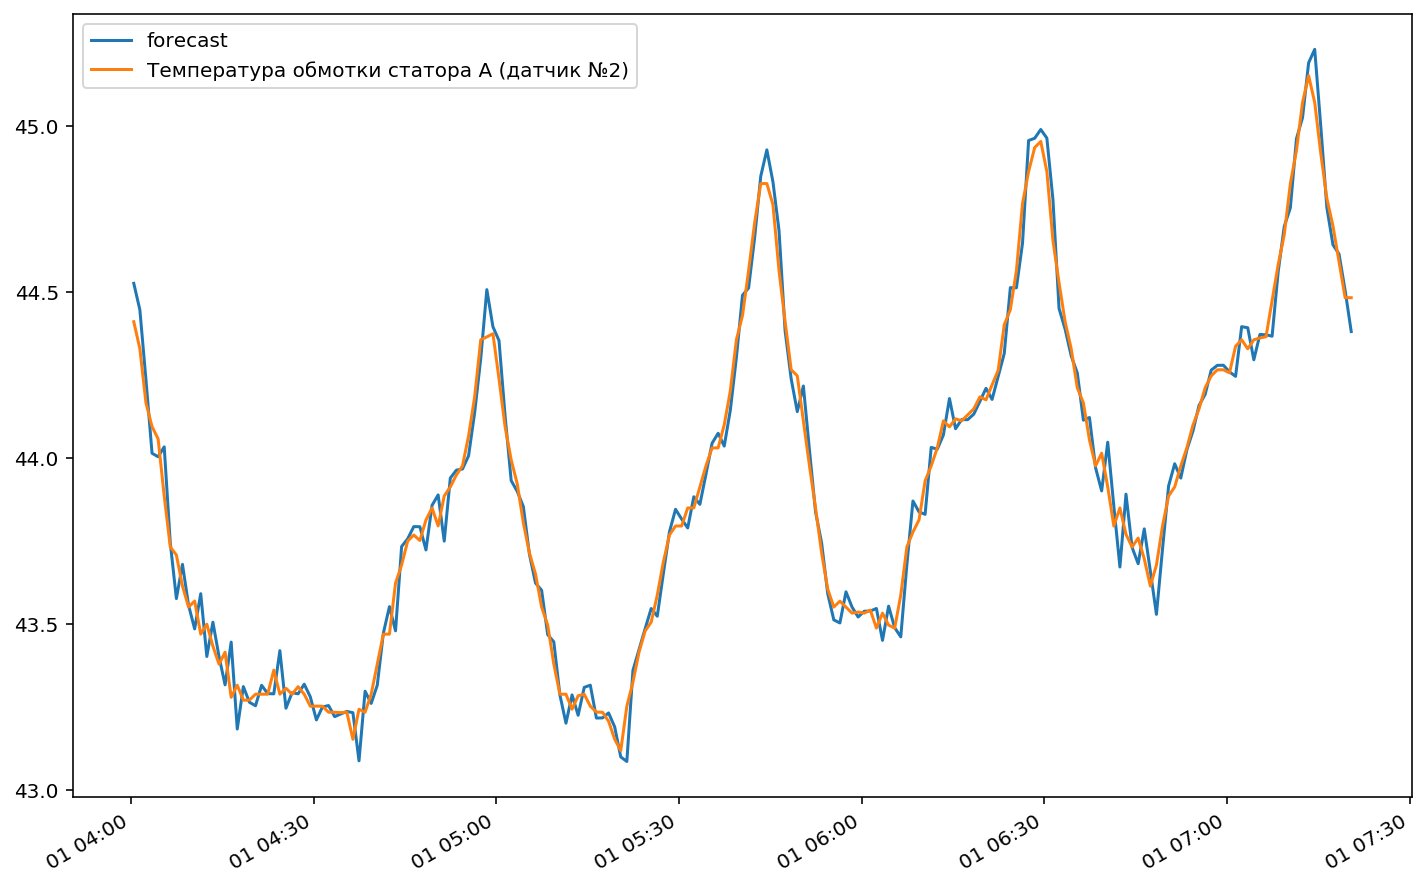

In [86]:
# ARIMA LİBRARY
from statsmodels.tsa.arima_model import ARIMA, ARMA
from pandas import datetime

# fit model
model = ARIMA(DAY_TS, order=(4,2,4))
model_fit = model.fit(disp=0)

# predict
start_index = ts["2020-02-01"].index[-1200]
end_index = ts["2020-02-01"].index[-1000]

preds = model_fit.predict(start=start_index, end=end_index)

fig, ax = plt.subplots(figsize=(12,8))
model_fit.plot_predict(start_index, end_index, dynamic=False, plot_insample=True, ax=ax)
# ax.plot(np.cumsum(np.cumsum(preds)))
# ax.plot(ts[start_index:end_index])
plt.show()

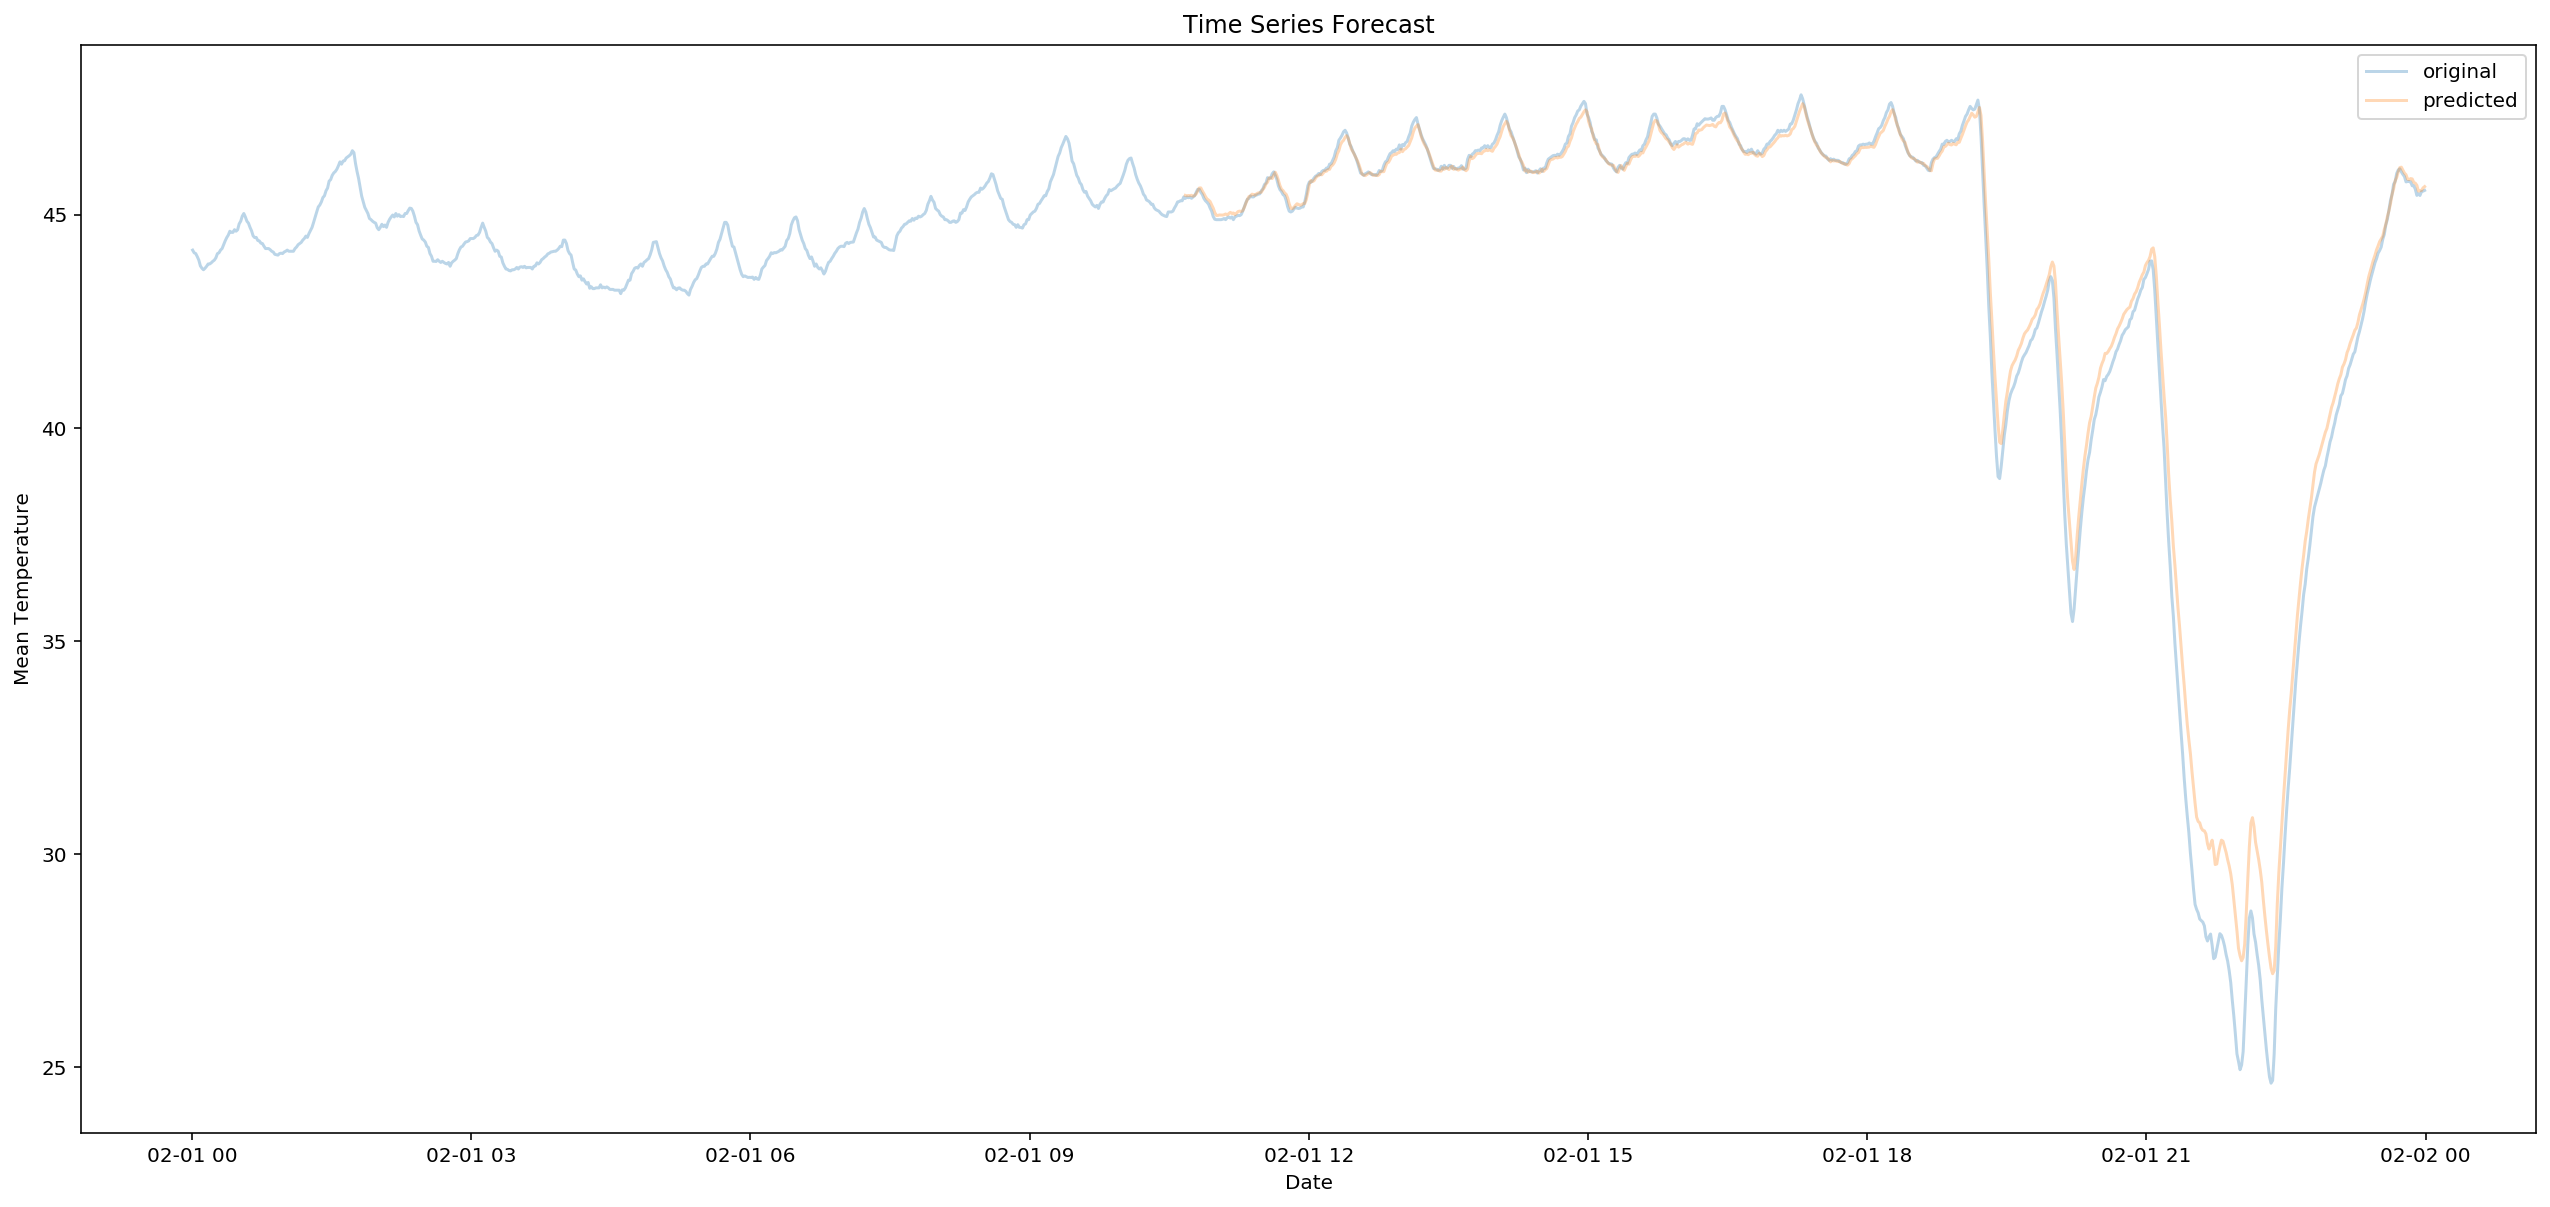

In [626]:
# visualization
plt.figure(figsize=(22,10))
plt.plot(ts["2020-02-01"].index, ts["2020-02-01"].values, label = "original", alpha=0.3)
# plt.plot(DAY_TS_2DIFF)
plt.plot(Init_Preds,label = "predicted", alpha=0.3)
# plt.plot(forecast[0], label="forecast", alpha=0.5, c='r')

plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

predicted=46.854030, expected=46.878600
predicted=46.738450, expected=46.752000



KeyboardInterrupt: 

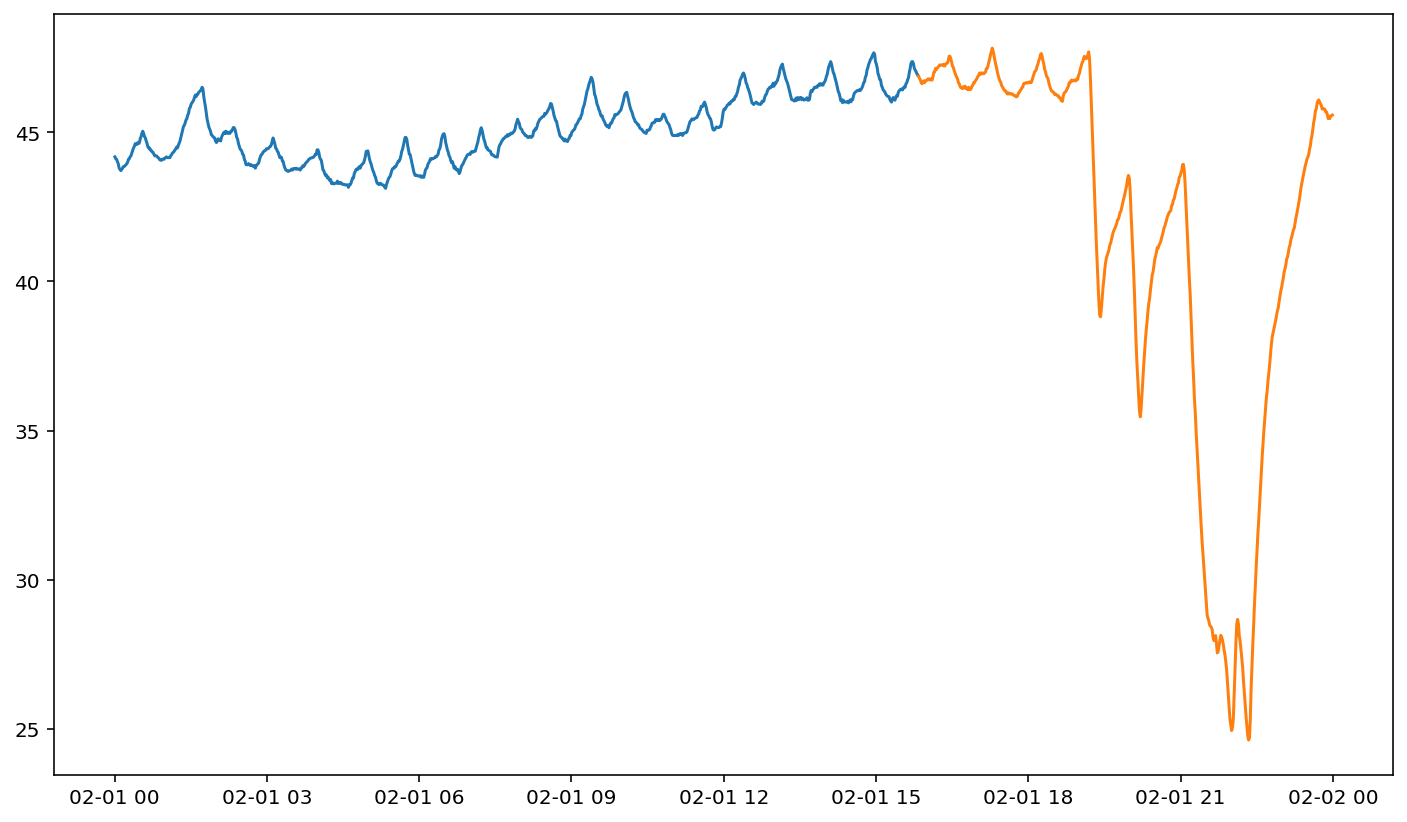

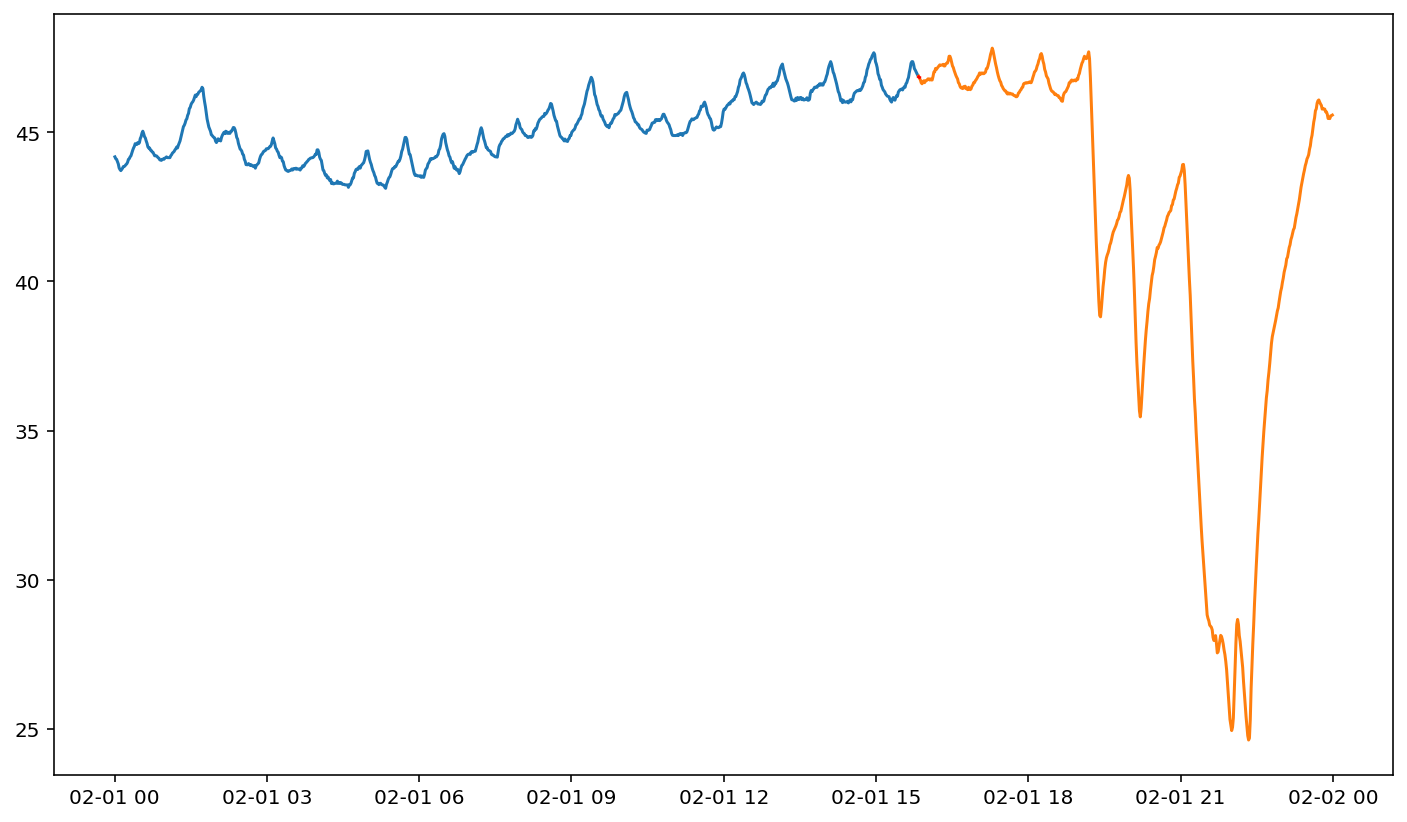

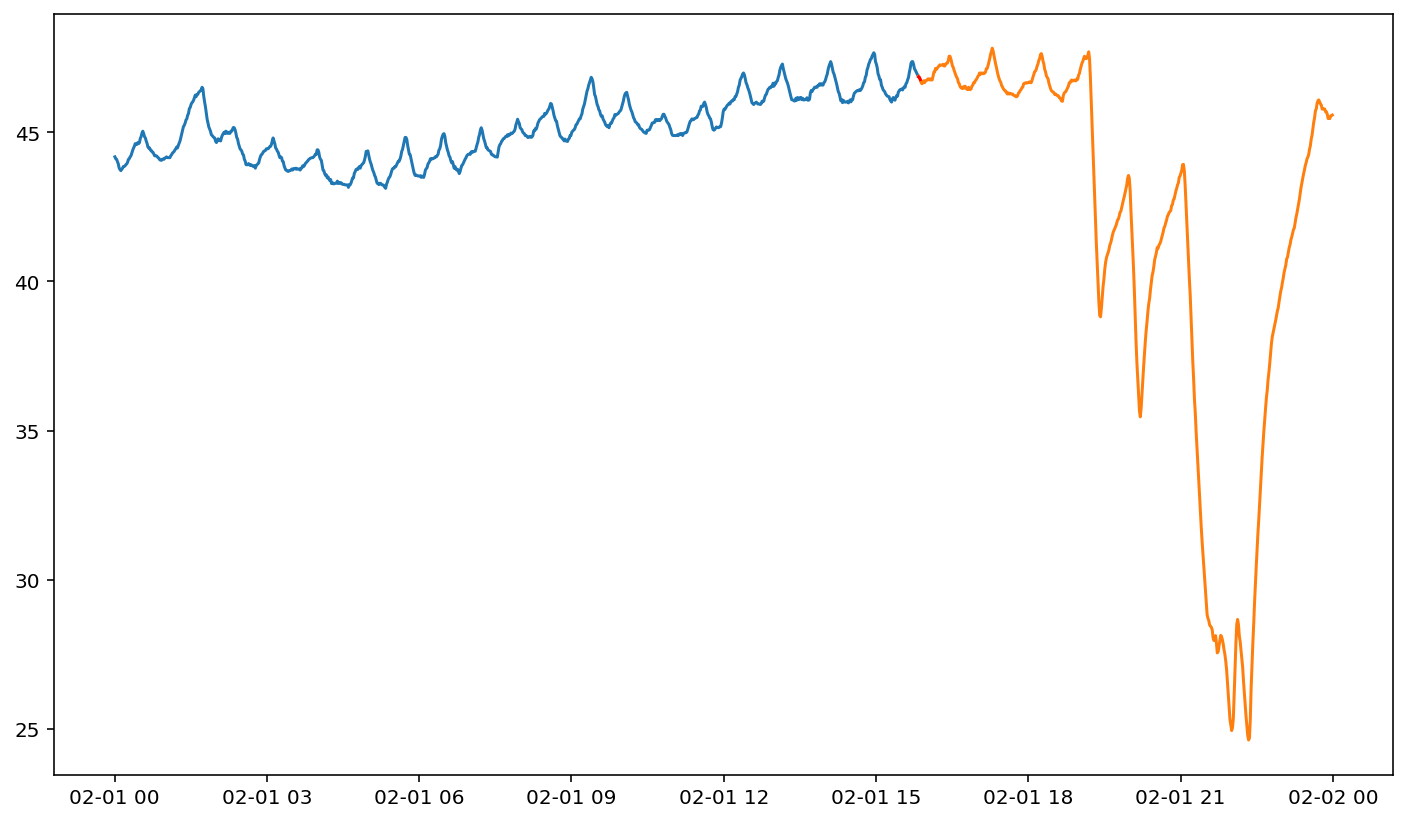

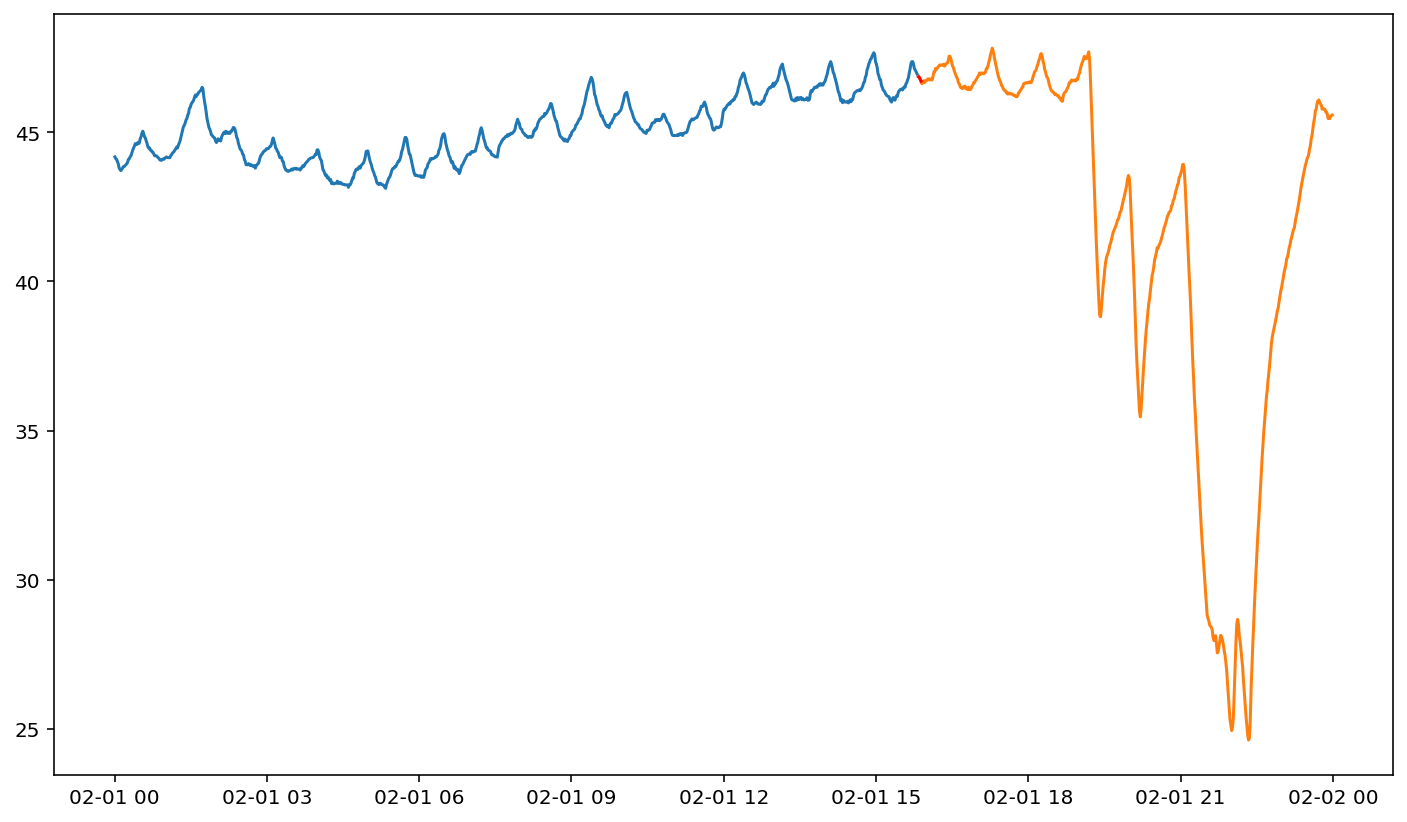

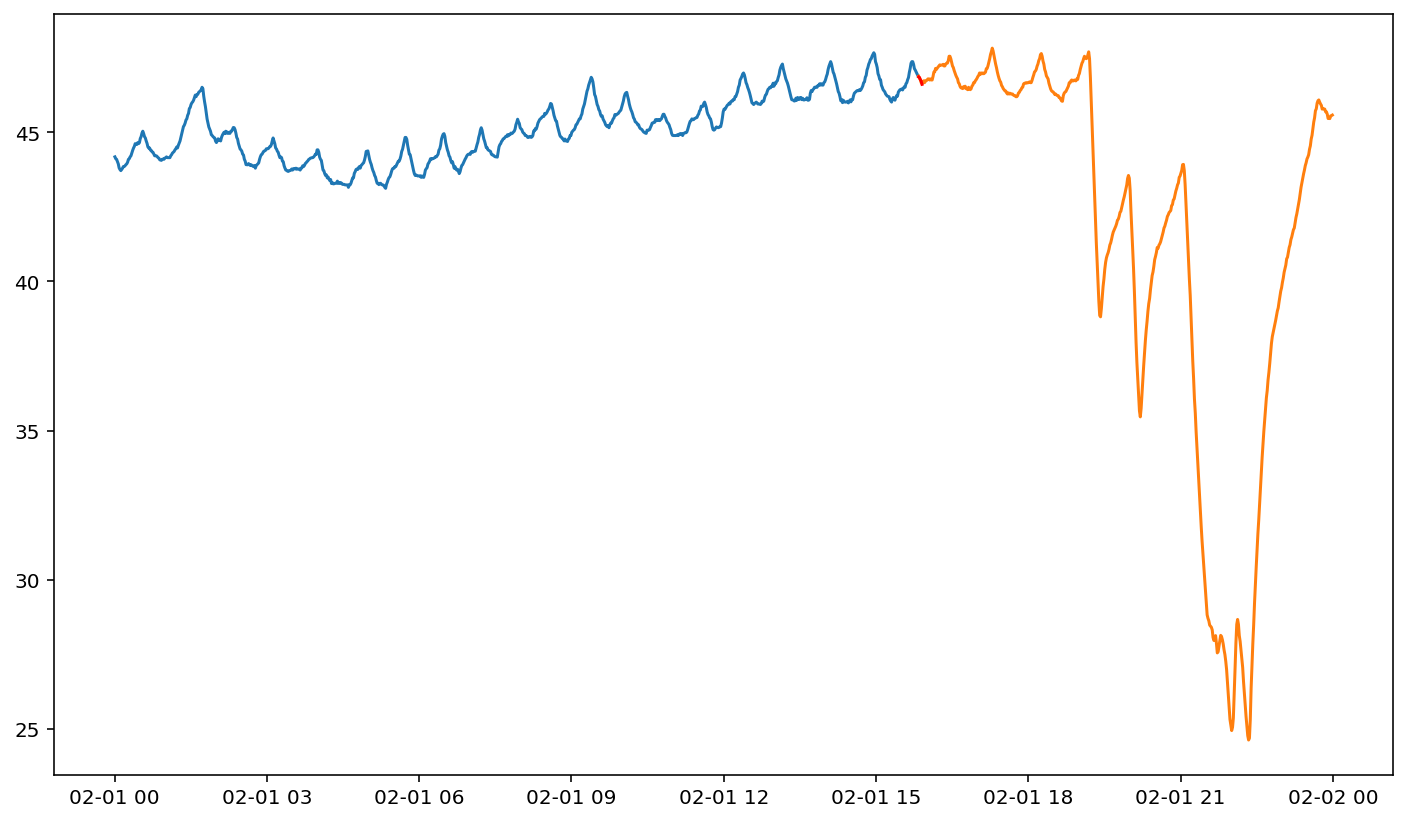

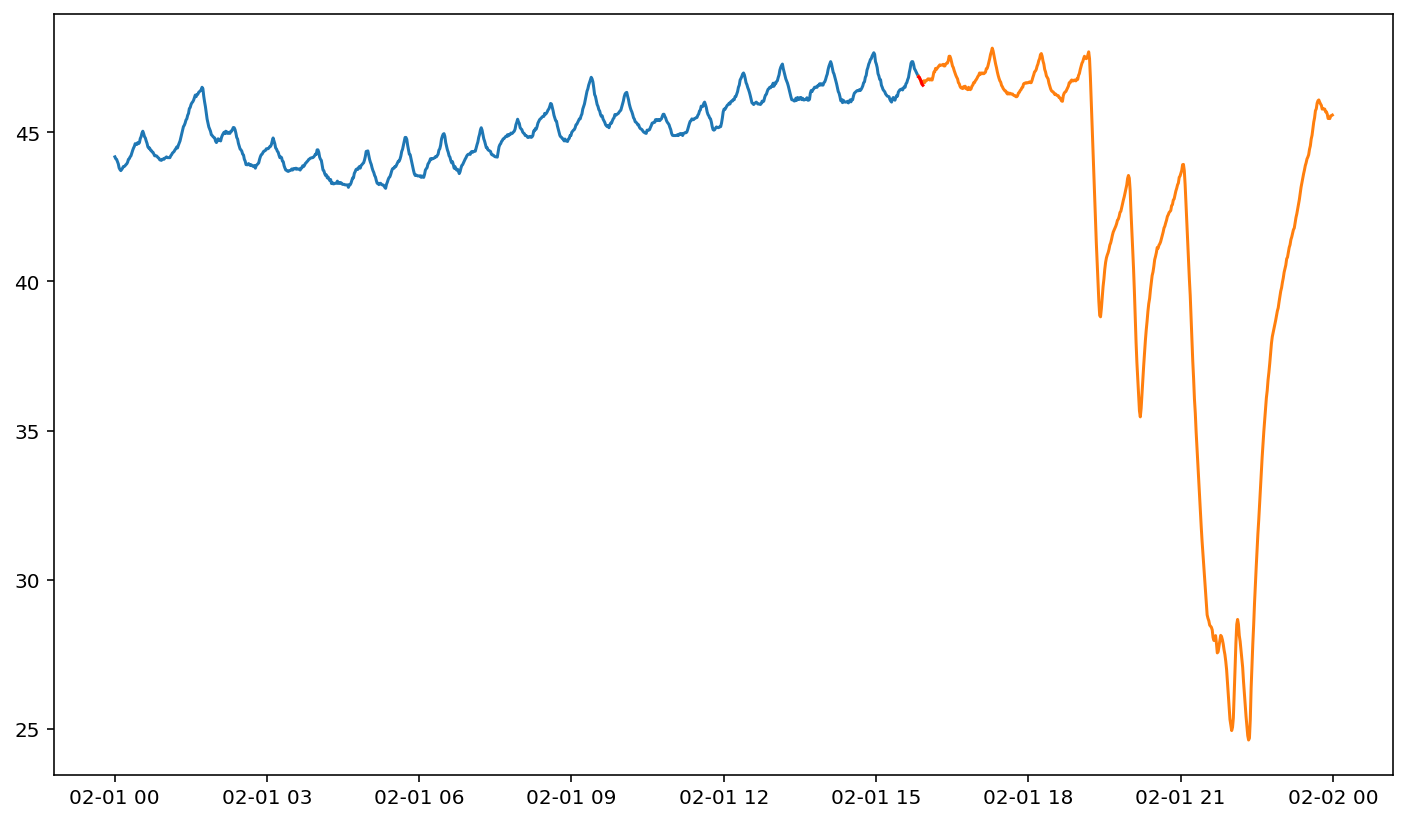

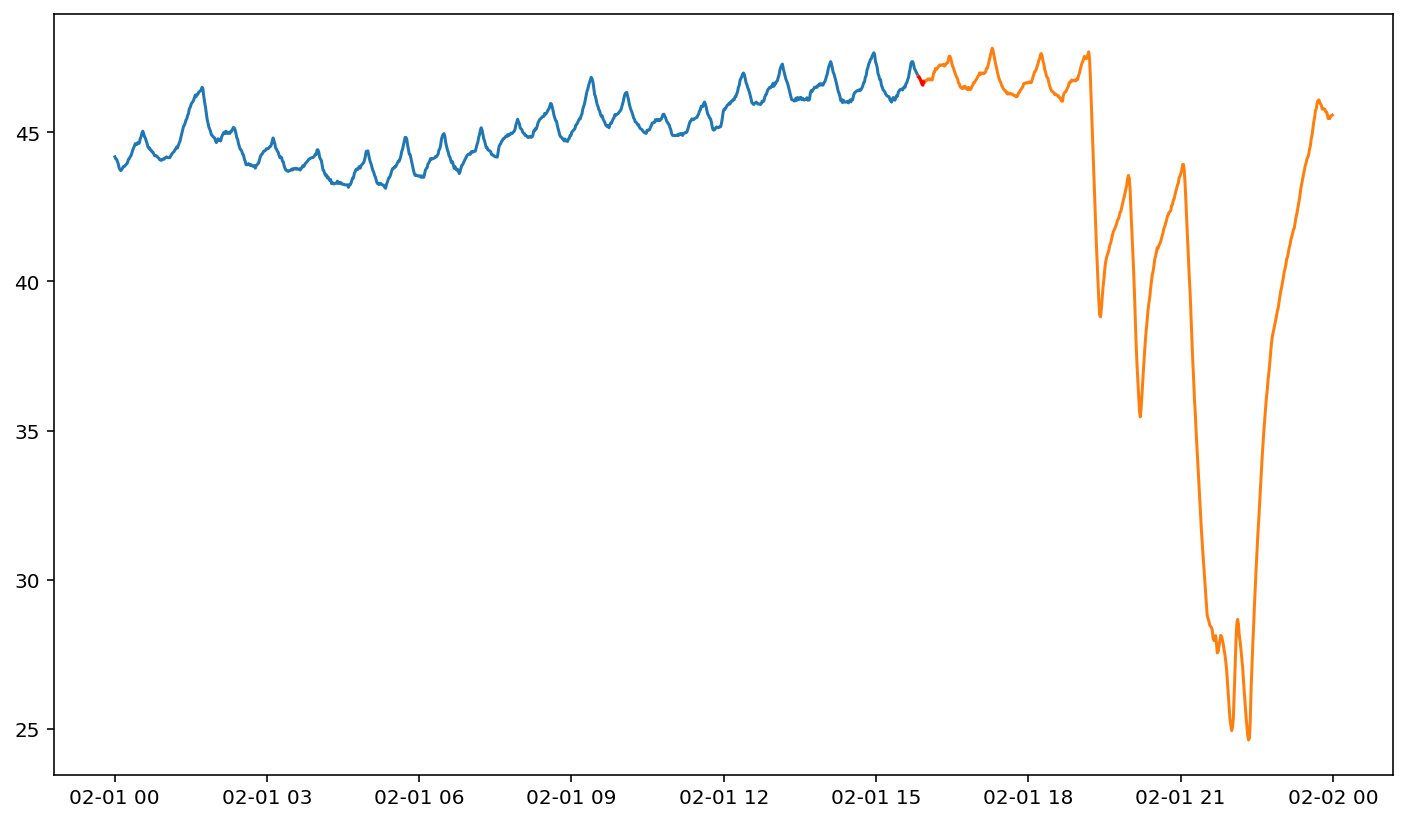

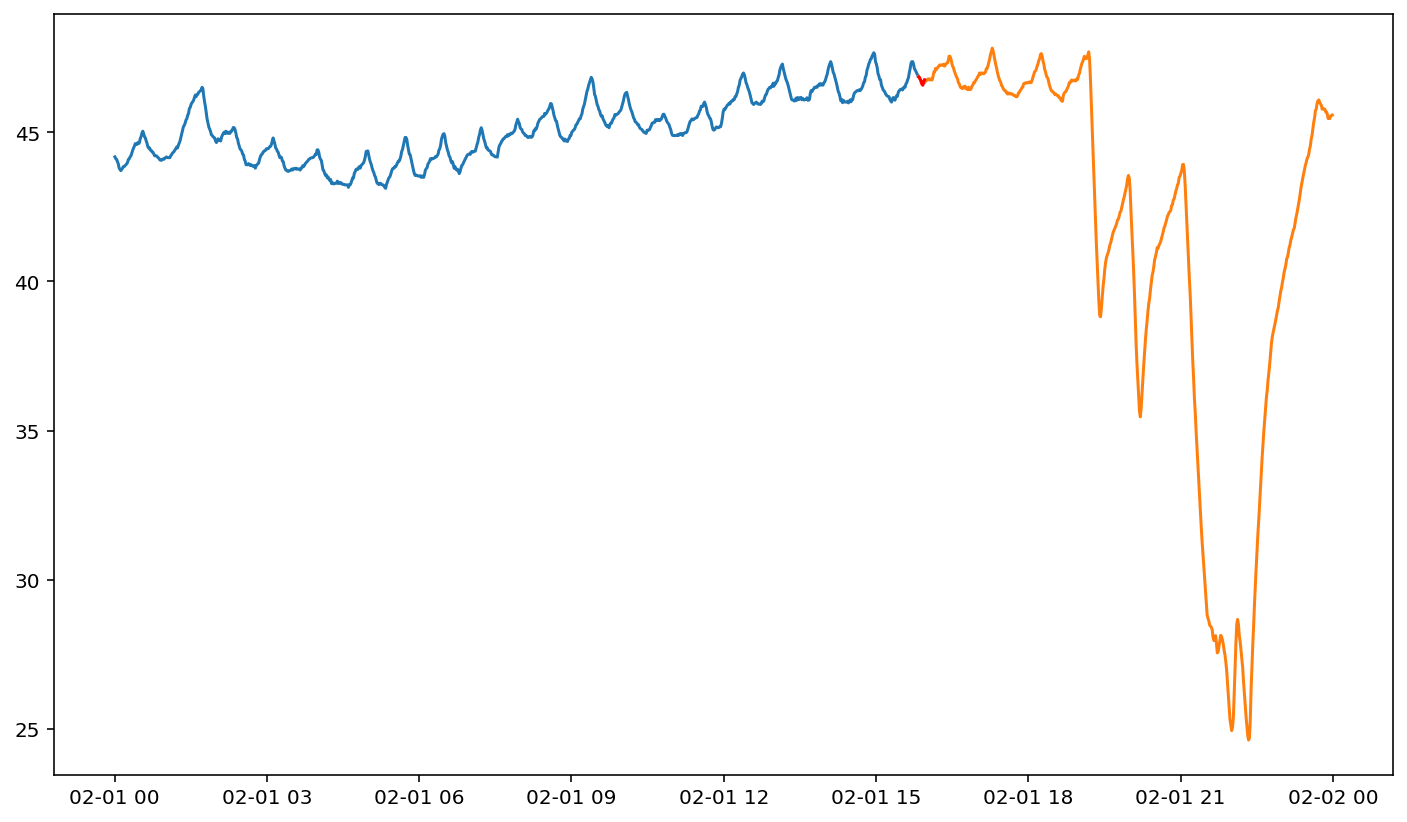

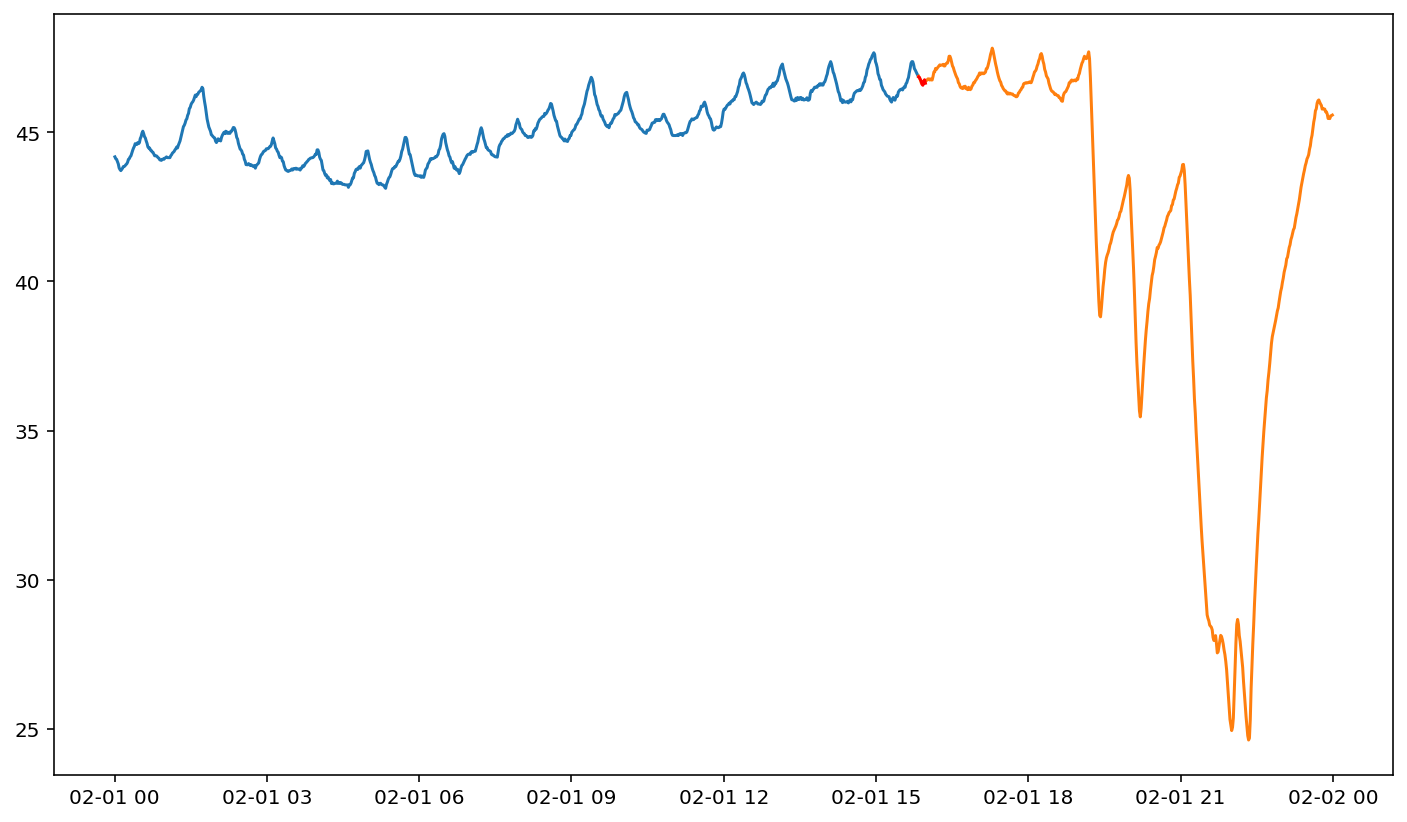

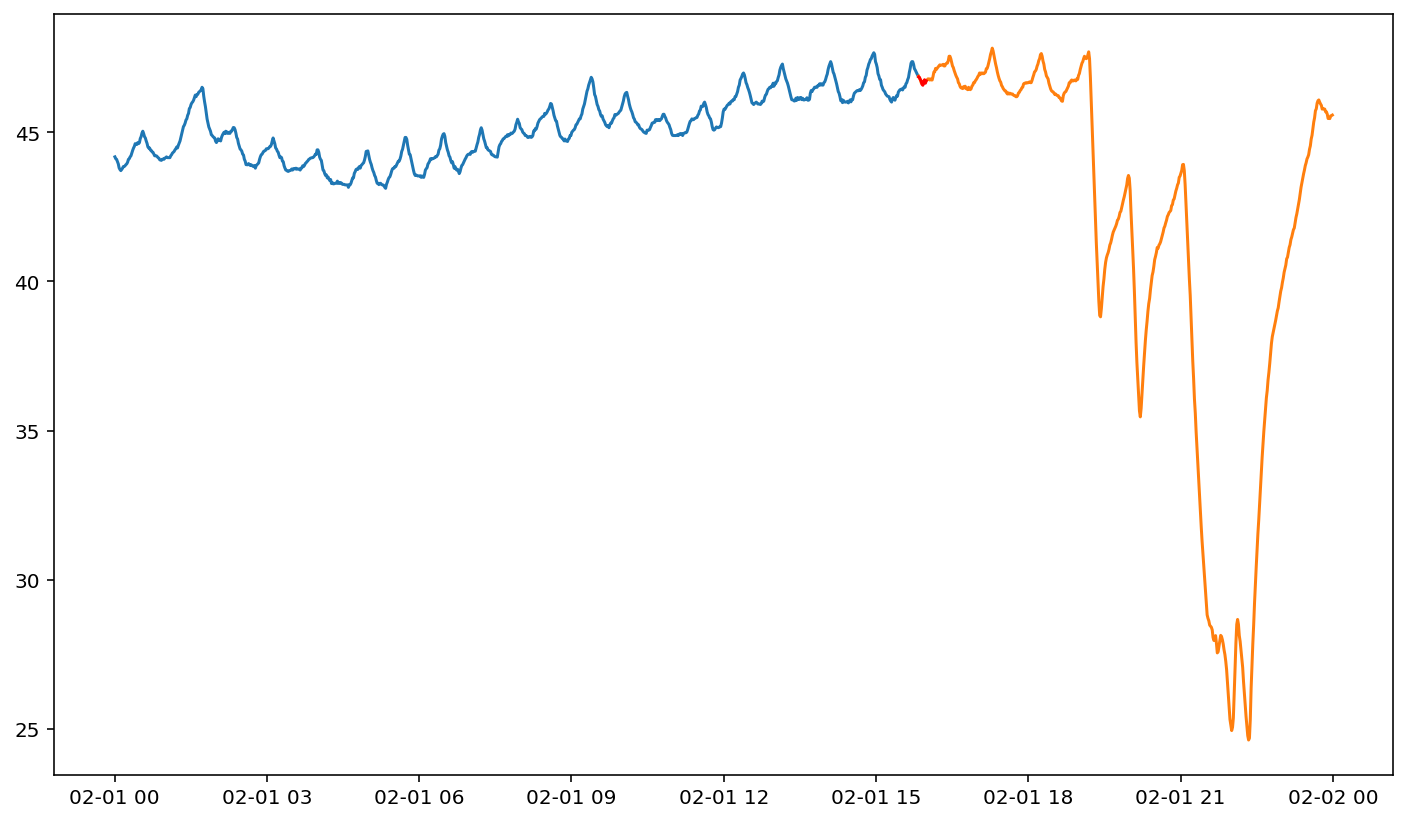

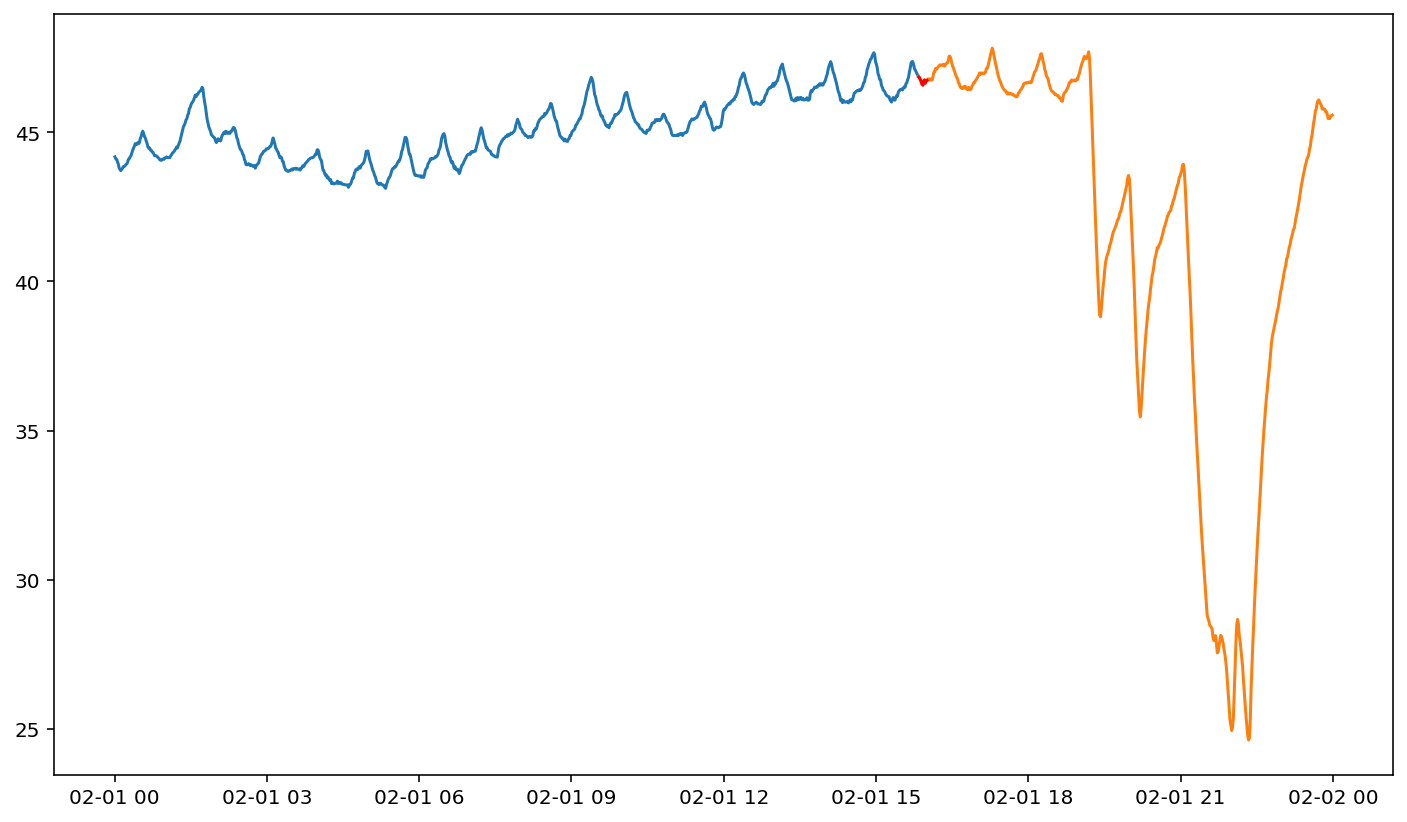

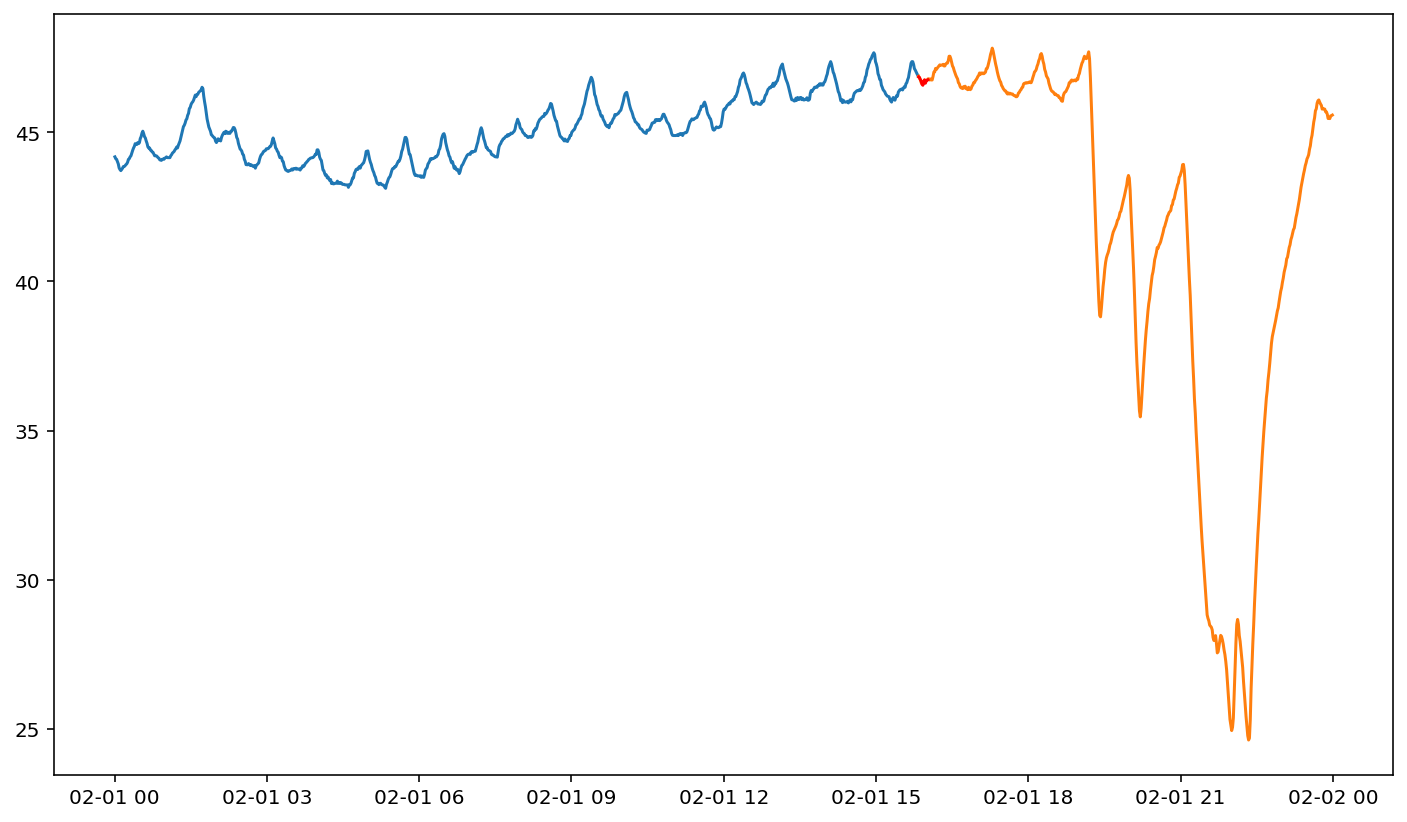

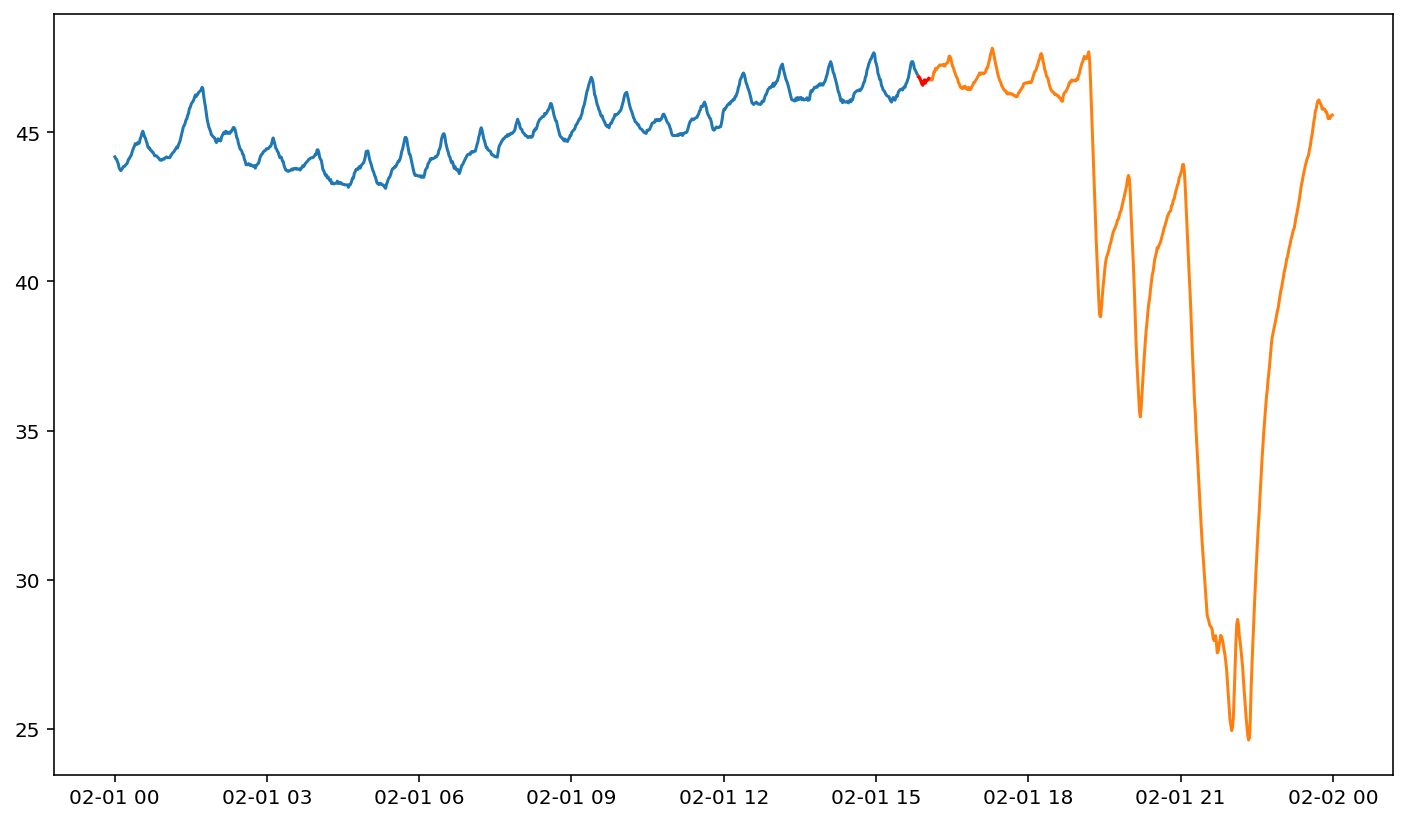

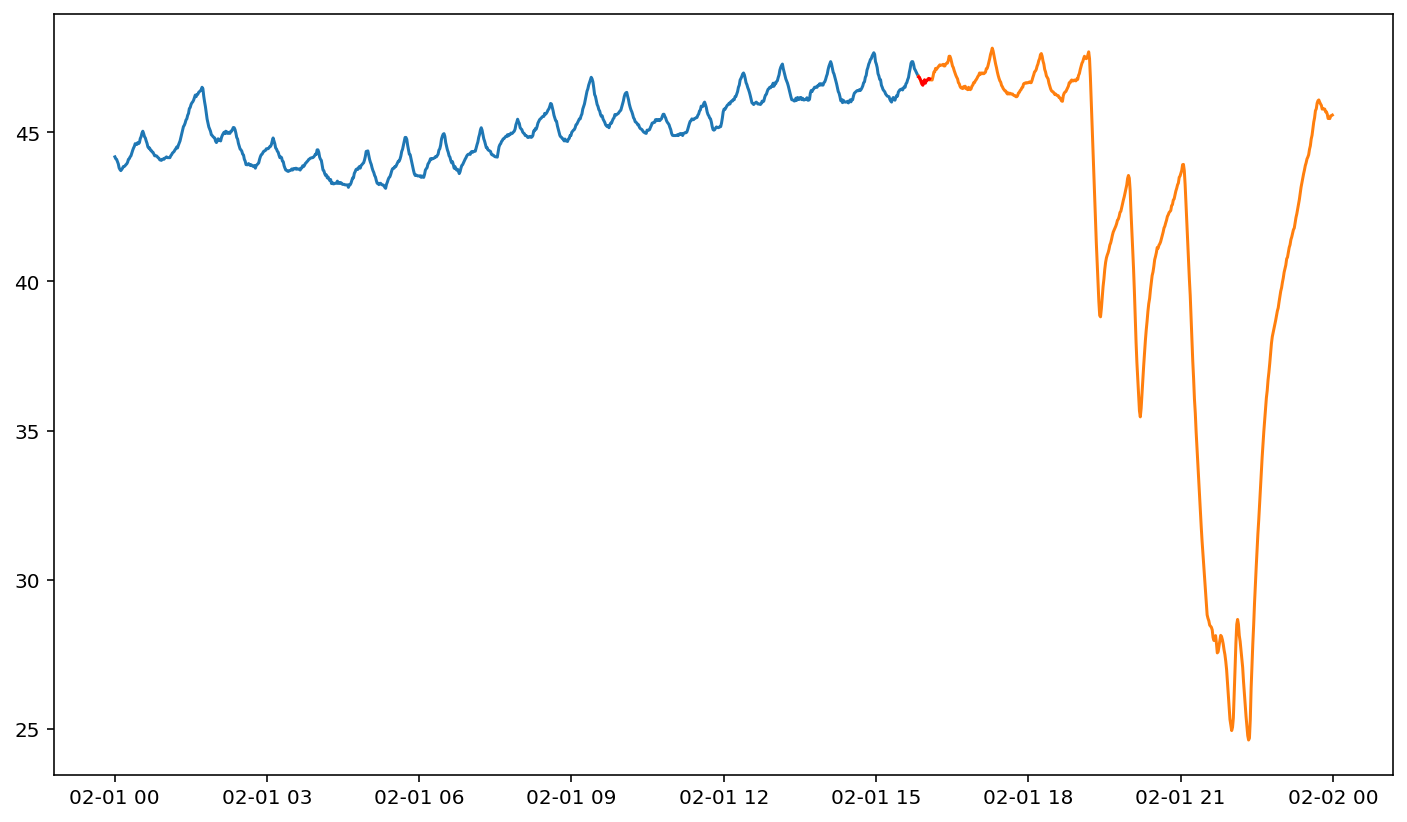

In [496]:
from tqdm.notebook import tqdm

X = ts["2020-02-01"]
train_size = int(X.shape[0] * 0.66)
X_train, X_test = X[:train_size], X[train_size:]
history = [x for x in X_train]
preds = []

for i,t in tqdm(enumerate(X_test.index), total=len(X_test)):
    model = ARIMA(history, order=(2,0,11))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = X_test[t]
    history.append(obs)
    if i%10 == 0:
        print('predicted=%f, expected=%f' % (yhat, obs))
    
    fig, ax = plt.subplots(figsize=(12,7))
    
    Train_line = ax.plot(X_train.index, X_train.values)
    Test_line = ax.plot(X_test.index, X_test.values)
    Pred_line = ax.plot(X_test.index[:i+1], preds, color='red')
    
    plt.savefig(f"./test_gif/{i}_frame.png")
#     plt.show()

    
error = mean_squared_error(X_test, preds)
print('Test MSE: %.3f' % error)

In [492]:
import os
from PIL import Image

images = []
for img_name in sorted(os.listdir("./test_gif")):
    img = Image.open(f"./test_gif/{img_name}")
    images.append(img)
images[0].save('test_gif.gif', save_all=True, append_images=images[1:], optimize=True, duration=40, loop=0)

predicted=46.864995, expected=46.878600
predicted=46.934934, expected=46.752000
predicted=46.940238, expected=47.140800
predicted=46.939546, expected=47.222900
predicted=46.939309, expected=47.222200
predicted=46.939359, expected=46.489800
predicted=46.939442, expected=46.453600
predicted=46.939507, expected=46.869600
predicted=46.939578, expected=47.131100
predicted=46.939656, expected=47.430200
predicted=46.939766, expected=46.462700
predicted=46.939789, expected=46.281800
predicted=46.939878, expected=46.399000
predicted=46.939865, expected=46.661600



ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

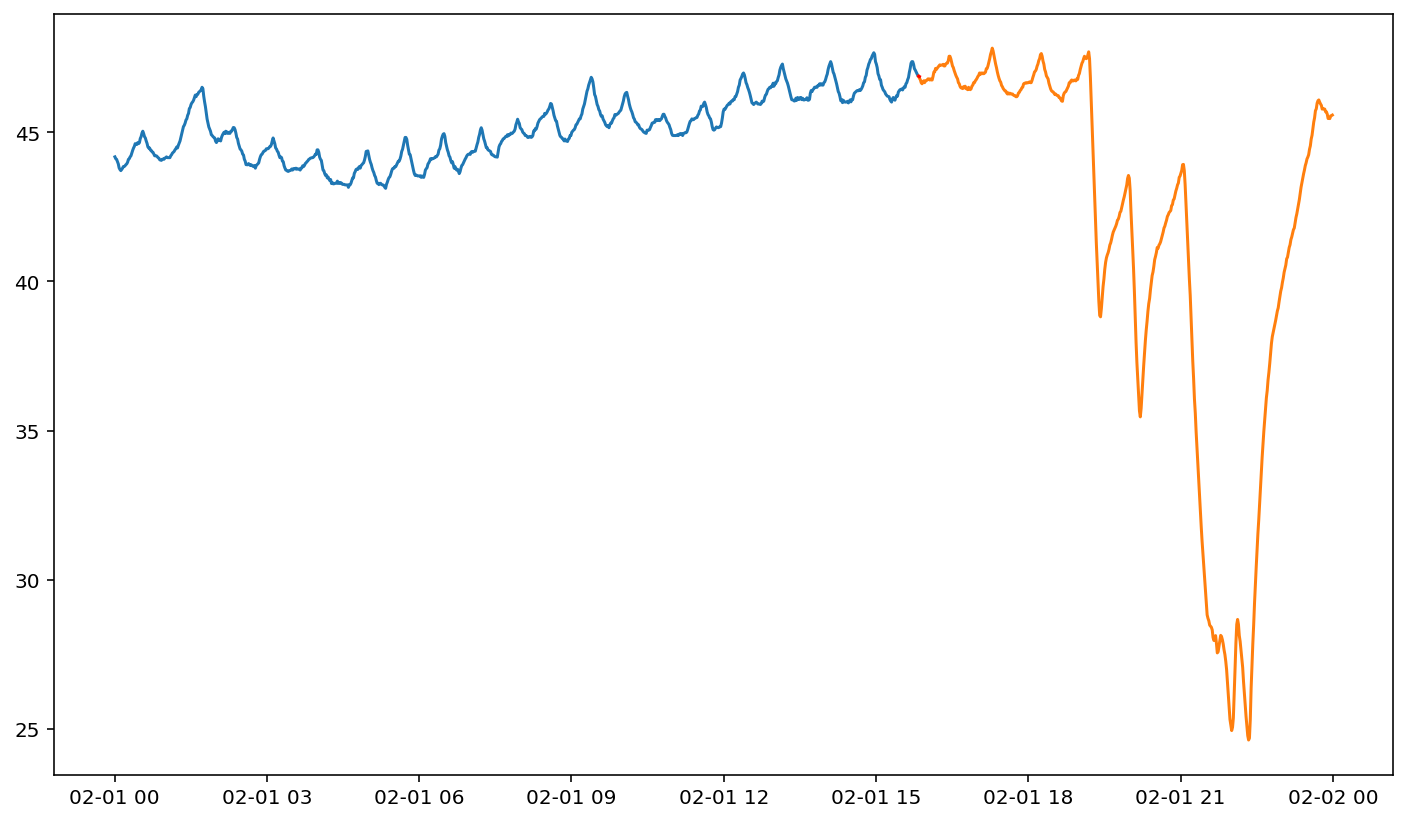

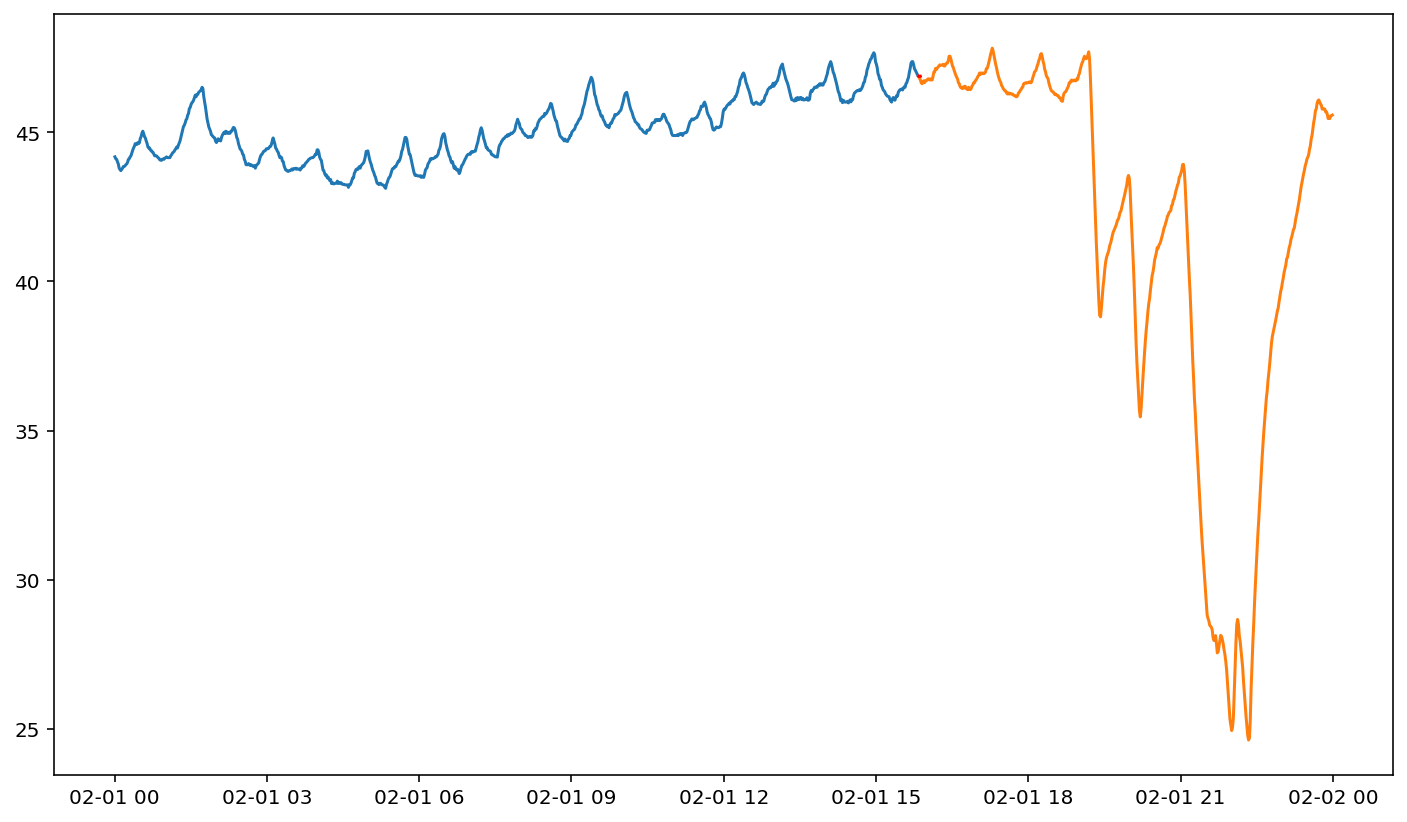

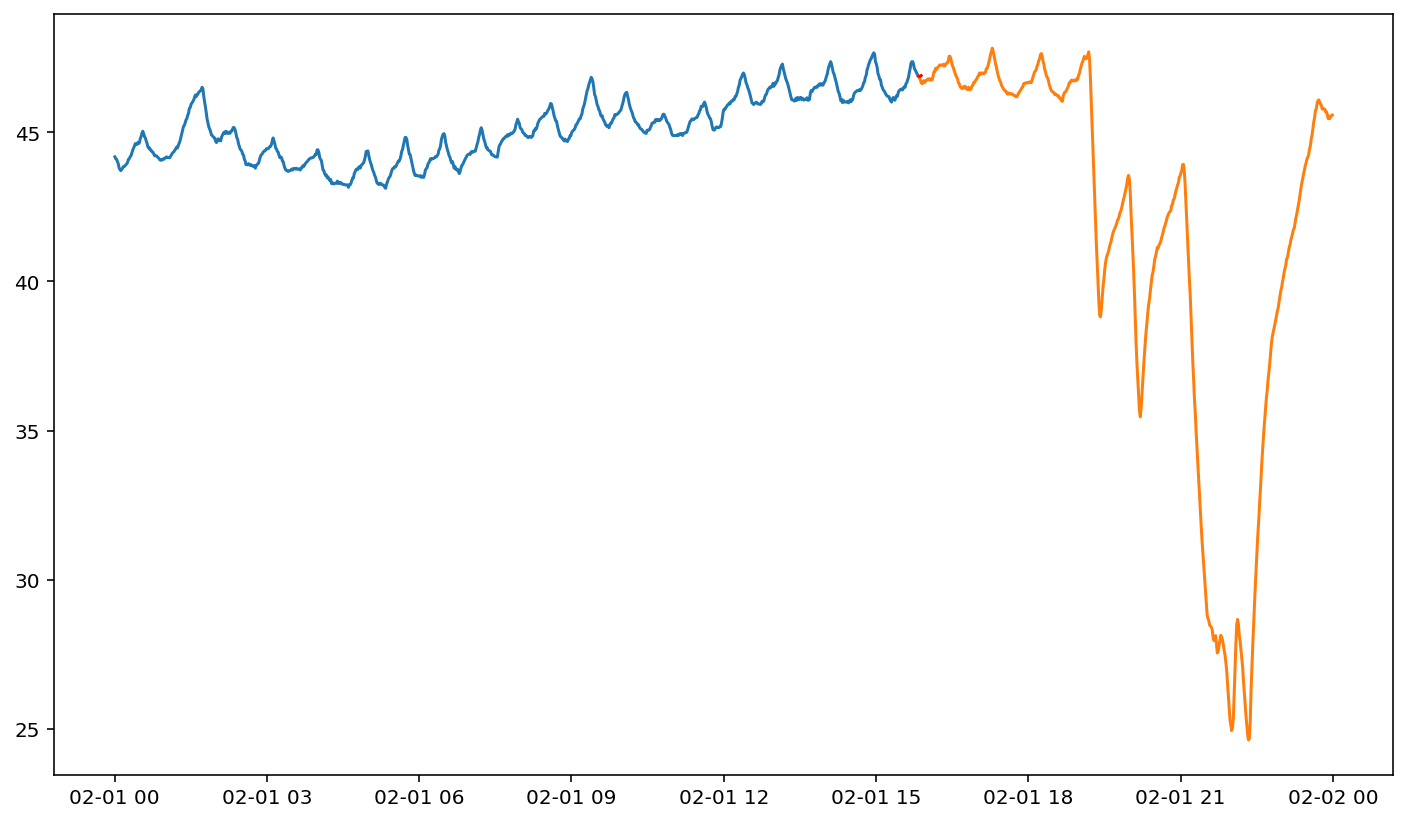

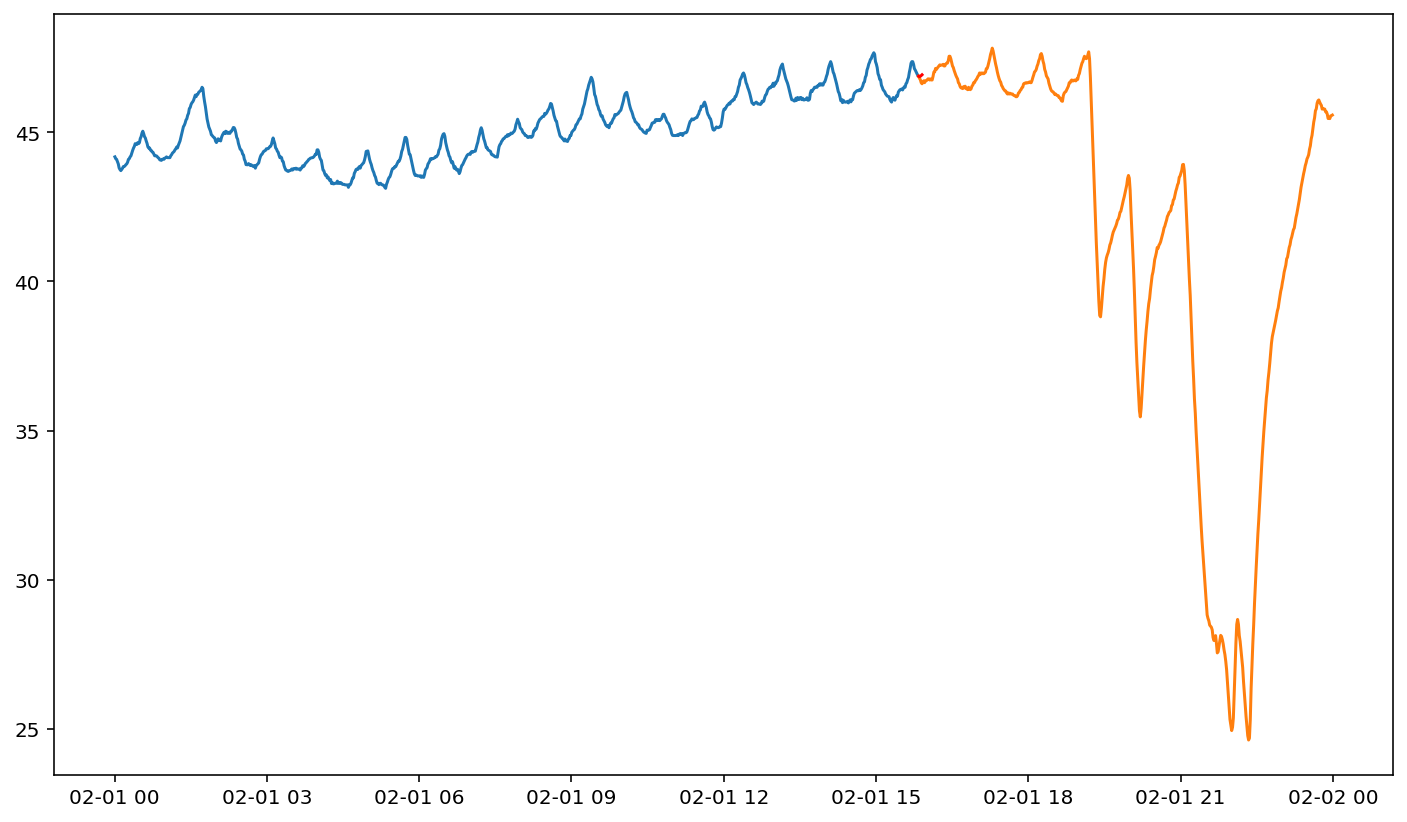

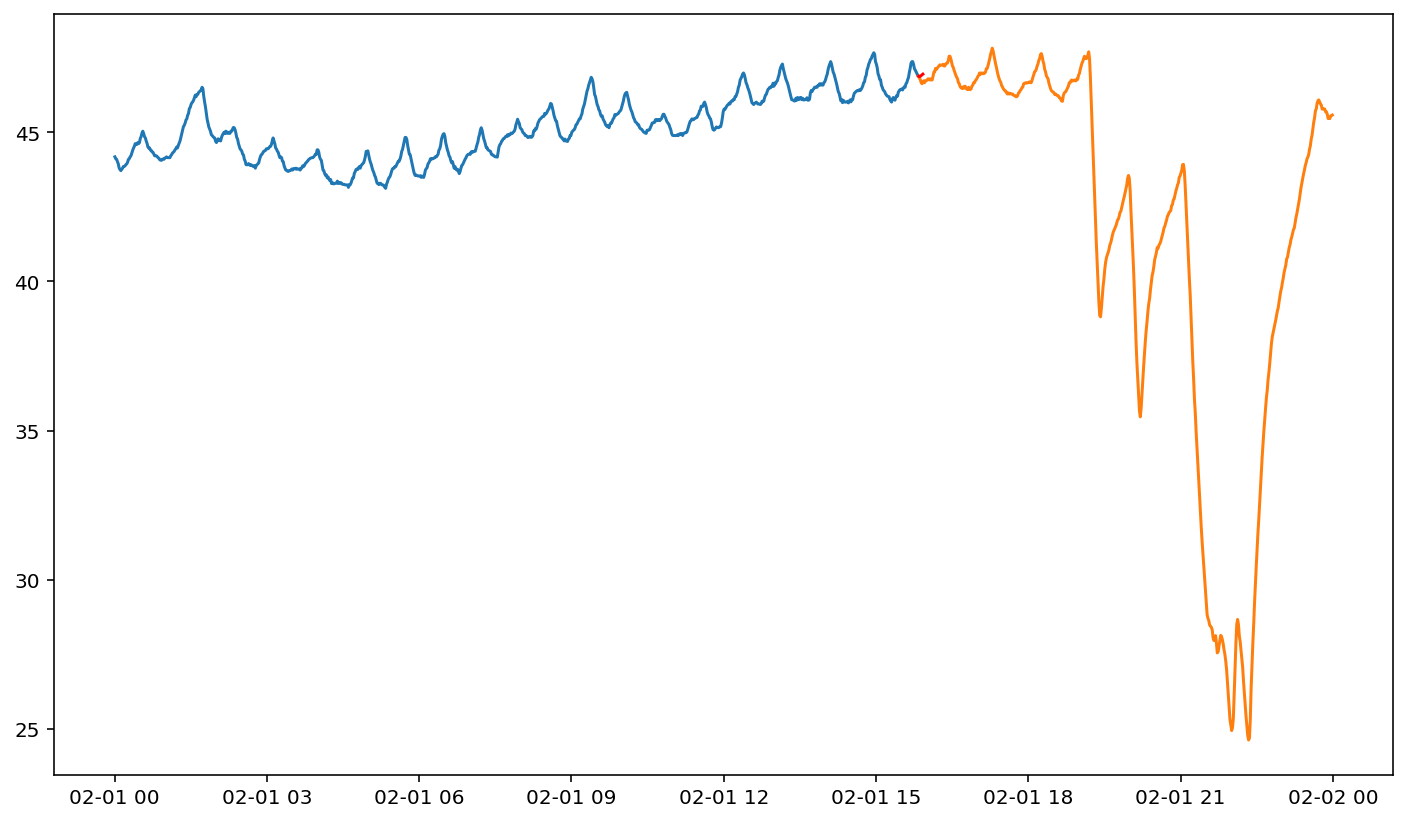

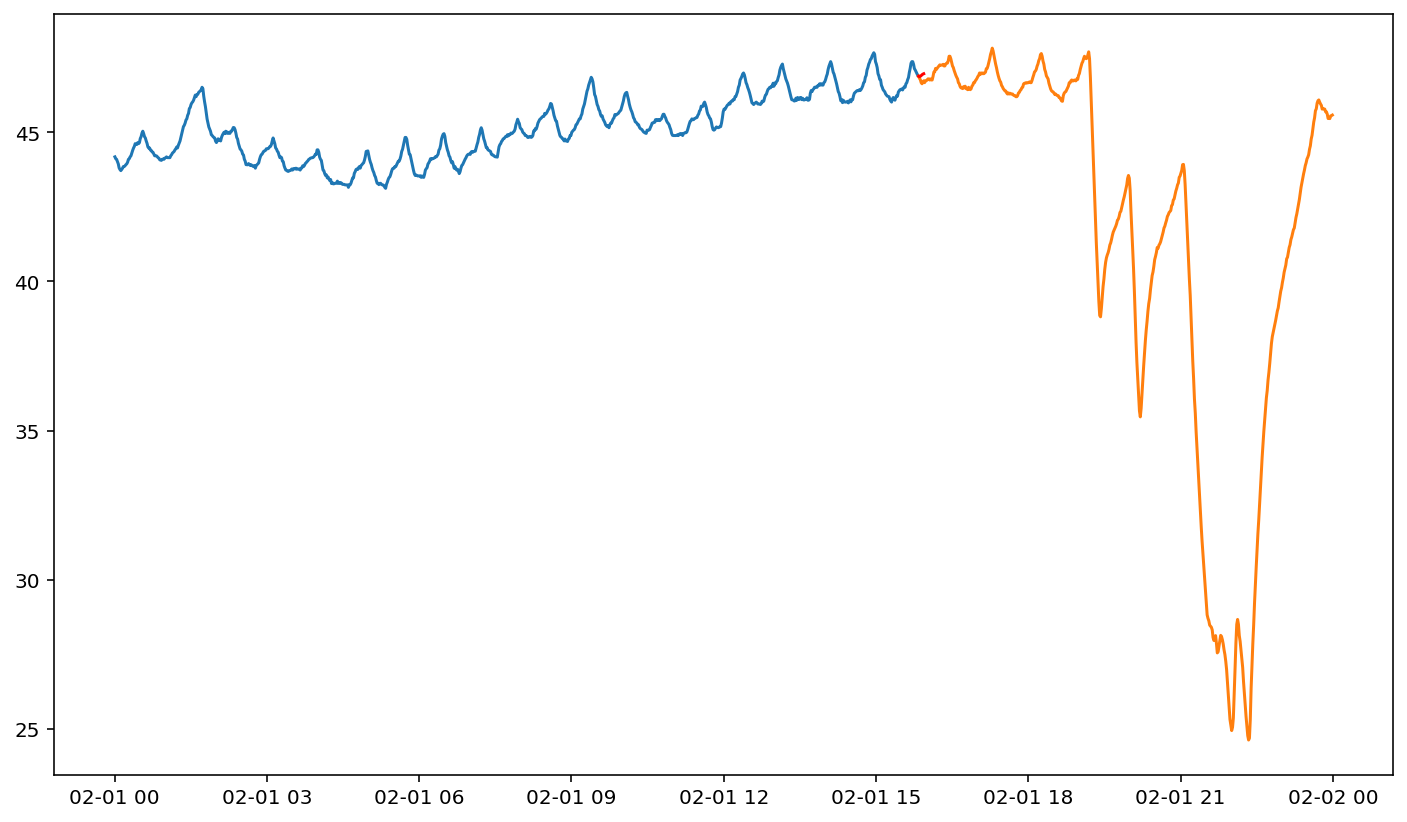

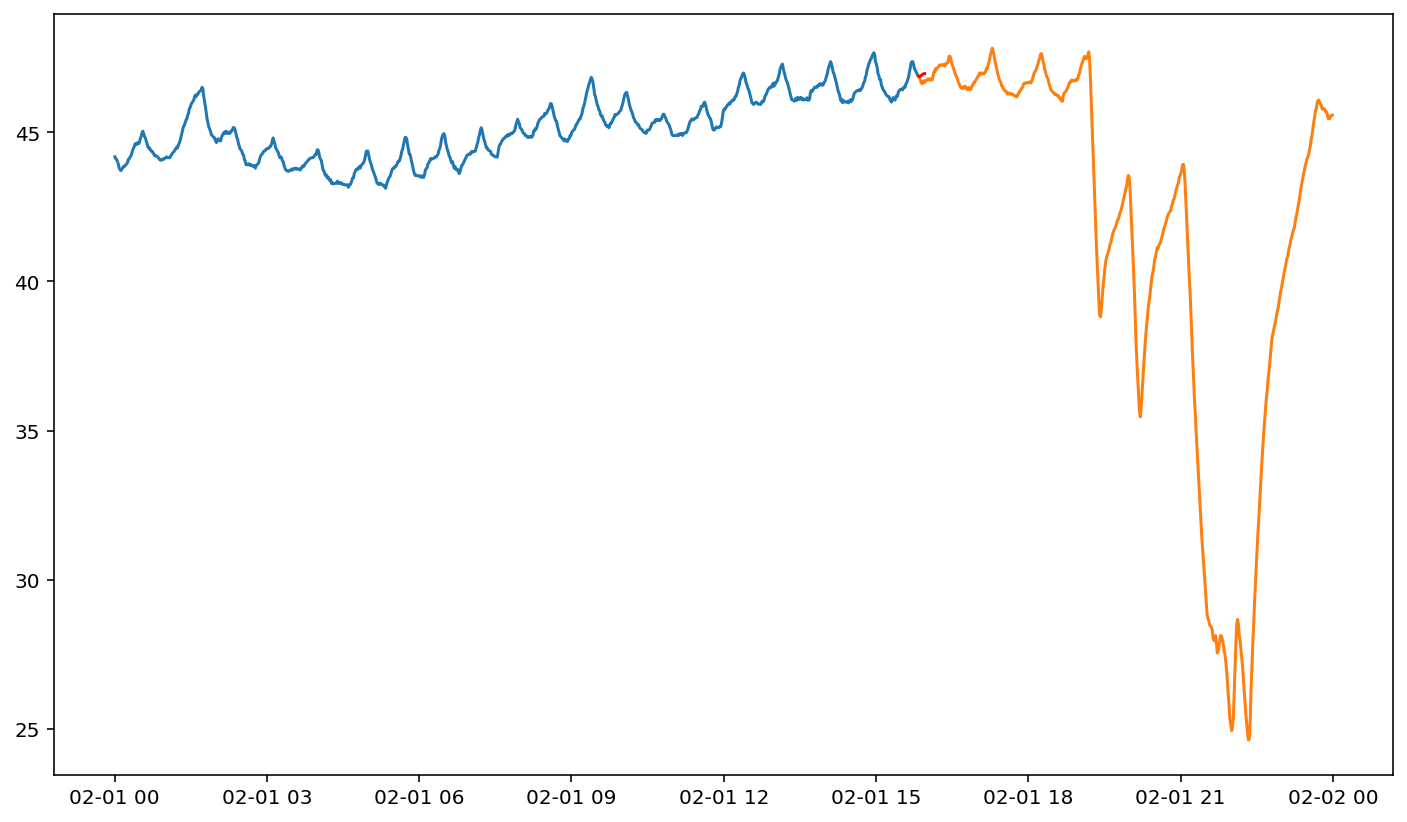

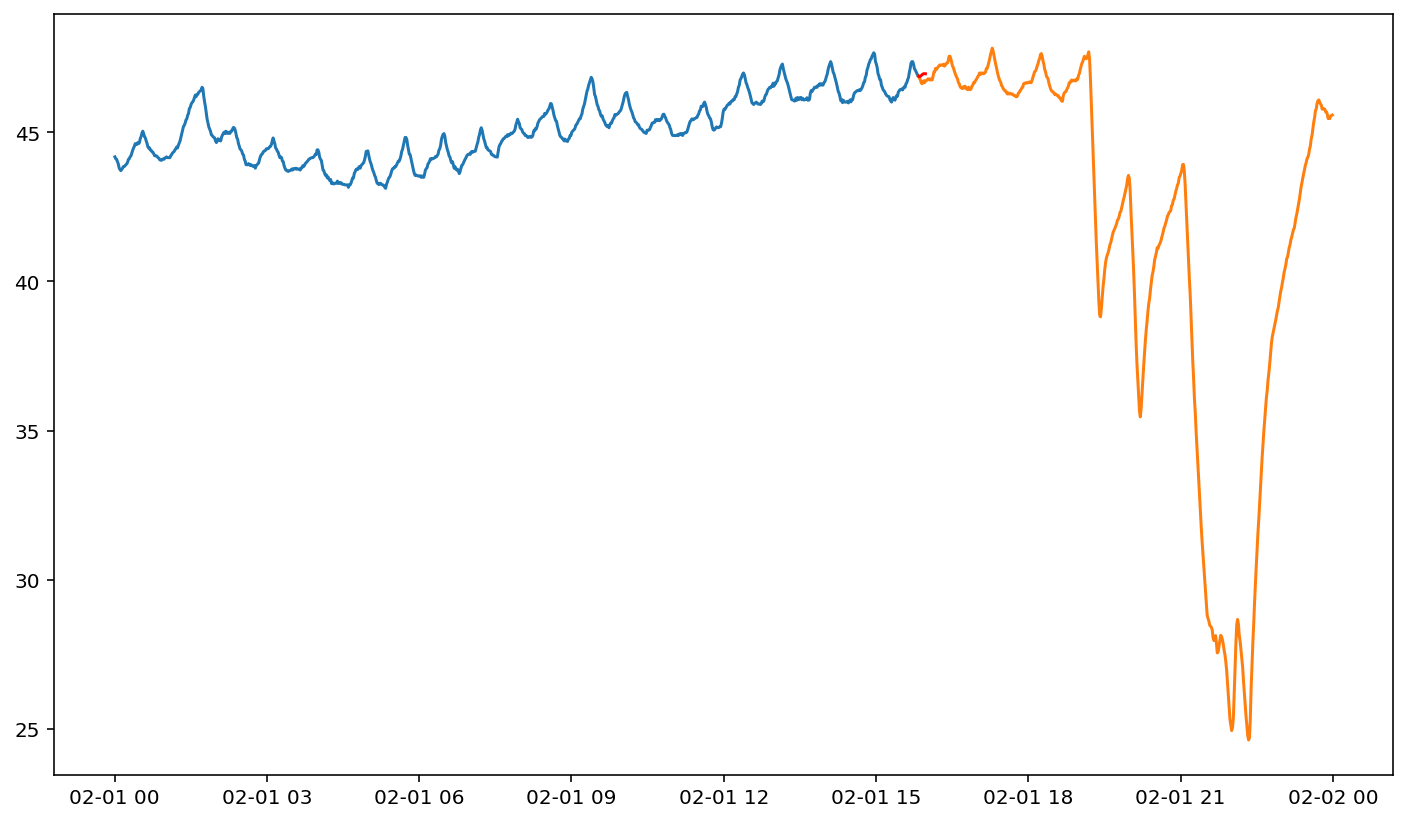

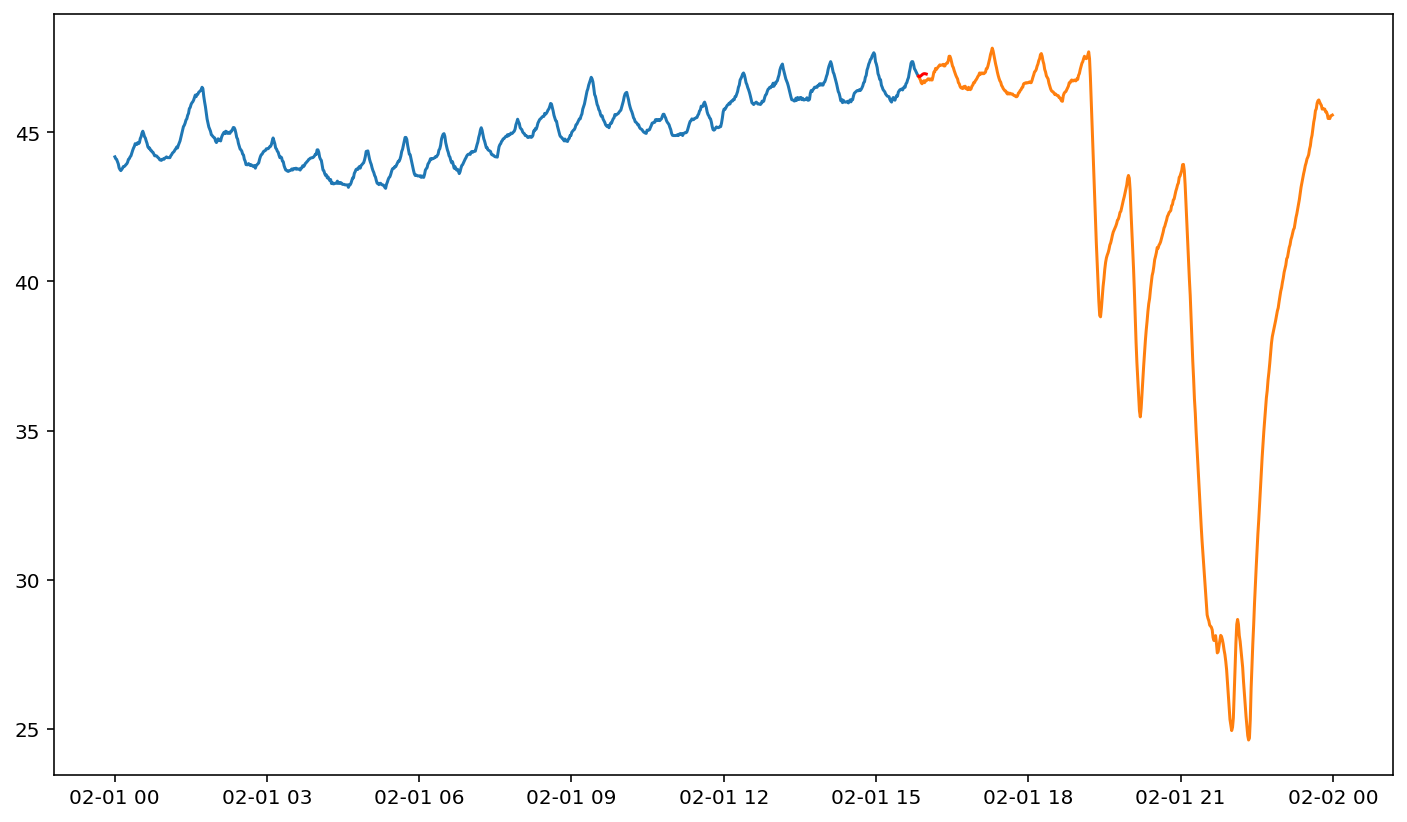

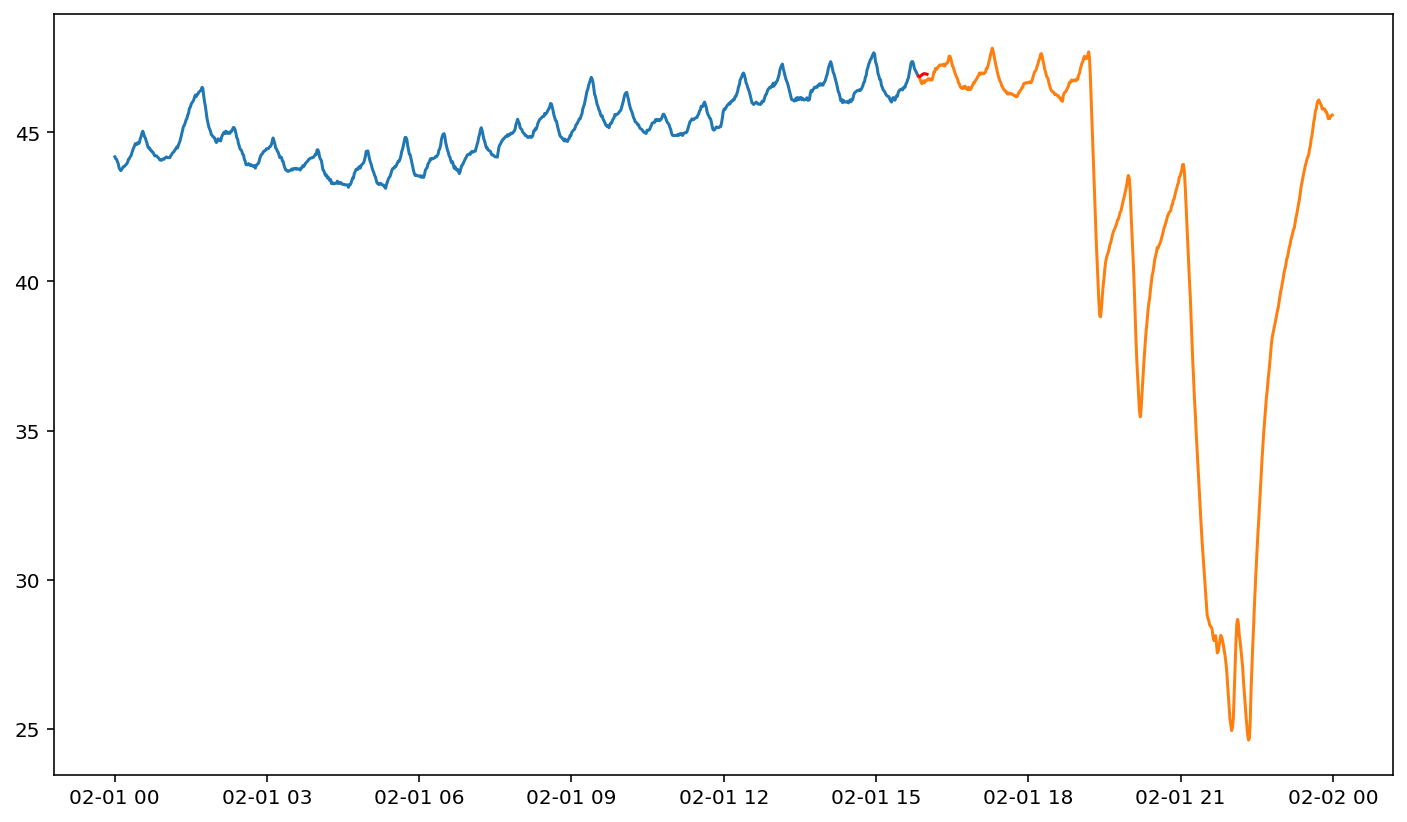

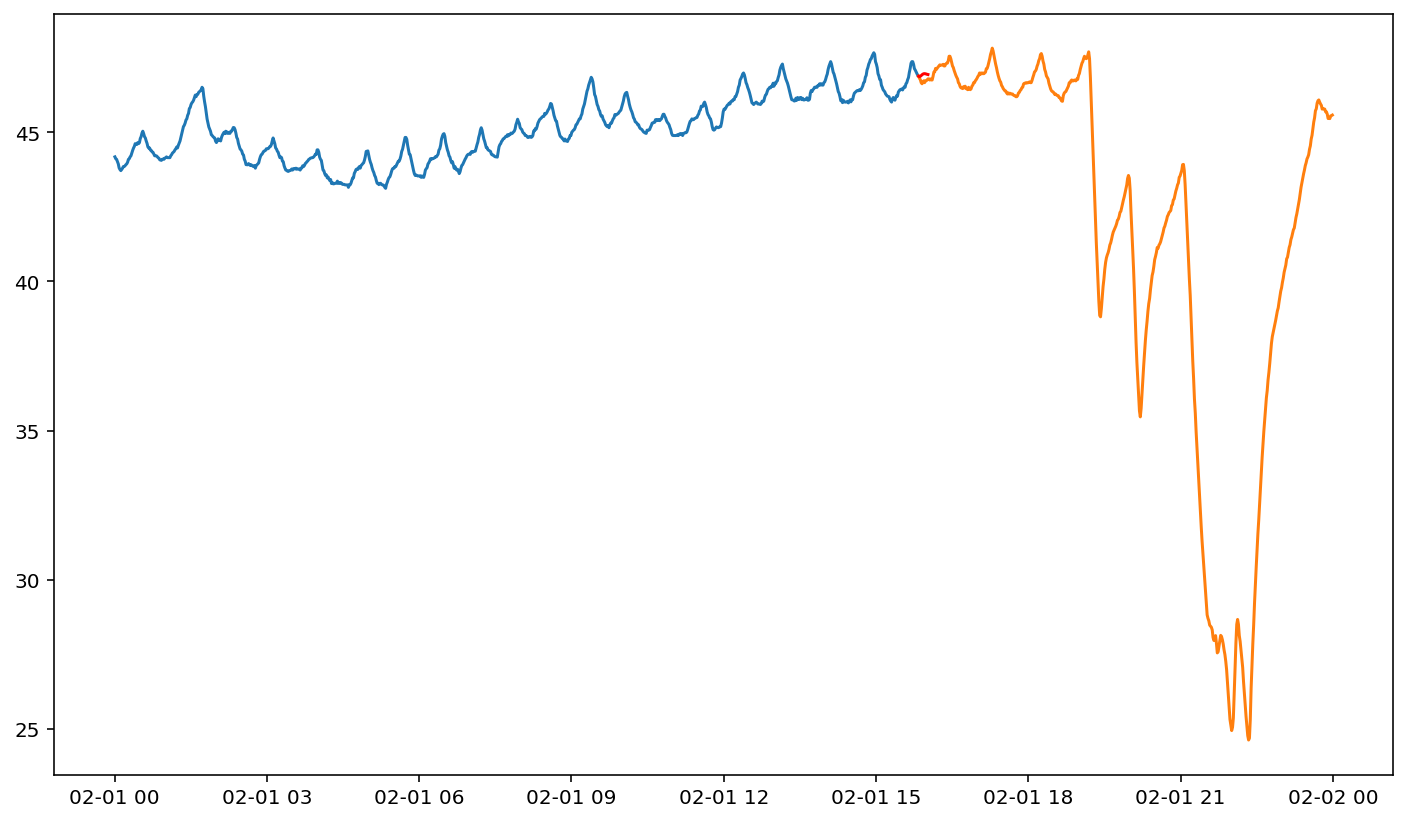

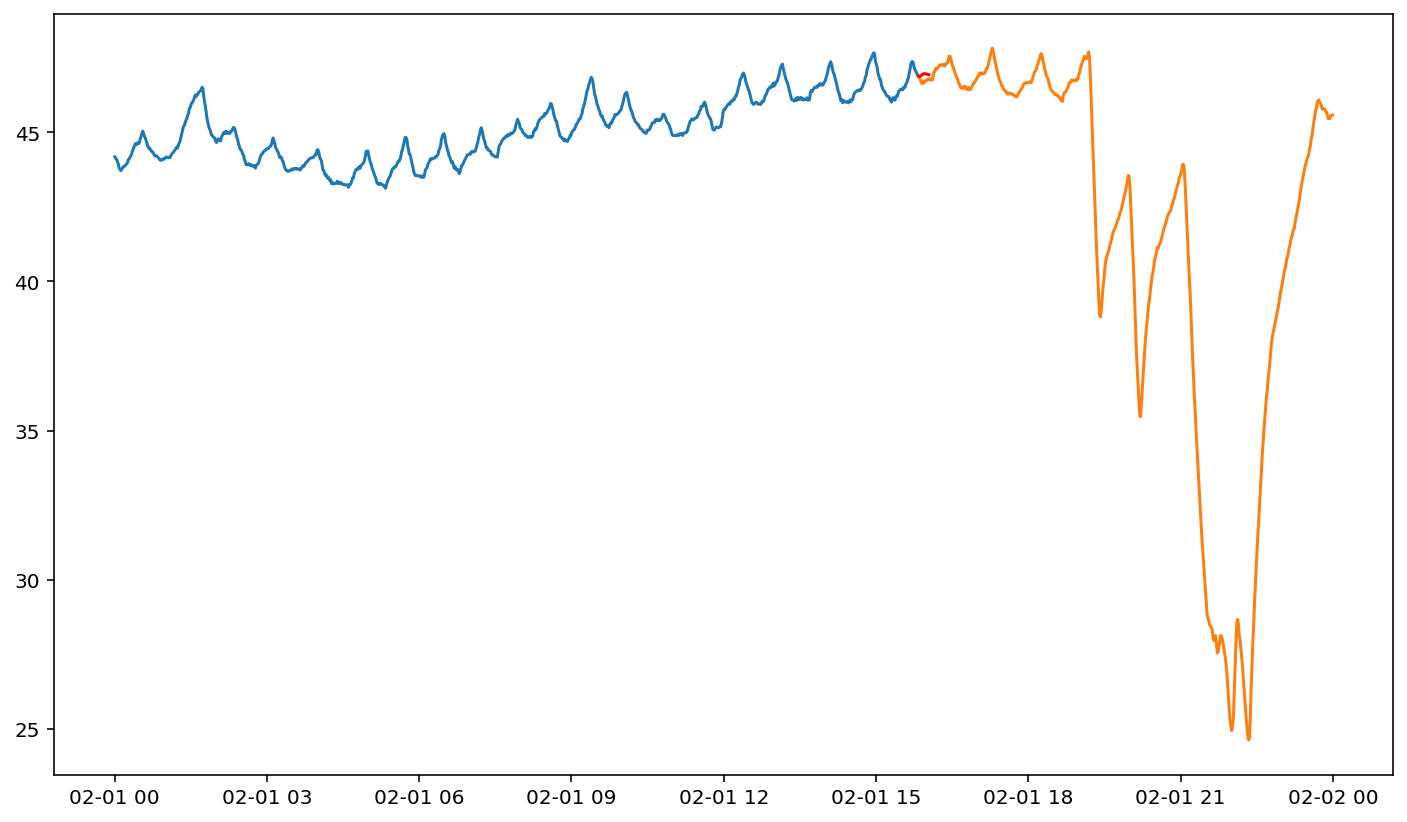

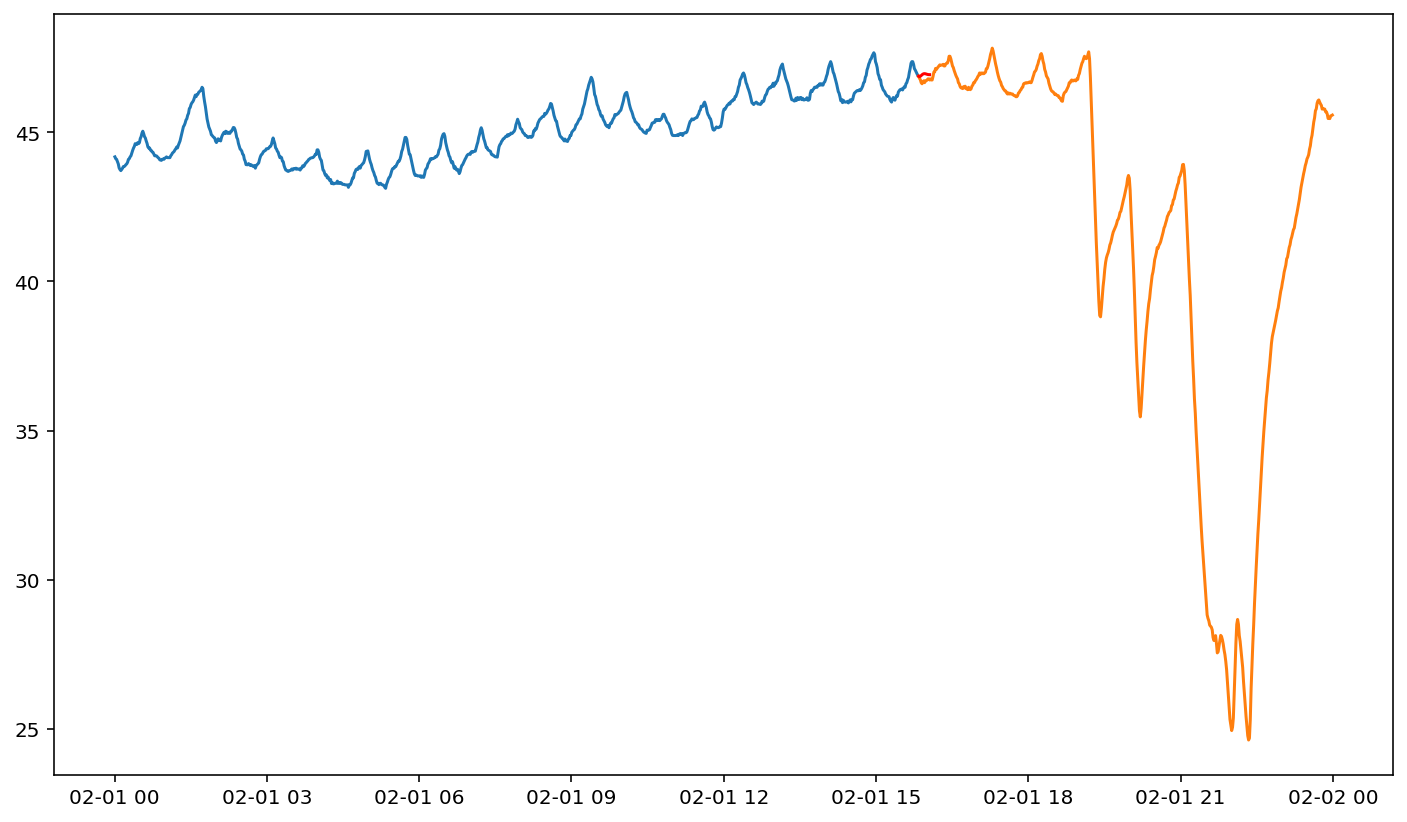

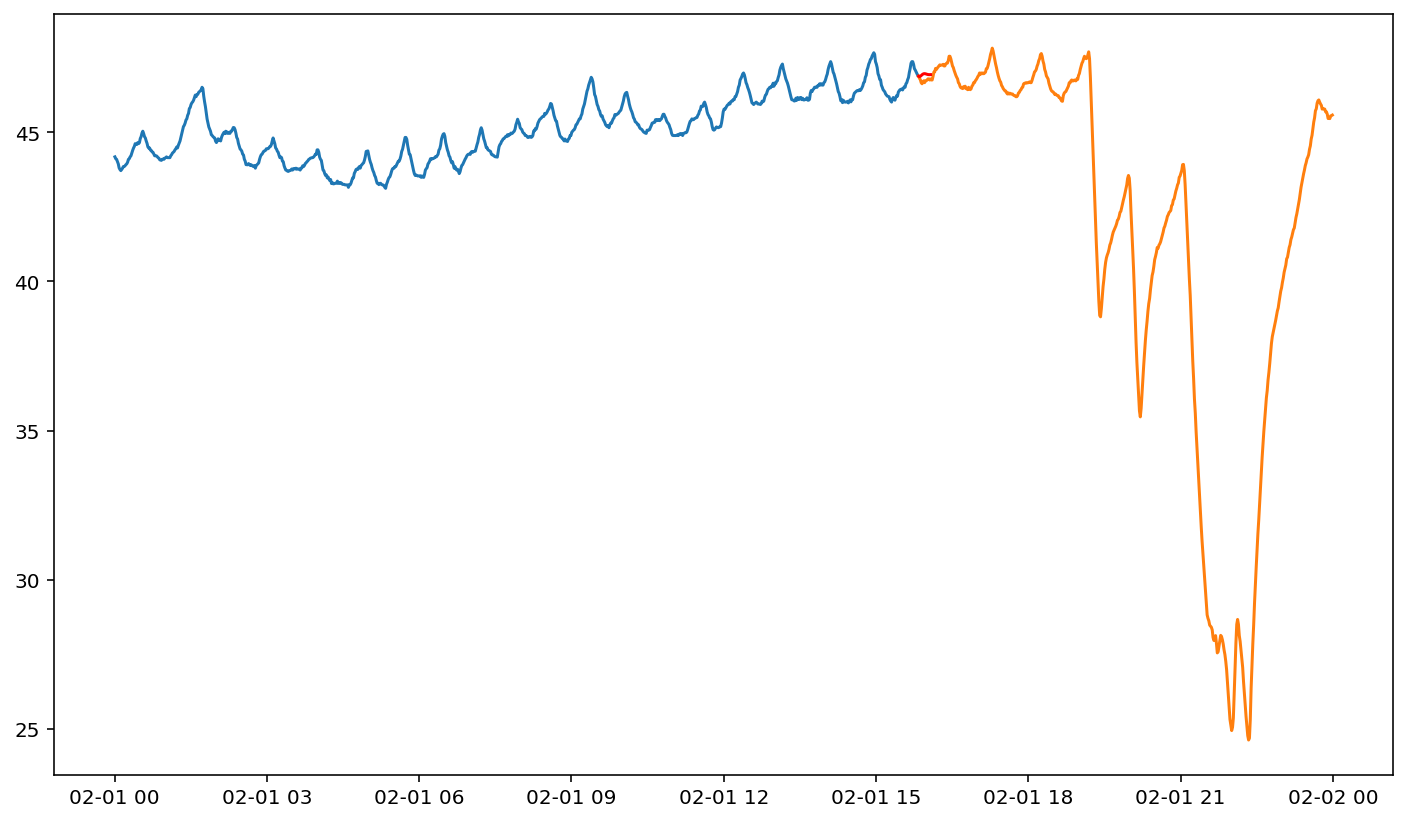

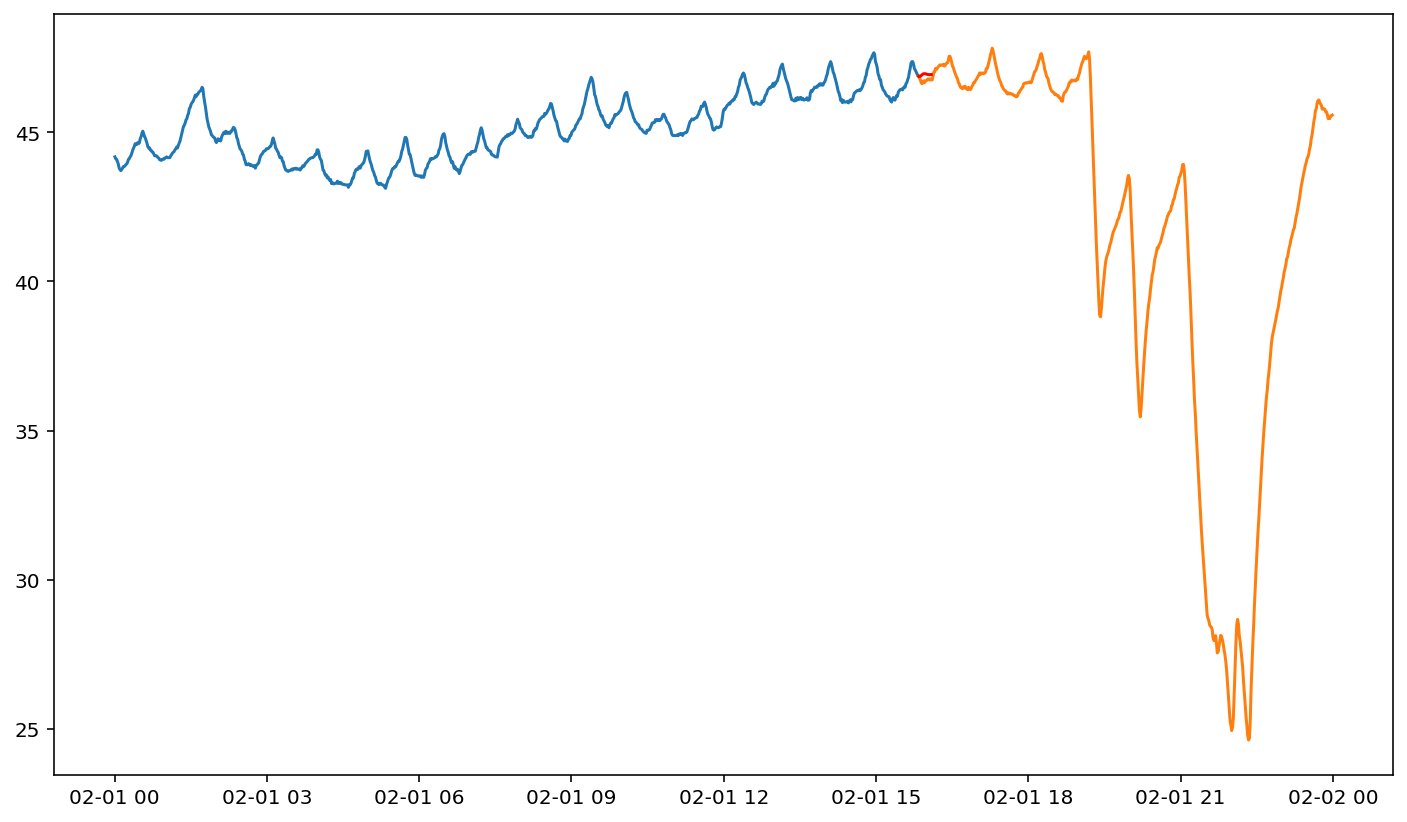

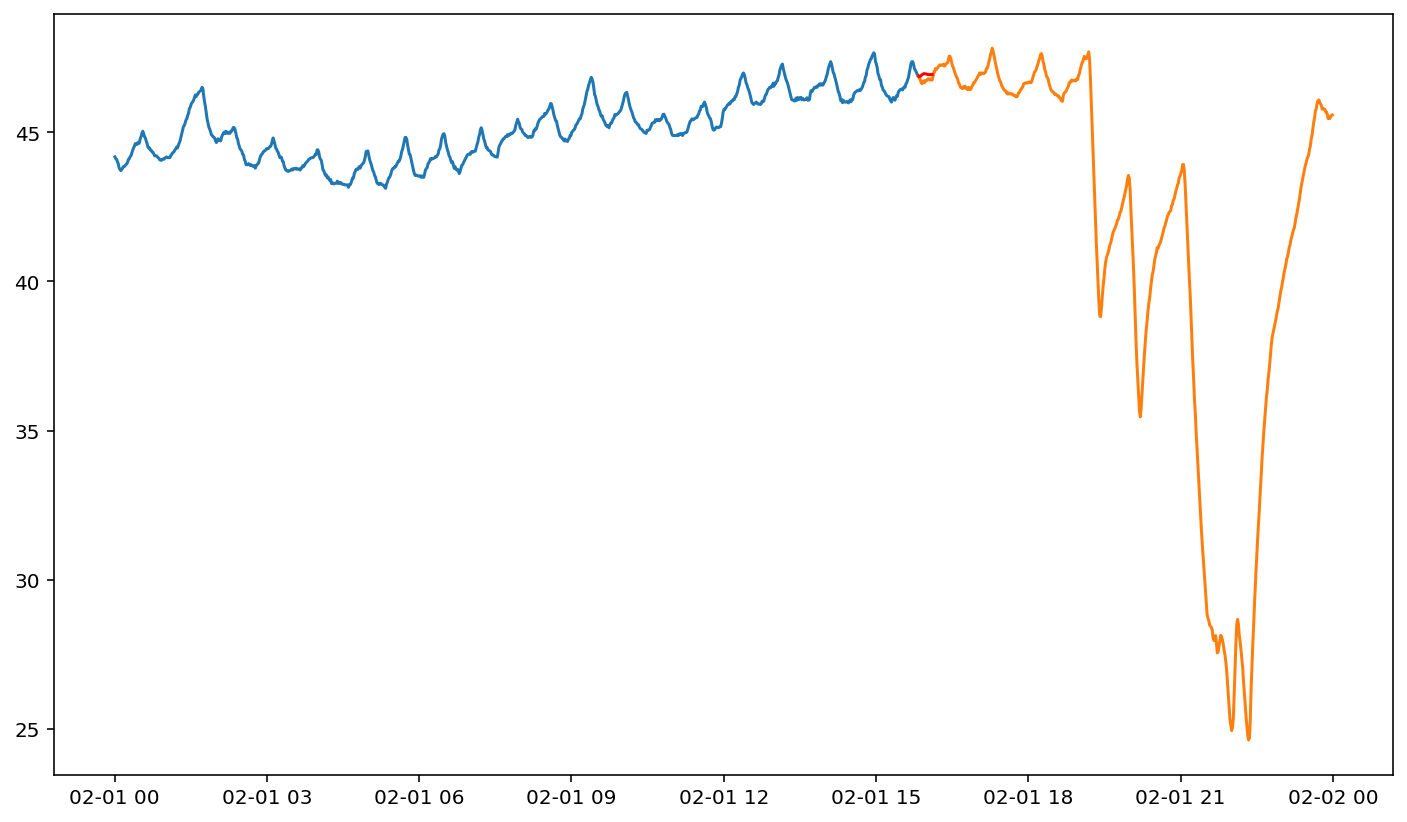

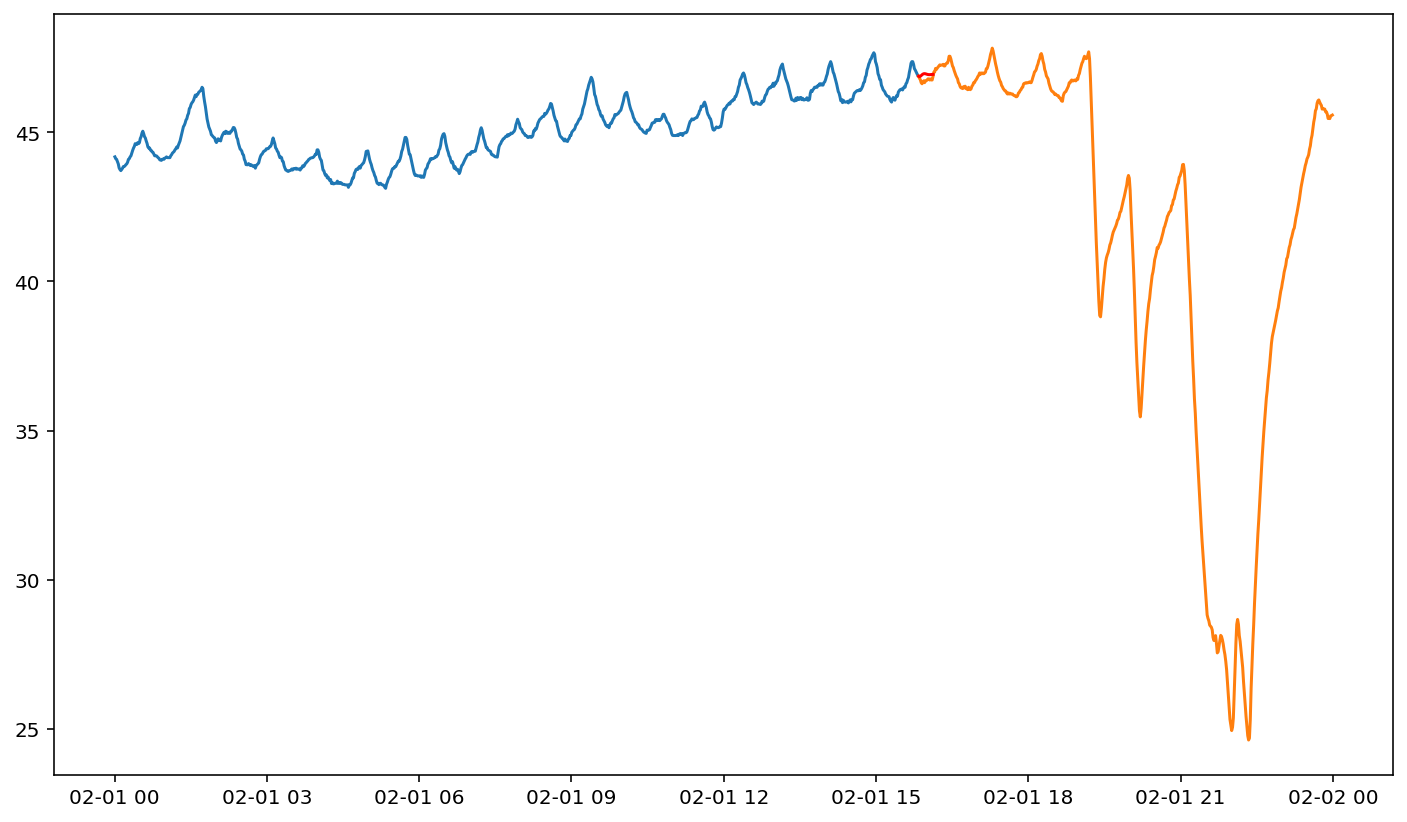

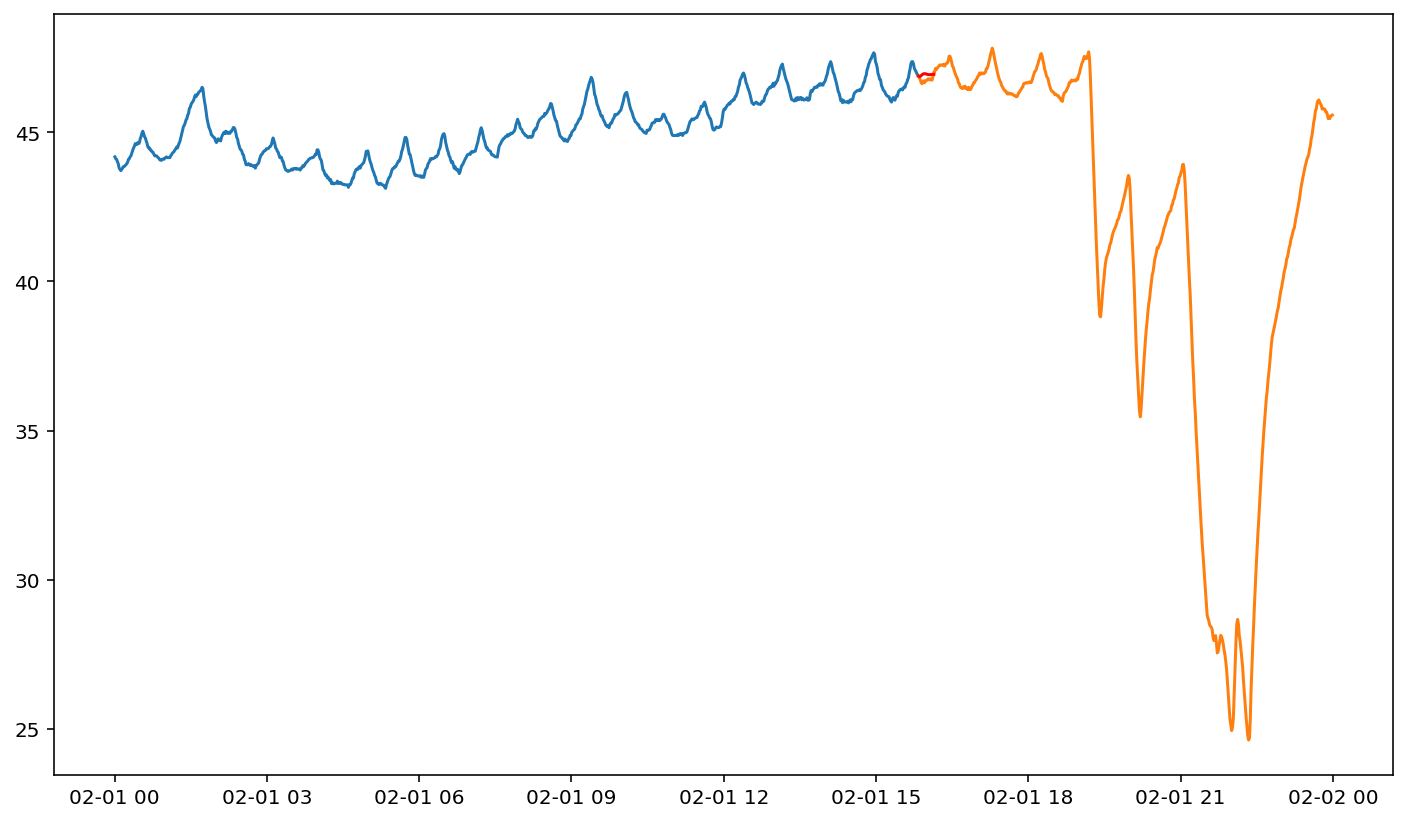

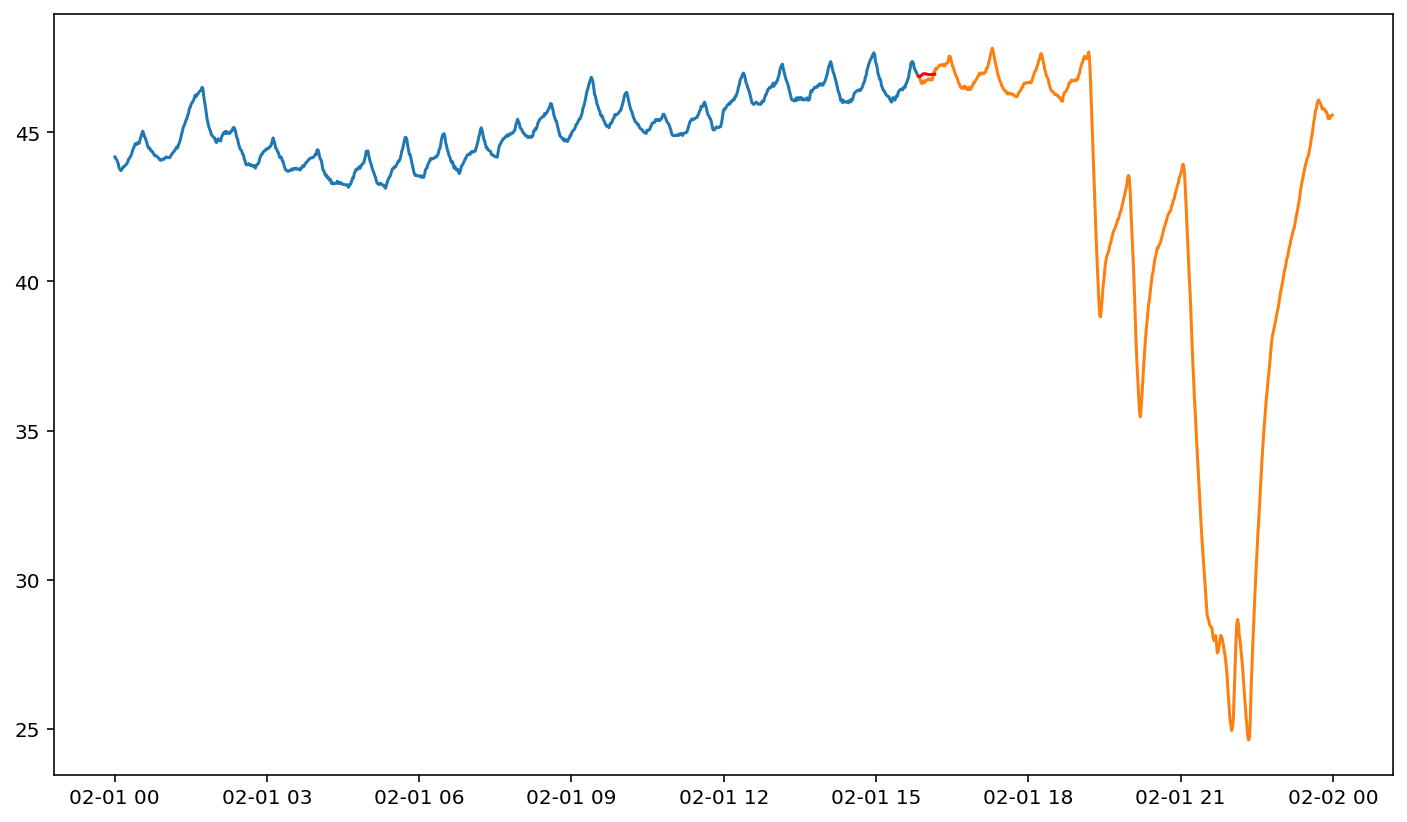

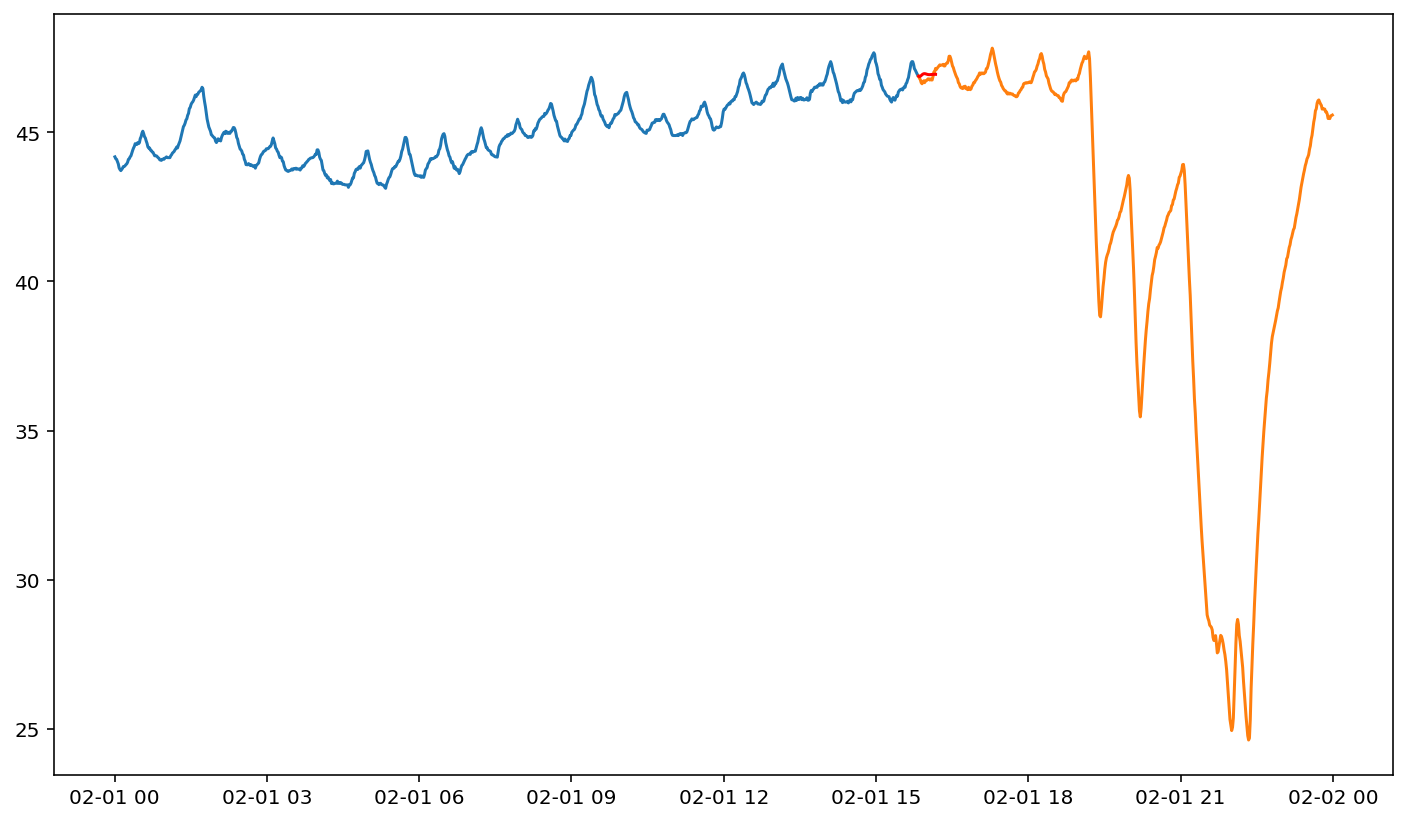

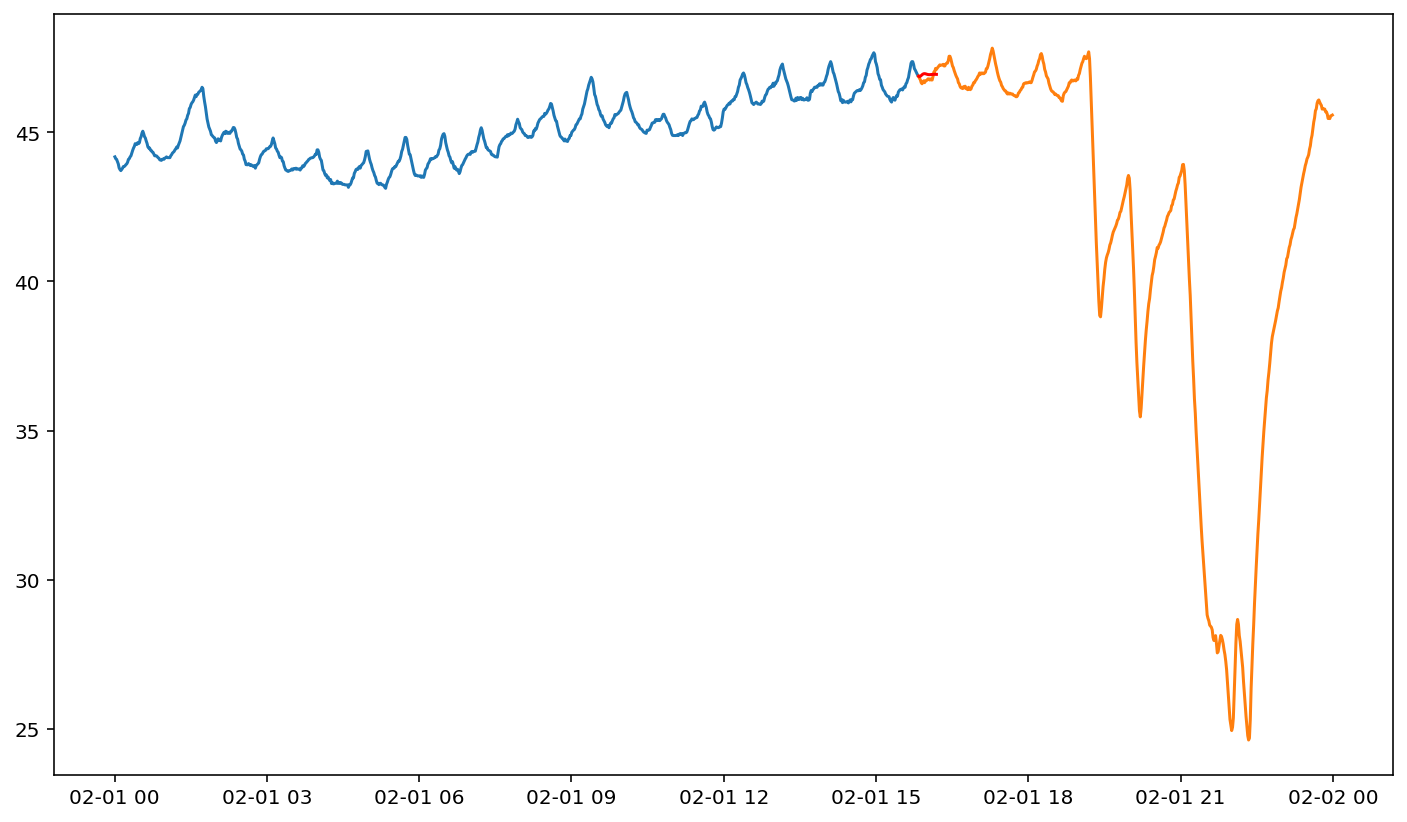

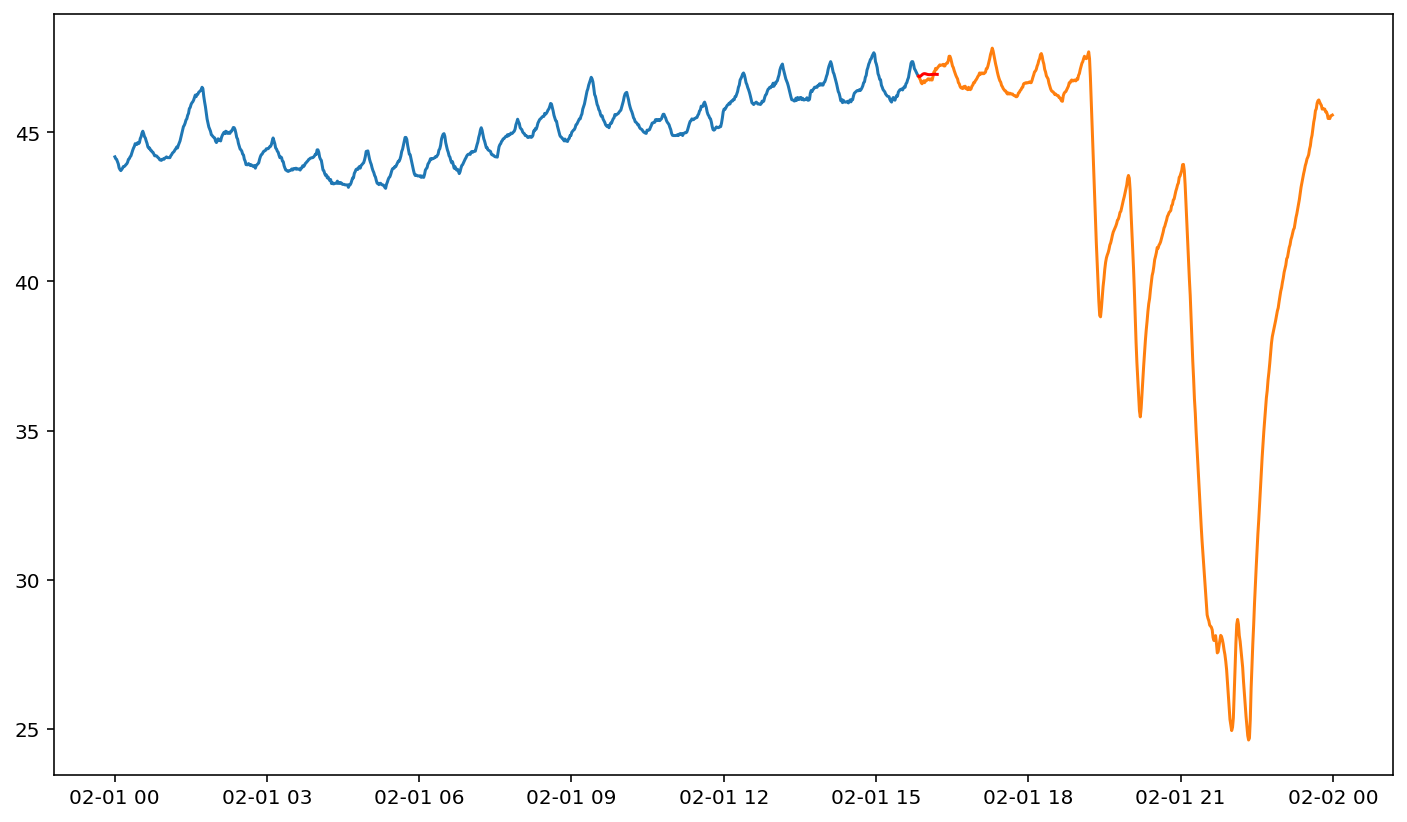

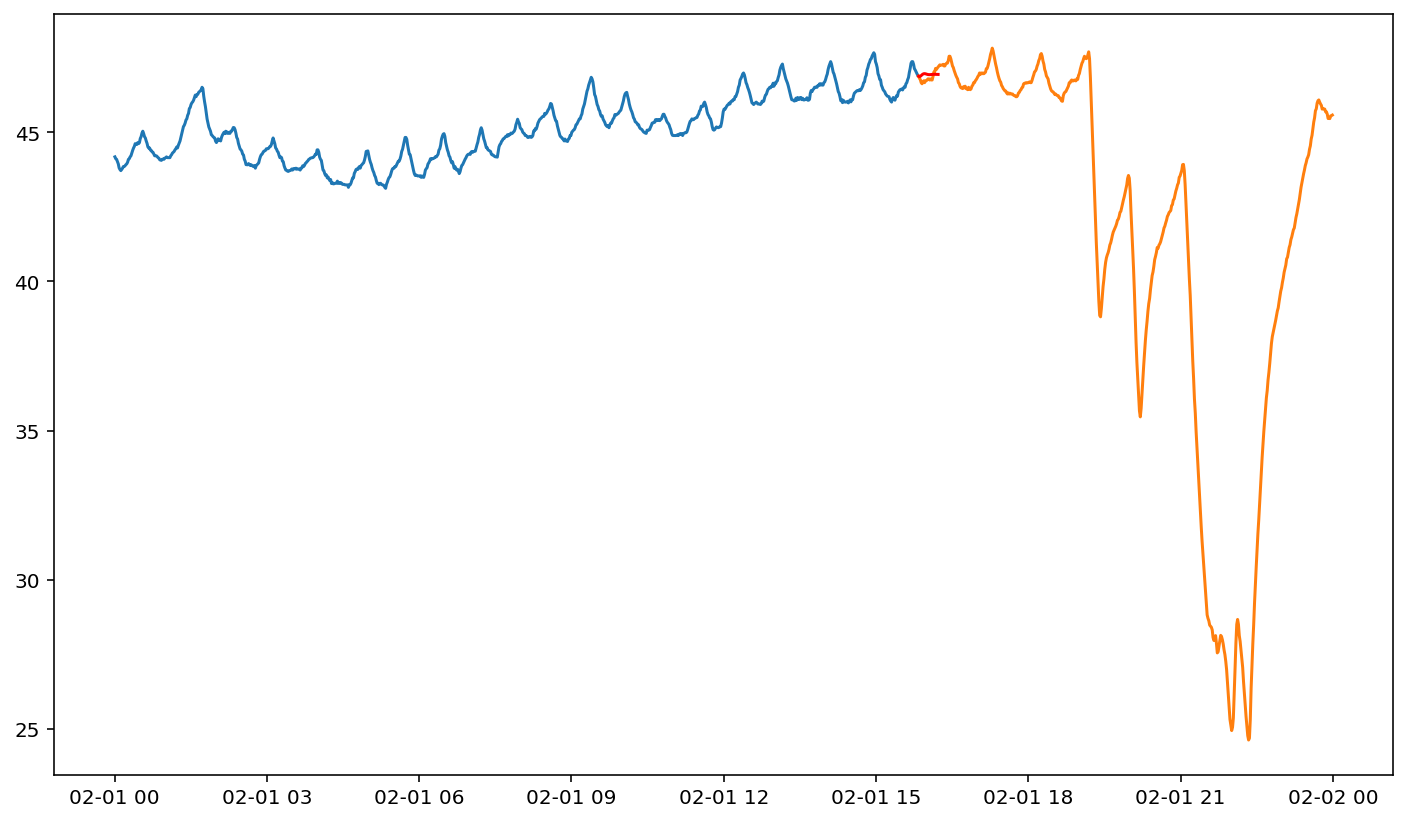

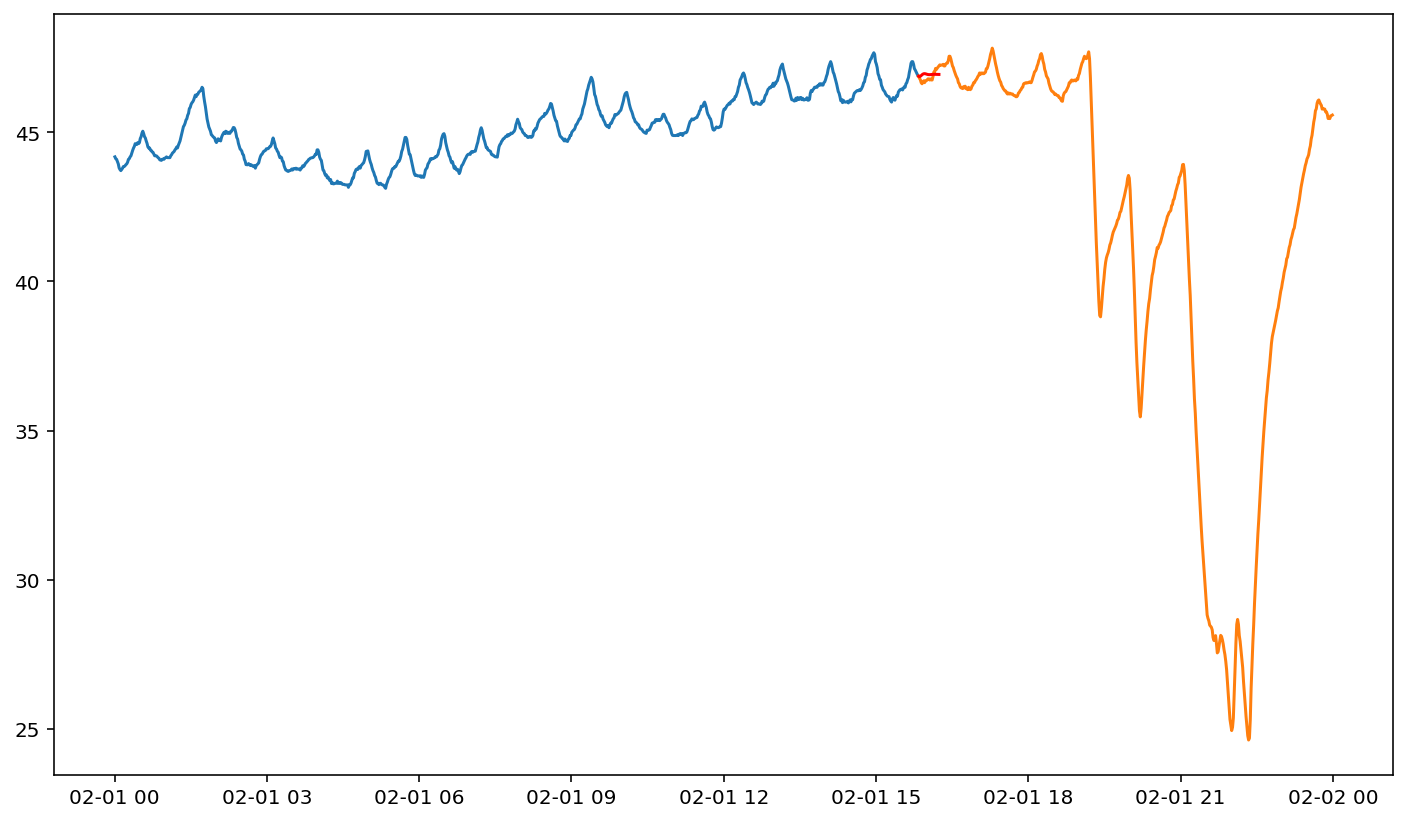

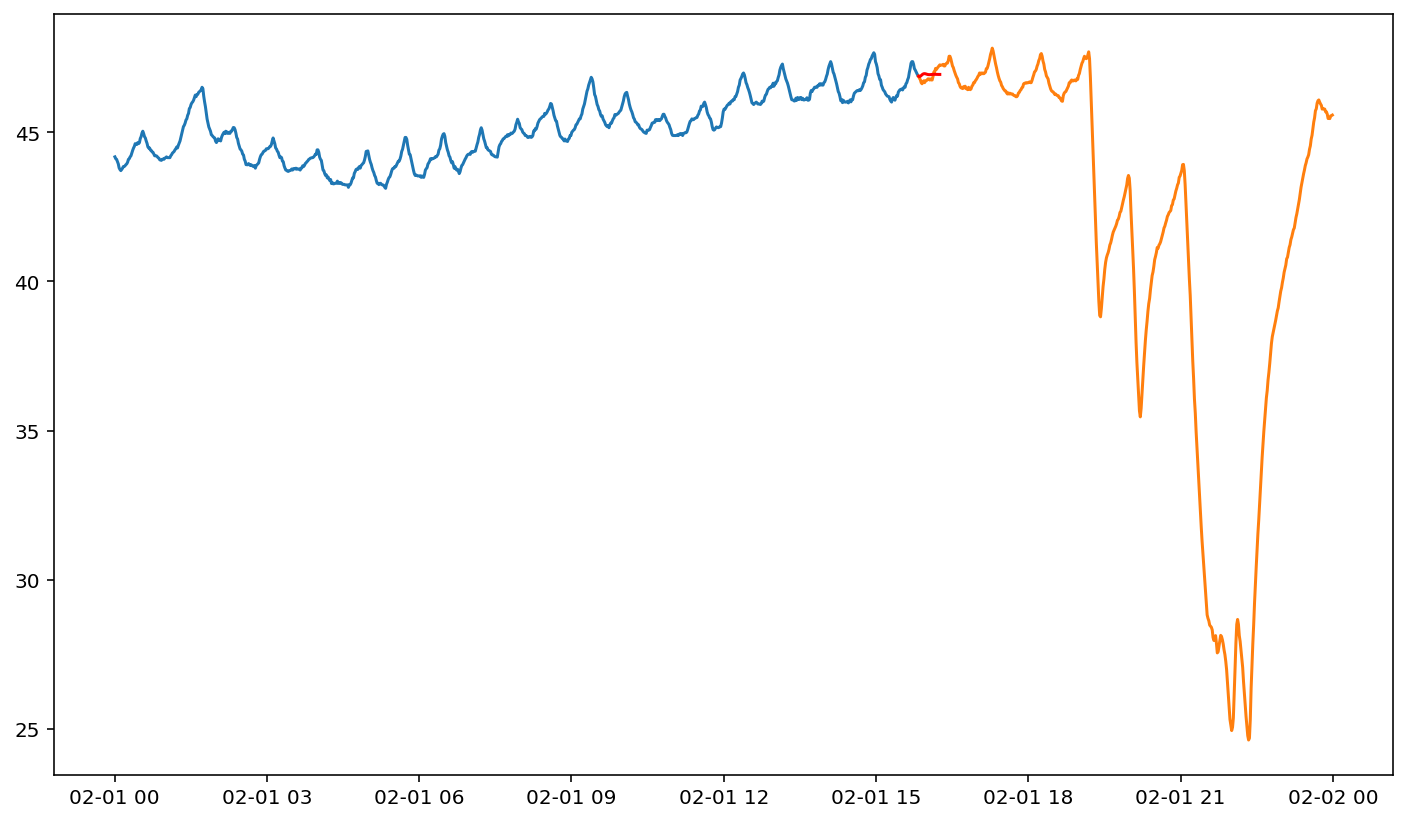

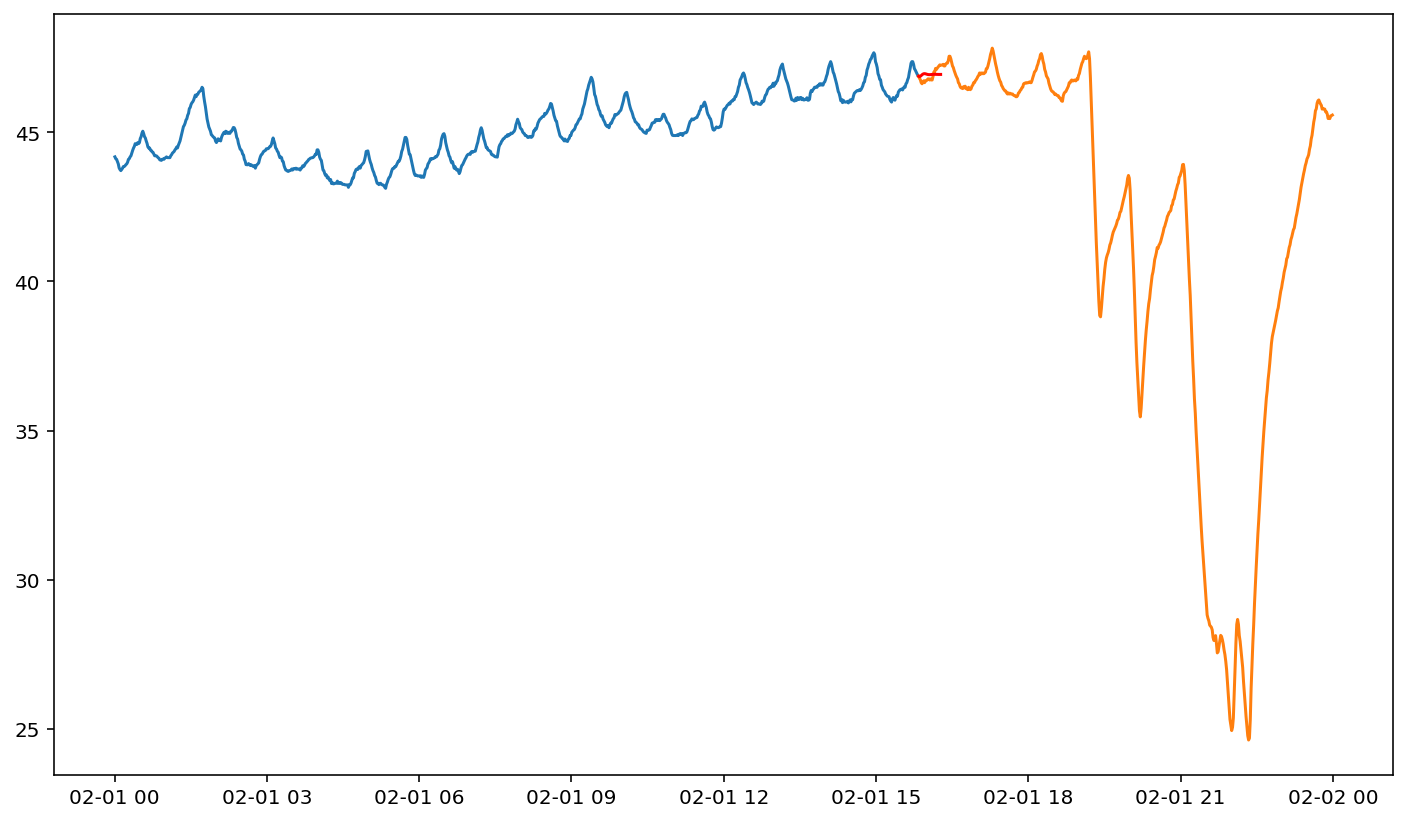

Error in callback <function flush_figures at 0x7f8913972290> (for post_execute):


KeyboardInterrupt: 

In [622]:
from tqdm.notebook import tqdm

X = ts["2020-02-01"]
X_d = X.diff()
X_2d = X_d.diff()

train_size = int(X.shape[0] * 0.66)
X_train_init, X_test_init = X[:train_size], X[train_size:]
X_train_diff, X_test_diff = X_d[:train_size], X_d[train_size:]
X_train_2diff, X_test_2diff = X_2d[:train_size], X_2d[train_size:]

history = [x for x in X_train_2diff.fillna(0)]
diff2_preds = [X_test_diff[0]]
diff_preds = [X_test_init[0]]
preds = [X_test_init[0]]

for i,t in tqdm(enumerate(X_test_diff.index), total=len(X_test_diff)):
    model = ARIMA(history, order=(2,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    
    yhat_2diff = output[0]
    diff2_preds.append(yhat_2diff[0])
    
    yhat_diff = sum(diff2_preds)
    diff_preds.append(yhat_diff)
    
    yhat = sum(diff_preds)
    preds.append(yhat)
    obs = X_test_init[t]
    history.append(yhat_diff)
    if i%10 == 0:
        print('predicted=%f, expected=%f' % (yhat, obs))
    
    fig, ax = plt.subplots(figsize=(12,7))
    
    Train_line = ax.plot(X_train_init.index, X_train_init.values)
    Test_line = ax.plot(X_test_init.index, X_test_init.values)
    Pred_line = ax.plot(X_test_init.index[:len(preds)], preds, color='red')
    
    plt.savefig(f"./pred_gif/{i}_frame.png")
#     plt.show()

    
error = mean_squared_error(X_test, preds)
print('Test MSE: %.3f' % error)

In [623]:
import os
from PIL import Image

images = []
for img_name in sorted(os.listdir("./pred_gif")):
    img = Image.open(f"./pred_gif/{img_name}")
    images.append(img)

images[0].save('pred_gif.gif', save_all=True, append_images=images[1:], optimize=True, duration=40, loop=0)

# _EOF_